# Indepedent Study Report#
## &copy;  [Jinghong Li] ##
### Industrial and Enterprise Systems Engineering, The Grainger College of Engineering,  UIUC ###

<hr style="border:2px solid blue"> </hr>


# Brief Description

In this research, I **compared the performance of various machine learning models**, suitable to deal with time series, in prediction cryptocurrency price. In particular, I did a wide search on the key parameters and compared their prediction performance under different settings. 

For comprehensiveness of comparison, i applied the models in two cryptocurrencies-**Bitcoin(BTC) and Ethereum(ETH)**. 

ML models including:
- LSTM
- Bi-LSTM
- GRU
- T2V+LSTM
- XGBoost

and two models that are less suitable for large data volumes:
- ARIMA
- FBProphet

Evaluation Metrics:
\begin{equation}  \label{eqn1}
RMSE = \sqrt{\frac{1}{n}\sum_{n}^{i=1}(y^{(i)}-\hat{y}^{(i)})^{2}},
\end{equation}

\begin{equation}  \label{eqn2}
MAE = \frac{1}{n}\sum_{n}^{i=1}\left |y^{(i)}-\hat{y}^{(i)}  \right |,
\end{equation}

Comparasion Result:
![title](pics/comparision.png)

# Import Libraries

The **requirements.txt** has provided to set the environment quickly, if you need to run the notebook quickly, I recommend disabling the tensorflow GPU, then daily price dataset will be used by default. 

In [ ]:
# to disable GPU with TensorFlow, you need to run the following code
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [9]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import optuna
import random
import seaborn as sns
import scipy.stats as stats
import matplotlib.dates as mdates
import matplotlib.pyplot as mp
import tensorflow as tf
import datetime as dt
from tqdm import tqdm

from xgboost import XGBRegressor
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
import keras.optimizers as optimizers
from keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional, Layer
from keras.backend import clear_session
from keras import Sequential, layers, callbacks 
from tensorflow.keras import layers, Model, backend as K

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from fbprophet import Prophet
pd.core.common.is_list_like = pd.api.types.is_list_like

# set random seed to reproduce the result
tf.keras.utils.set_random_seed(2022)
np.random.seed(2022)
random.seed(2022)

# ouput directory of all models
output_directory='./models'

# Load and Preprocess Data

In [17]:
def load_data(timerange=[20200929, 20220429]):

#   the tuning process will take very long time if we use minute-by-minute data without GPU

    if tf.test.is_gpu_available():
        btcdf = pd.read_csv('BTC_1min.csv')
        btcdf['Date']= pd.to_datetime(btcdf['Unix Timestamp'],unit='s')
        btcdf = btcdf.drop('Unix Timestamp', axis=1)
        # btcdf = btcdf.set_index("Date")
        btcdf = btcdf.set_index("Date")[['Close']]
        btcdf = btcdf.query(f"{timerange[0]} < index < {timerange[1]}")
        btcdf = btcdf.rename(columns={"Close": "Price"})
        btcdf = btcdf.asfreq(freq='T', method='ffill')

        ethdf = pd.read_csv('ETH_1min.csv')
        ethdf['Date']= pd.to_datetime(ethdf['Unix Timestamp'], unit='s')
        ethdf = ethdf.drop('Unix Timestamp', axis=1)
        # ethdf = ethdf.set_index("Date")
        ethdf = ethdf.set_index("Date")[['Close']]
        ethdf = ethdf.query(f"{timerange[0]} < index < {timerange[1]}")
        ethdf = ethdf.rename(columns={"Close": "Price"})
        ethdf = ethdf.asfreq(freq='T', method='ffill')
    else:
        btcdf = pd.read_csv('BTCData_daily.csv')
        btcdf = btcdf.replace(',','', regex=True)
        btcdf = btcdf[['Price', 'Date']][::-1]
        btcdf['Date']= pd.to_datetime(btcdf['Date'])
        btcdf = btcdf.set_index("Date")
        btcdf['Price'] = pd.to_numeric(btcdf['Price'],errors='coerce')
        
        ethdf = pd.read_csv('ETHData_daily.csv')
        ethdf = ethdf.replace(',','', regex=True)
        ethdf = ethdf[['Price', 'Date']][::-1]
        ethdf['Date']= pd.to_datetime(ethdf['Date'])
        ethdf = ethdf.set_index("Date")
        ethdf['Price'] = pd.to_numeric(ethdf['Price'],errors='coerce')
        
    return btcdf, ethdf

In [18]:
btc_df, eth_df = load_data()
btc_df.head(5)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


,Price
Date,
2020-09-29 00:01:00,10674.00
2020-09-29 00:02:00,10682.12
2020-09-29 00:03:00,10688.11
2020-09-29 00:04:00,10691.48
2020-09-29 00:05:00,10703.34


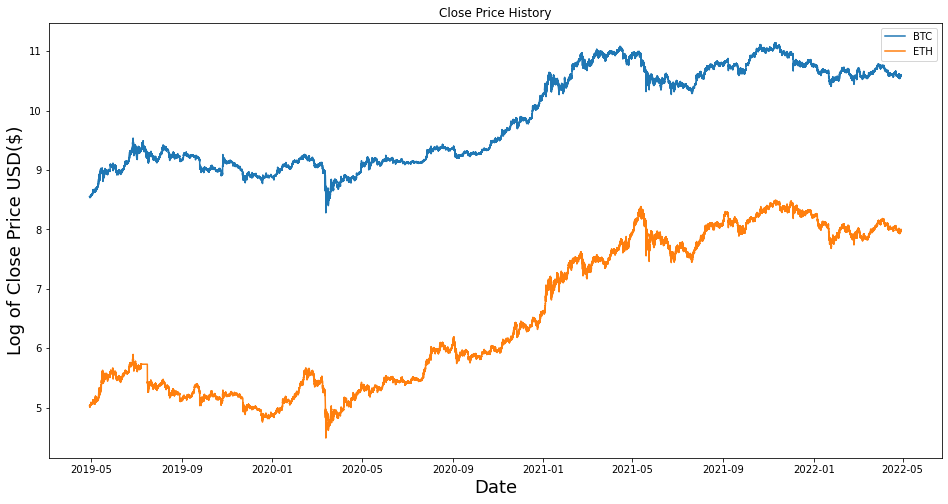

In [8]:
# Visualize log of the closing price history

plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(np.log(btc_df['Price']))
plt.plot(np.log(eth_df['Price']))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Log of Close Price USD($)', fontsize=18)
plt.legend(['BTC', 'ETH']) 
plt.show()

# EDA

            Open      High       Low     Price    Volume
Open    1.000000  0.999999  0.999999  0.999998  0.029007
High    0.999999  1.000000  0.999998  0.999999  0.029499
Low     0.999999  0.999998  1.000000  0.999999  0.028393
Price   0.999998  0.999999  0.999999  1.000000  0.028946
Volume  0.029007  0.029499  0.028393  0.028946  1.000000


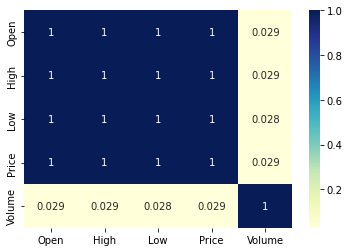

In [14]:
# feature correlation analysis

timerange = [20190429, 20220429]
btcdf = pd.read_csv('BTC_1min.csv')
btcdf['Date']= pd.to_datetime(btcdf['Unix Timestamp'],unit='s')
btcdf = btcdf.drop('Unix Timestamp', axis=1)
btcdf = btcdf.set_index("Date")
btcdf = btcdf.query(f"{timerange[0]} < index < {timerange[1]}")
btcdf = btcdf.rename(columns={"Close": "Price"})

# prints data that will be plotted
# columns shown here are selected by corr() since
# they are ideal for the plot
print(btcdf.corr())
dataplot = sns.heatmap(btcdf.corr(), cmap="YlGnBu", annot=True)
mp.show()

All variables have either prefect positive linear correlation or no linear correlation with close price, that means we can only retain the close price for our prediction task.

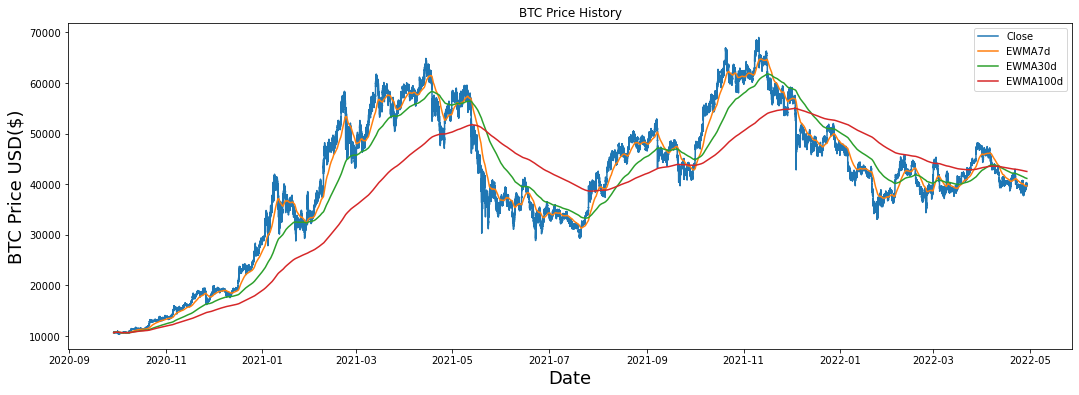

In [28]:
btc_df_ma = btc_df.copy()
# calculating exponential moving average
# using .ewm(span).mean() , with window size: 7days, 30days, 100days
btc_df_ma['EWMA7d'] = btc_df_ma['Price'].ewm(span=1440 * 7).mean()
btc_df_ma['EWMA30d'] = btc_df_ma['Price'].ewm(span=1440 * 30).mean()
btc_df_ma['EWMA100d'] = btc_df_ma['Price'].ewm(span=1440 * 100).mean()

#Visualize the closing price history
plt.figure(figsize=(18, 6))
plt.title('BTC Price History')
plt.plot(btc_df_ma['Price'])
plt.plot(btc_df_ma['EWMA7d'])
plt.plot(btc_df_ma['EWMA30d'])
plt.plot(btc_df_ma['EWMA100d'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('BTC Price USD($)', fontsize=18)
plt.legend(['Close', 'EWMA7d', 'EWMA30d', 'EWMA100d'])
plt.show()

In real world finance data, the price does increase/decrease for some unexpected reasons, to get the figure that can represent the average price, we use moving average to smooth out price history by filtering out the noise from random-price fluctuations. It can help identify trend direction and determine support and resistant levels. 

Comparing to simple moving average, exponential moving average applies more weighting to the most recent prices. In the windows size of 30 and 100, the price from May 2020 to May 2021 is significantly above the moving average line, the BTC price is considered up. However, the relative position of the moving average line to the actual price during May 2021 and April 2022 was constantly fluctuating, which means there is not a stable up/down trend.

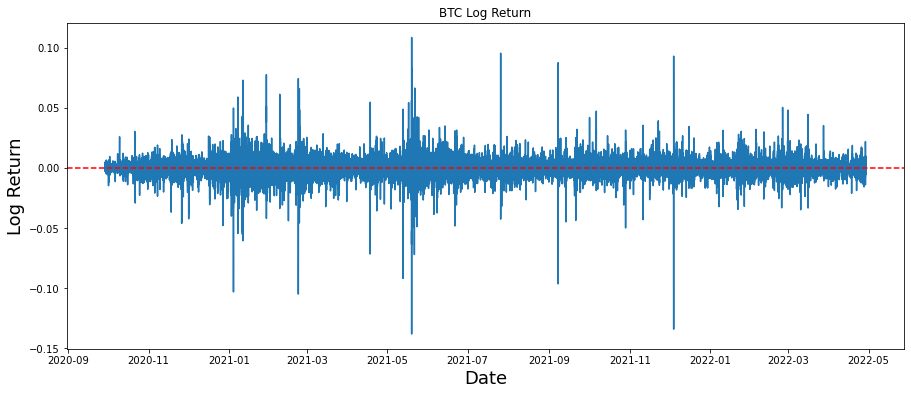

In [7]:
# log return of BTC price over 10 mins
def log_return(series, periods=10):
    return np.log(series).diff(periods=periods)


timerange = [20200901, 20220429]
btc_df_temp = btc_df.query(f"{timerange[0]} < index < {timerange[1]}")
lret_btf = log_return(btc_df_temp['Price'])[1:]

plt.figure(figsize=(15, 6))
plt.title('BTC Log Return')
plt.ylabel('Log Return', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.plot(lret_btf)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [57]:
lret_btf.describe()

count    871189.000000
mean          0.000014
std           0.003644
min          -0.138217
25%          -0.001476
50%           0.000008
75%           0.001502
max           0.108513
Name: Price, dtype: float64

for higher volatility of crypto market compared with stock market, we also applied the log return of BTC price to identify the volatility and determine available models. The log return of BTC price over 10 minuetes from September 2020 to April 2022 shows that Large price rises and falls usually occur at the same time range, and the largest increase is 10.8% and the largest fall is -13.82%.

In [79]:
print(btc_df.shape)
print(eth_df.shape)
print(f'time range of the dataset is between {min(btc_df.index)} and {max(btc_df.index)}')
print(f'time range of the dataset is between {min(eth_df.index)} and {max(eth_df.index)}')

(830879, 1)
(830879, 1)
time range of the dataset is between 2020-09-29 00:01:00 and 2022-04-28 23:59:00
time range of the dataset is between 2020-09-29 00:01:00 and 2022-04-28 23:59:00


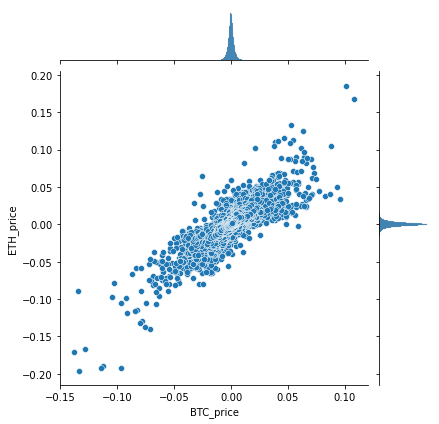

In [21]:
# campare daily return of BTC and ETH to check how they correlated
timerange = [20200901, 20220429]
btc_df_temp = btc_df.query(f"{timerange[0]} < index < {timerange[1]}")
lret_btc = log_return(btc_df_temp['Price'])[1:].rename("BTC_price")

eth_df_temp = eth_df.query(f"{timerange[0]} < index < {timerange[1]}")
lret_eth = log_return(eth_df_temp['Price'])[1:].rename("ETH_price")

merge_df = pd.concat([lret_btc, lret_eth], axis=1)
sns.jointplot(data=merge_df,
              x="BTC_price",
              y="ETH_price",
              kind='scatter',
              color='seagreen')

In [14]:
# load daily data to help optimize the parameters in Optuna
btc_df_op = pd.read_csv('BTCData_daily.csv')
eth_df_op = pd.read_csv('ETHData_daily.csv')

btc_df_op = btc_df_op.replace(',','', regex=True)
btc_df_op = btc_df_op[['Price', 'Date']]
btc_df_op['Date']= pd.to_datetime(btc_df_op['Date'])
btc_df_op = btc_df_op.set_index("Date")
btc_df_op['Price'] = pd.to_numeric(btc_df_op['Price'],errors='coerce')

eth_df_op = eth_df_op.replace(',','', regex=True)
eth_df_op = eth_df_op[['Price', 'Date']]
eth_df_op['Date']= pd.to_datetime(eth_df_op['Date'])
eth_df_op = eth_df_op.set_index("Date")
eth_df_op['Price'] = pd.to_numeric(eth_df_op['Price'],errors='coerce')

btc_df_op, eth_df_op = btc_df_op.iloc[::-1], eth_df_op.iloc[::-1]

# Tuning and Training

**Note:** All neural network models need to slice the train data first, in our case the train data was sliced into 10 minutes window.

In [ ]:
def data_transform(train_data, test_data, time_step):
    x_train = []
    y_train = []
    for i in range(time_step, len(train_data)):
        x_train.append(train_data[i-time_step:i, 0])
        y_train.append(train_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_test = []
    y_test = []
    for i in range(time_step, len(test_data)):
        # we need -time_step to get the values for predicting front rows in test set
        x_test.append(test_data[i-time_step:i, 0])
        y_test.append(test_data[i, 0])
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # reshape the date, LSTM expects the data to be 3-dimensional,  
    # (number of sample, number of time steps, number of features)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, x_test, y_train, y_test

def get_rmse(predictions, y_test):
    return np.sqrt(np.mean((predictions - y_test)**2))

def get_mae(predictions, y_test):
    return np.mean(np.abs(predictions - y_test))

## LSTM

<img src="pics/lstm.png" width=400 height=400 />

### BTC

In [104]:
def objective(trial):
    clear_session()
    global x_train, y_train, x_test, y_test
    
    time_step = 10
    n_layers = trial.suggest_int("n_layers", 1, 2) # search the best number of layers
    model = Sequential()
    

#   Optuna, an automatic hyperparameter optimization framework, 
#   was also introduced to obtain the best models for cryptocurrency data.

    
    for i in range(n_layers):
        model.add(
            LSTM(
                units=trial.suggest_categorical("unit_cnt1", [20, 30, 40, 50]), # search the best units from these 4 numbers
                dropout=trial.suggest_categorical("dropout1", [0, 0.05, 0.1, 0.2]),
                # activation=trial.suggest_categorical("activation1", ['sigmoid', 'tanh']),
                return_sequences=True
            )
        )
    model.add(
        LSTM(
            units=trial.suggest_categorical("unit_cnt2", [20, 30, 40, 50]),
            dropout=trial.suggest_categorical("dropout2", [0, 0.05, 0.1, 0.2]),
            # activation=trial.suggest_categorical("activation2", ['sigmoid', 'tanh']),
            return_sequences=False
        )
    )    
    
    model.add(Dense(25))
    model.add(Dense(1))

    adam = optimizers.Adam(
        learning_rate=trial.suggest_float("adam_lr", 1e-5, 1e-1, log=True) # search the best lr from 1e-5 ~ 1e-1
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    all_rmse = []
    fold = 0
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = btc_df_op.copy()
    dataset['Price'] = scaler.fit_transform(dataset) 
    

#     5-fold time series CV

#     For the different volatility in different periods, 5-fold time series cross validation was used to 
#     ensure that the models are applicable to the whole period.

    
    tss = TimeSeriesSplit(n_splits=5)
    for train_idx, test_idx in tss.split(btc_df_op):
        train_data = np.array(dataset.iloc[train_idx])
        test_data = np.array(dataset.iloc[test_idx])

        x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step)
        
        # If there is no loss reduction for 3 epoches, stop training
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 3) 
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=0)

        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
        all_rmse.append(get_rmse(predictions, y_test))
        fold += 1
    return np.mean(all_rmse)


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-24 00:33:12,477] A new study created in memory with name: no-name-1104fd72-0c88-4b1f-b45a-b95299b1978f


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:33:20,239] Trial 0 finished with value: 2617.838491148069 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 4.4974688599529014e-05}. Best is trial 0 with value: 2617.838491148069.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:33:29,628] Trial 1 finished with value: 6600.334626391496 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 1.9291135860531984e-05}. Best is trial 0 with value: 2617.838491148069.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:33:36,832] Trial 2 finished with value: 2080.854364018911 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00013052155947700886}. Best is trial 2 with value: 2080.854364018911.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:33:41,982] Trial 3 finished with value: 9026.02480807194 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.06905096297946359}. Best is trial 2 with value: 2080.854364018911.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:33:47,214] Trial 4 finished with value: 5875.525854219755 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.08841982319968913}. Best is trial 2 with value: 2080.854364018911.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:33:54,634] Trial 5 finished with value: 2970.5957734542653 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.2, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0012207646472988428}. Best is trial 2 with value: 2080.854364018911.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:34:00,575] Trial 6 finished with value: 4441.12083590397 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 3.859478278608359e-05}. Best is trial 2 with value: 2080.854364018911.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:34:05,354] Trial 7 finished with value: 7304.5874399393115 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 0.0336356031803185}. Best is trial 2 with value: 2080.854364018911.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:34:11,691] Trial 8 finished with value: 1738.3175725925425 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 0.00021439731792865962}. Best is trial 8 with value: 1738.3175725925425.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 00:34:18,607] Trial 9 finished with value: 2107.7483992757507 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.00027932409077256753}. Best is trial 8 with value: 1738.3175725925425.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:34:26,185] Trial 10 finished with value: 2720.0413843716474 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.0032958375025198333}. Best is trial 8 with value: 1738.3175725925425.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 00:34:33,023] Trial 11 finished with value: 1958.48127741081 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00020835570600167096}. Best is trial 8 with value: 1738.3175725925425.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:34:39,234] Trial 12 finished with value: 2469.8987637473174 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.0005756115764493453}. Best is trial 8 with value: 1738.3175725925425.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 00:34:45,435] Trial 13 finished with value: 5107.340711004559 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 0.0035344851470030273}. Best is trial 8 with value: 1738.3175725925425.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:34:51,892] Trial 14 finished with value: 1304.347436795869 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00015632867790524112}. Best is trial 14 with value: 1304.347436795869.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:35:02,409] Trial 15 finished with value: 9518.838528031116 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 1.0833822116668376e-05}. Best is trial 14 with value: 1304.347436795869.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:35:09,972] Trial 16 finished with value: 2370.0566625033525 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 8.293159280019956e-05}. Best is trial 14 with value: 1304.347436795869.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:35:15,249] Trial 17 finished with value: 2029.3583536748927 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.0013347550717427083}. Best is trial 14 with value: 1304.347436795869.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:35:21,032] Trial 18 finished with value: 2389.7418319977196 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 0.0004728351663409672}. Best is trial 14 with value: 1304.347436795869.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:35:28,227] Trial 19 finished with value: 2850.254550362125 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.006191961076325254}. Best is trial 14 with value: 1304.347436795869.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:35:36,401] Trial 20 finished with value: 1544.5987238465664 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 8.340067849652647e-05}. Best is trial 14 with value: 1304.347436795869.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:35:42,081] Trial 21 finished with value: 1899.0594224450106 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 7.387692013099221e-05}. Best is trial 14 with value: 1304.347436795869.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:35:47,928] Trial 22 finished with value: 1385.3227158496513 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 0.00017302450291473942}. Best is trial 14 with value: 1304.347436795869.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:35:55,471] Trial 23 finished with value: 6156.071990594824 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 2.9142956524693744e-05}. Best is trial 14 with value: 1304.347436795869.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:36:00,884] Trial 24 finished with value: 2353.3332151958157 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 8.548371837174925e-05}. Best is trial 14 with value: 1304.347436795869.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:36:05,158] Trial 25 finished with value: 1122.62500393978 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.000520939133749801}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:36:09,340] Trial 26 finished with value: 1250.2706970057673 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00043744763117115895}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:36:13,571] Trial 27 finished with value: 1606.9549279942328 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0005447020256390176}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:36:17,848] Trial 28 finished with value: 1979.560095392972 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.0025087742323808364}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:36:22,628] Trial 29 finished with value: 3091.077624752716 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.011709282289986564}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:36:27,176] Trial 30 finished with value: 2651.124580120038 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0003847324649964417}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:36:31,845] Trial 31 finished with value: 1227.6317520285677 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00015658921559064993}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:36:36,175] Trial 32 finished with value: 1672.2926878520655 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0008015306244707693}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:36:40,555] Trial 33 finished with value: 1563.5473625268237 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0016587580913565052}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:36:45,261] Trial 34 finished with value: 1996.2093972974787 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00012872632213629506}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:36:49,617] Trial 35 finished with value: 1893.9466261232567 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.0003264781912606509}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:36:54,063] Trial 36 finished with value: 1501.823464072559 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0008377699860655094}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:36:59,993] Trial 37 finished with value: 2742.0971693099514 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 4.625170961100969e-05}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:37:04,930] Trial 38 finished with value: 1510.009001642972 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00014869167418546253}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:37:14,733] Trial 39 finished with value: 6590.650908161212 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 1.774642163976456e-05}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:37:19,276] Trial 40 finished with value: 1632.7598900214593 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.0002976601768383628}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:37:23,845] Trial 41 finished with value: 1282.2853342945277 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00017864125595946253}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:37:28,380] Trial 42 finished with value: 1509.322814763278 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0001308380602790196}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:37:32,446] Trial 43 finished with value: 2103.392925328594 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0007567127751808394}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:37:37,919] Trial 44 finished with value: 2836.018450828192 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 5.344298451144028e-05}. Best is trial 25 with value: 1122.62500393978.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:37:42,950] Trial 45 finished with value: 1095.4655307805792 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00018310021613094588}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:37:47,413] Trial 46 finished with value: 1754.4077895319206 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0002757292490405915}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:37:52,810] Trial 47 finished with value: 1279.9146445815452 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.0002267095015987776}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:37:57,679] Trial 48 finished with value: 1874.9149829835035 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.0004975793738885056}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:38:02,394] Trial 49 finished with value: 1559.8852429251608 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.0019036173020083515}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:38:06,801] Trial 50 finished with value: 2223.7467801938037 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.2, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.00025524864475817797}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:38:13,615] Trial 51 finished with value: 1568.1023995775215 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00010682761421844752}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:38:19,376] Trial 52 finished with value: 1359.7034839391094 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00021344606983086364}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:38:24,249] Trial 53 finished with value: 1099.563519648605 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.0010806149674006385}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:38:29,116] Trial 54 finished with value: 1592.5155966671139 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.0011865229927175136}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:38:34,585] Trial 55 finished with value: 1839.4869194273065 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.0006188698694676465}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:38:39,052] Trial 56 finished with value: 2059.5665675295068 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.00040178883520106666}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:38:43,752] Trial 57 finished with value: 2541.0746028366416 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.004278418543570947}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:38:48,905] Trial 58 finished with value: 1551.8858492321622 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.0009426180304260919}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:38:55,442] Trial 59 finished with value: 2544.4283526689915 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 5.950944848584603e-05}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:39:05,391] Trial 60 finished with value: 2896.2691700476125 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 2.8768245594242154e-05}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:39:09,966] Trial 61 finished with value: 1532.0702214659334 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00020493924514839958}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:39:16,738] Trial 62 finished with value: 1486.6983273538092 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00010365185995334355}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:39:20,910] Trial 63 finished with value: 1598.4588801803918 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0003834966693957059}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:39:25,689] Trial 64 finished with value: 1479.8328935588788 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.000630627528841236}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:39:30,921] Trial 65 finished with value: 1296.1053481256708 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00019092160062280606}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:39:35,422] Trial 66 finished with value: 1528.5166316557138 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0004517088584079611}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:39:39,814] Trial 67 finished with value: 1928.0225122384659 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0014526614244102004}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:39:44,634] Trial 68 finished with value: 1235.2457627246513 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00016097781490962733}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:39:50,427] Trial 69 finished with value: 2310.762190601529 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 6.609963427942181e-05}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:39:54,921] Trial 70 finished with value: 2536.8411190651823 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0024216644742236873}. Best is trial 45 with value: 1095.4655307805792.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:39:59,856] Trial 71 finished with value: 867.5540046606759 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00016303082709393548}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:40:05,170] Trial 72 finished with value: 1404.9775979077253 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00010476196935314691}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:40:10,040] Trial 73 finished with value: 1413.6799636199032 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00030983084074366087}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:40:15,452] Trial 74 finished with value: 1488.4731708523336 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.000144304079058632}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:40:20,509] Trial 75 finished with value: 885.862150784603 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.000233730384191072}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:40:26,023] Trial 76 finished with value: 7819.1369220966135 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.03549919810333899}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 00:40:32,785] Trial 77 finished with value: 2397.001299624463 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 3.6981057641829946e-05}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 00:40:37,795] Trial 78 finished with value: 2139.120307554319 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.001099115592615843}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:40:46,662] Trial 79 finished with value: 1596.7678014350856 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.0003437430150271253}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:40:51,589] Trial 80 finished with value: 1602.3678693334227 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.0006748652002918699}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:40:56,478] Trial 81 finished with value: 1739.2161052340393 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0002519268311955225}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:41:01,404] Trial 82 finished with value: 1669.817181967543 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.00024307458969599673}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:41:06,558] Trial 83 finished with value: 1574.2861287050696 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 9.232676939069041e-05}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:41:11,752] Trial 84 finished with value: 1102.9739877280044 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00015017098962778958}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:41:17,021] Trial 85 finished with value: 1671.547186745574 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.00015804735410396406}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:41:21,884] Trial 86 finished with value: 1668.4494334260994 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00017850964947244846}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:41:28,743] Trial 87 finished with value: 2925.507942345091 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0001384860476472328}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:41:34,245] Trial 88 finished with value: 1474.237740661883 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00011814352556719313}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:41:39,813] Trial 89 finished with value: 1445.610919561427 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 8.412577133643641e-05}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:41:44,321] Trial 90 finished with value: 2036.957389099383 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.000543439191719823}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:41:50,264] Trial 91 finished with value: 1522.928145453326 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00022837911258329885}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:41:55,230] Trial 92 finished with value: 1550.336557554319 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00041795935504826724}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:41:59,750] Trial 93 finished with value: 1531.7702650549893 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00030333898453934117}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:42:04,022] Trial 94 finished with value: 2168.3821816322425 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0009545375603805522}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:42:09,558] Trial 95 finished with value: 940.6323185186426 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00015849788590180342}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:42:15,019] Trial 96 finished with value: 1521.777236956813 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 7.535686840616209e-05}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:42:19,678] Trial 97 finished with value: 1451.913614957752 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 0.00015888747129903048}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-24 00:42:24,765] Trial 98 finished with value: 1468.3505400013414 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0003570047764746047}. Best is trial 71 with value: 867.5540046606759.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-24 00:42:32,520] Trial 99 finished with value: 1512.4572220359441 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00011730998925299376}. Best is trial 71 with value: 867.5540046606759.


Number of finished trials: 100
Best trial:
  Value: 867.5540046606759
  Params: 
    n_layers: 1
    unit_cnt1: 50
    dropout1: 0
    unit_cnt2: 20
    dropout2: 0.1
    adam_lr: 0.00016303082709393548


------------------------round1--------------------------------
Epoch 1/50
541/541 [==============================] - 6s 7ms/step - loss: 0.0018
Epoch 2/50
541/541 [==============================] - 3s 6ms/step - loss: 1.8042e-05
Epoch 3/50
541/541 [==============================] - 3s 6ms/step - loss: 1.4325e-05
Epoch 4/50
541/541 [==============================] - 3s 6ms/step - loss: 1.2315e-05
Epoch 5/50
541/541 [==============================] - 3s 6ms/step - loss: 1.0834e-05
Epoch 6/50
541/541 [==============================] - 3s 6ms/step - loss: 9.4078e-06
Epoch 7/50
541/541 [==============================] - 3s 6ms/step - loss: 8.2503e-06
Epoch 8/50
541/541 [==============================] - 3s 6ms/step - loss: 7.1778e-06
Epoch 9/50
541/541 [==============================] - 3s 6ms/step - loss: 6.3940e-06
Epoch 10/50
541/541 [==============================] - 3s 6ms/step - loss: 5.6752e-06
Epoch 11/50
541/541 [==============================] - 3s 6ms/step - loss: 5.1439e-06
Epoc

2164/2164 [==============================] - 15s 7ms/step - loss: 1.1075e-05
Epoch 43/50
2164/2164 [==============================] - 15s 7ms/step - loss: 1.0930e-05
Epoch 44/50
2164/2164 [==============================] - 15s 7ms/step - loss: 1.0835e-05
Epoch 45/50
2164/2164 [==============================] - 15s 7ms/step - loss: 1.0688e-05
Epoch 46/50
2164/2164 [==============================] - 14s 7ms/step - loss: 1.0527e-05
Epoch 47/50
2164/2164 [==============================] - 15s 7ms/step - loss: 1.0364e-05
Epoch 48/50
2164/2164 [==============================] - 15s 7ms/step - loss: 1.0257e-05
Epoch 49/50
2164/2164 [==============================] - 15s 7ms/step - loss: 1.0117e-05
Epoch 50/50
4328/4328 [==============================] - 10s 2ms/step
------------------------round5--------------------------------
Epoch 1/50
2705/2705 [==============================] - 21s 7ms/step - loss: 0.0070
Epoch 2/50
2705/2705 [==============================] - 18s 7ms/step - loss: 1.8098

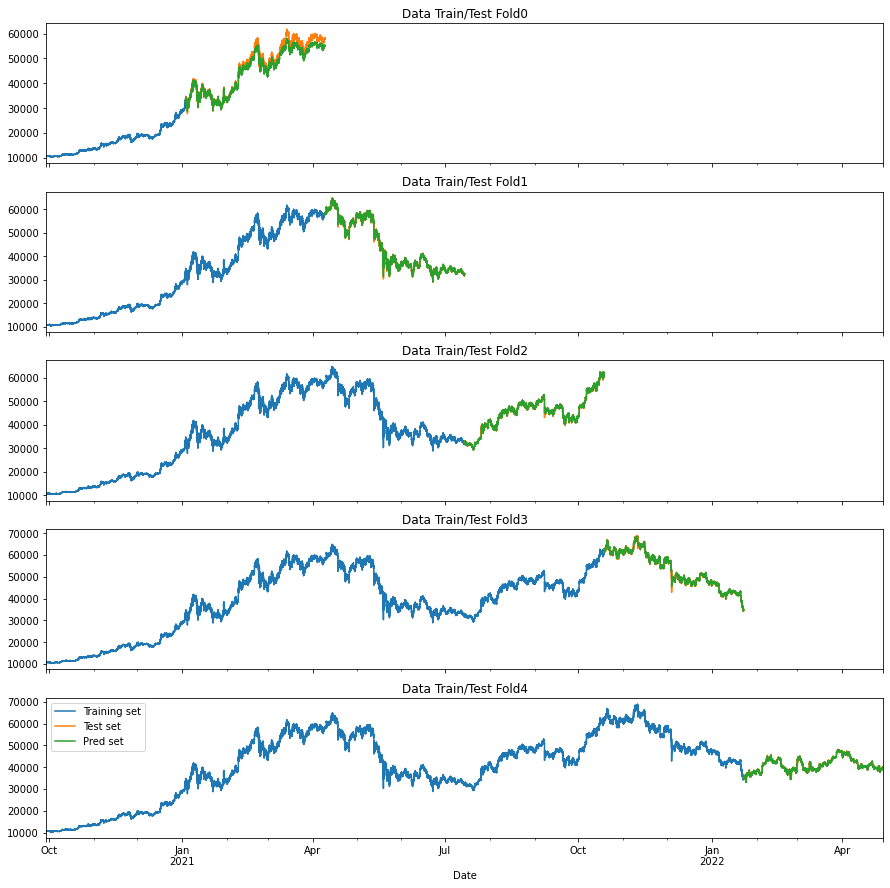

In [30]:
%%time
Best_trial = {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0001}
tss = TimeSeriesSplit(n_splits=5)
time_step = 10
rmse, mae = [], []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
scaler = MinMaxScaler(feature_range=(0,1))
dataset = btc_df.copy()
# use Minmax-scale on dataset
dataset['Price'] = scaler.fit_transform(dataset) 


for train_idx, test_idx in tss.split(btc_df):
    print(f'------------------------round{fold+1}--------------------------------')
    train_data = np.array(dataset.iloc[train_idx])
    test_data = np.array(dataset.iloc[test_idx])
    
    x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step)  

    try:
        model=load_model('LSTM_BTC_Model_fold{}_model.hdf5'.format(i+1))
    except:
        model = Sequential()
        for i in range(Best_trial['n_layers']):
            model.add(
                LSTM(
                    units=Best_trial['unit_cnt1'],
                    dropout=Best_trial['dropout1'],
                    activation='tanh',
                    return_sequences=True, 
                    input_shape = (x_train.shape[1], 1))
                )
        model.add(
            LSTM(
                units=Best_trial['unit_cnt2'],
                dropout=Best_trial['dropout2'],
                activation='tanh',
                return_sequences=False
            )
        )

        model.add(Dense(25))
        model.add(Dense(1))

        adam = optimizers.Adam(
            learning_rate=Best_trial['adam_lr']
        )
        model.compile(
            optimizer=adam, 
            loss='mean_squared_error'
        ) 

        # train the mode
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=1)
        # save each fold's model and prevent retrain every time 
        model.save(os.path.join(output_directory, 'LSTM_BTC_Model_fold{}_model.hdf5'.format(fold+1)))

    predictions = model.predict(x_test)
    # inverse the transform of minmax-scale in the true value and prediction results
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


#     The trained models are evaluated on the basis of the following metrics, root-mean-square error(RMSE), 
#     mean absolute error(MAE) are used to evaluate the preformance of the models. 
#     MAE and RMSE measure the degree of deviation of the predicted value from the true value. 
#     Generally, the smaller the MAE and RMSE, the higher the accuracy of the prediction. 
#     The greater difference between them, the greater the variance in the individual errors in the sample, 
#     while if they are the same, then all the errors are of the same magnitude.

    
    rmse.append(get_rmse(predictions, y_test))
    mae.append(get_mae(predictions, y_test))
    
    train = btc_df.iloc[train_idx]
    valid = btc_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
    
cv_rmse = np.mean(rmse)
cv_mae = np.mean(mae)
print('rmse:', rmse)
print('mae:', mae)
print('cv_rmse:', cv_rmse)
print('cv_mae:', cv_mae)
plt.legend()
plt.show()

### ETH

In [37]:
def objective(trial):
    clear_session()
    global x_train, y_train, x_test, y_test
    
    time_step = 10
    n_layers = trial.suggest_int("n_layers", 1, 2)
    model = Sequential()
    for i in range(n_layers):
        model.add(
            LSTM(
                units=trial.suggest_categorical("unit_cnt1", [20, 30, 40, 50]),
                dropout=trial.suggest_categorical("dropout1", [0, 0.05, 0.1, 0.2]),
                # activation=trial.suggest_categorical("activation1", ['sigmoid', 'tanh']),
                return_sequences=True,
            )
        )
    model.add(
        LSTM(
            units=trial.suggest_categorical("unit_cnt2", [20, 30, 40, 50]),
            dropout=trial.suggest_categorical("dropout2", [0, 0.05, 0.1, 0.2]),
            # activation=trial.suggest_categorical("activation2", ['sigmoid', 'tanh']),
            return_sequences=False
        )
    )    
    
    model.add(Dense(25))
    model.add(Dense(1))

    # We compile our model with a sampled learning rate.
    adam = optimizers.Adam(
        learning_rate=trial.suggest_float("adam_lr", 1e-5, 1e-1, log=True) 
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    all_rmse = []
    fold = 0
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = eth_df_op.copy()
    dataset['Price'] = scaler.fit_transform(dataset) 
    
    # 5-fold time series CV
    tss = TimeSeriesSplit(n_splits=5)
    for train_idx, test_idx in tss.split(eth_df_op):
        train_data = np.array(dataset.iloc[train_idx])
        test_data = np.array(dataset.iloc[test_idx])

        x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step) 
        
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=0)

        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
        all_rmse.append(get_rmse(predictions, y_test))
        fold += 1
    return np.mean(all_rmse)


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-27 22:00:13,045] A new study created in memory with name: no-name-d2948124-720b-4996-a748-1c822a125f35


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:00:58,079] Trial 0 finished with value: 117.0397912566222 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0016996836617107973}. Best is trial 0 with value: 117.0397912566222.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:01:05,749] Trial 1 finished with value: 127.32892297939581 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.013665821773382816}. Best is trial 0 with value: 117.0397912566222.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:01:12,024] Trial 2 finished with value: 2992.774290351311 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.1, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.09960297110258168}. Best is trial 0 with value: 117.0397912566222.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:01:17,317] Trial 3 finished with value: 183.98566987898013 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 0.0054813675655480286}. Best is trial 0 with value: 117.0397912566222.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:01:24,593] Trial 4 finished with value: 196.72906390459443 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 2.7167614983171463e-05}. Best is trial 0 with value: 117.0397912566222.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:01:31,620] Trial 5 finished with value: 88.81277131528405 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 0.017593322031715385}. Best is trial 5 with value: 88.81277131528405.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:01:36,845] Trial 6 finished with value: 79.85029655623538 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.012268373131086448}. Best is trial 6 with value: 79.85029655623538.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:01:43,973] Trial 7 finished with value: 227.41627324863157 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0019602952843638735}. Best is trial 6 with value: 79.85029655623538.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:01:51,415] Trial 8 finished with value: 70.63456507552641 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.00018592881924594598}. Best is trial 8 with value: 70.63456507552641.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:01:56,855] Trial 9 finished with value: 55.13495395434467 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.000727181670513527}. Best is trial 9 with value: 55.13495395434467.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:02:01,496] Trial 10 finished with value: 105.95276974814745 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0002245334587788678}. Best is trial 9 with value: 55.13495395434467.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:02:06,404] Trial 11 finished with value: 68.09802294188405 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.0002638186571587056}. Best is trial 9 with value: 55.13495395434467.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:02:11,771] Trial 12 finished with value: 86.91180645411413 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.00019579104430758143}. Best is trial 9 with value: 55.13495395434467.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:02:20,720] Trial 13 finished with value: 566.098141350611 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 1.613128509275528e-05}. Best is trial 9 with value: 55.13495395434467.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:02:26,060] Trial 14 finished with value: 59.41908465497586 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.00043748365424699134}. Best is trial 9 with value: 55.13495395434467.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 22:02:30,502] Trial 15 finished with value: 40.35094757525398 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0007655316442145743}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:02:38,209] Trial 16 finished with value: 108.25682239660173 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 7.456982421302275e-05}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:02:46,706] Trial 17 finished with value: 49.98051426336591 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0007748094023906191}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:02:51,540] Trial 18 finished with value: 167.99304106434832 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.004546225842646772}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:02:59,002] Trial 19 finished with value: 134.47713452986687 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.2, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 5.398495596562357e-05}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:03:03,778] Trial 20 finished with value: 99.84625812474852 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.001097418923965902}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:03:09,014] Trial 21 finished with value: 69.57643691505791 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0006198046750265001}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 22:03:14,040] Trial 22 finished with value: 52.660656399051526 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0031424080848252633}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:03:19,933] Trial 23 finished with value: 104.96043227821971 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.00469258110703553}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:03:24,941] Trial 24 finished with value: 68.29387415834353 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0024637897717532183}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:03:30,610] Trial 25 finished with value: 198.35760583312725 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.032097238742561596}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:03:35,049] Trial 26 finished with value: 63.144063697913154 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0011757014661930288}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:03:40,561] Trial 27 finished with value: 50.10286764827613 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0032758551481897806}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:03:46,000] Trial 28 finished with value: 133.22077019870738 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 8.17139031904472e-05}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:03:52,391] Trial 29 finished with value: 60.78854420752791 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0004485963734109168}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:03:56,944] Trial 30 finished with value: 177.54826101750058 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 0.0012775905376536648}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:04:02,203] Trial 31 finished with value: 95.54014899677063 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.002757046767360911}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:04:07,017] Trial 32 finished with value: 132.0365375523383 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.006655966047085691}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:04:12,745] Trial 33 finished with value: 68.4175687009623 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0031719224624498}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 22:04:18,263] Trial 34 finished with value: 222.3444864056632 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.009272210321515744}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:04:27,135] Trial 35 finished with value: 120.10504060625723 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.03285682389609715}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:04:35,315] Trial 36 finished with value: 59.68365910529271 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.0016915481310484837}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:04:39,796] Trial 37 finished with value: 90.83688149565995 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.000646602116314176}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:04:46,992] Trial 38 finished with value: 70.06897826179208 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.017790109309260737}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:04:51,809] Trial 39 finished with value: 1328.1122577433441 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.07730066642122682}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:04:56,641] Trial 40 finished with value: 201.02696372311308 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.2, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0036533061233729952}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:05:02,161] Trial 41 finished with value: 54.47022498999337 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0006927882838264569}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:05:06,858] Trial 42 finished with value: 61.87677613824017 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.00037011279803190534}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:05:11,460] Trial 43 finished with value: 48.43692218436703 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.000845678699749623}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:05:17,134] Trial 44 finished with value: 51.04216347441447 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.001985076393934194}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:05:21,542] Trial 45 finished with value: 51.50276849993922 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0018859495234788404}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:05:26,896] Trial 46 finished with value: 62.124396251760324 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.00012026763449512386}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:05:31,427] Trial 47 finished with value: 100.32490330197575 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.000893895912979172}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:05:37,641] Trial 48 finished with value: 73.18774088140003 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0015473753317642716}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:05:43,035] Trial 49 finished with value: 84.71275158953358 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.0003249736858511208}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:05:48,446] Trial 50 finished with value: 155.42979721711123 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.006528467559727949}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:05:53,193] Trial 51 finished with value: 60.89750112247058 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0021133745072569286}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:05:58,923] Trial 52 finished with value: 70.67204511807813 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0009373070143974762}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:06:03,680] Trial 53 finished with value: 41.55454823453846 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.001626687142695837}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:06:08,937] Trial 54 finished with value: 49.6583041201088 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0013962665505921799}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:06:13,544] Trial 55 finished with value: 41.405754405795236 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0005249279531122098}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:06:21,366] Trial 56 finished with value: 61.02709411778265 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.0005300525432791354}. Best is trial 15 with value: 40.35094757525398.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:06:27,565] Trial 57 finished with value: 39.899099406099104 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.00017620776737147523}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:06:35,343] Trial 58 finished with value: 66.78082792958271 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.00015402077914463539}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:06:40,244] Trial 59 finished with value: 102.5609418767184 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.00028124976547067954}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:06:46,812] Trial 60 finished with value: 214.97262556424775 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.1, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 4.232192514115382e-05}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:06:52,101] Trial 61 finished with value: 76.9373251547097 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.000777183168203503}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:06:59,560] Trial 62 finished with value: 56.94308683495255 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.00021735574582081293}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 22:07:06,348] Trial 63 finished with value: 60.832623916036574 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0004799522745043075}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:07:10,738] Trial 64 finished with value: 43.07499233917105 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0012992054166463295}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:07:15,081] Trial 65 finished with value: 51.6781010063728 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0013044291274812827}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:07:22,788] Trial 66 finished with value: 69.74078620825507 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.000118217977838867}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:07:28,323] Trial 67 finished with value: 44.71234730785189 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.001078721372352074}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:07:37,288] Trial 68 finished with value: 659.1276737568737 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.2, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 1.4209206199496221e-05}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:07:42,044] Trial 69 finished with value: 75.85878423155427 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0009808524087050485}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 22:07:46,778] Trial 70 finished with value: 48.671644713045694 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.00037290747099443124}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 22:07:52,037] Trial 71 finished with value: 64.3937809657805 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0003670704077983705}. Best is trial 57 with value: 39.899099406099104.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:07:58,182] Trial 72 finished with value: 39.56907093437751 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.00017110065102058346}. Best is trial 72 with value: 39.56907093437751.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:08:05,604] Trial 73 finished with value: 64.81719006923953 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 7.790426835678874e-05}. Best is trial 72 with value: 39.56907093437751.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 22:08:12,103] Trial 74 finished with value: 55.392879321184274 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.00014979714526403533}. Best is trial 72 with value: 39.56907093437751.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:08:16,885] Trial 75 finished with value: 43.1215949803954 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0006023860876063809}. Best is trial 72 with value: 39.56907093437751.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:08:24,743] Trial 76 finished with value: 84.69555575286472 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0005295176038263958}. Best is trial 72 with value: 39.56907093437751.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:08:29,530] Trial 77 finished with value: 49.26018046393005 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.1, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0002562694544484241}. Best is trial 72 with value: 39.56907093437751.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 22:08:34,630] Trial 78 finished with value: 107.17741573690651 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0023132685835989828}. Best is trial 72 with value: 39.56907093437751.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:08:39,352] Trial 79 finished with value: 48.714141657882486 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0006228335003810941}. Best is trial 72 with value: 39.56907093437751.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:08:46,013] Trial 80 finished with value: 71.49083820601695 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0002897685047645026}. Best is trial 72 with value: 39.56907093437751.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 22:08:50,364] Trial 81 finished with value: 71.6863633949378 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.0012009573959715796}. Best is trial 72 with value: 39.56907093437751.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:08:55,824] Trial 82 finished with value: 47.864280689681536 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0008117881413926259}. Best is trial 72 with value: 39.56907093437751.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 22:09:04,681] Trial 83 finished with value: 201.40465698451746 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 2.7879947058994157e-05}. Best is trial 72 with value: 39.56907093437751.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:09:10,979] Trial 84 finished with value: 35.19553766419242 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.00017231856247705918}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 22:09:16,356] Trial 85 finished with value: 79.37773150870524 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 9.709095764294425e-05}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:09:21,582] Trial 86 finished with value: 67.88223650572944 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0001863045651204849}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:09:26,231] Trial 87 finished with value: 135.8090574825434 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00042852022926822484}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 22:09:33,801] Trial 88 finished with value: 125.78132279739052 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 5.9574573158983175e-05}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:09:41,450] Trial 89 finished with value: 216.28788770212327 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.004226556976534406}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:09:49,210] Trial 90 finished with value: 70.8592021652025 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.00014481532452330446}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:09:53,798] Trial 91 finished with value: 48.2355995412671 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.001027145615658439}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:09:59,734] Trial 92 finished with value: 105.24878271431983 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0007324096462338195}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:10:04,682] Trial 93 finished with value: 54.6492950772134 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0016762443243334927}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:10:12,131] Trial 94 finished with value: 57.21723139894673 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.00023094956152283364}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:10:17,140] Trial 95 finished with value: 73.21127003158111 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0027899986726187776}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 22:10:25,928] Trial 96 finished with value: 86.89692653489008 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0006121145250382261}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:10:32,218] Trial 97 finished with value: 44.50175332523722 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0005386551407960113}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:10:38,122] Trial 98 finished with value: 62.461534088789655 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.0004275438300868476}. Best is trial 84 with value: 35.19553766419242.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 22:10:45,563] Trial 99 finished with value: 90.86083338869282 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.00010940470403094816}. Best is trial 84 with value: 35.19553766419242.


Number of finished trials: 100
Best trial:
  Value: 35.19553766419242
  Params: 
    n_layers: 1
    unit_cnt1: 50
    dropout1: 0
    unit_cnt2: 30
    dropout2: 0
    adam_lr: 0.00017231856247705918


------------------------round1--------------------------------
Epoch 1/50
541/541 [==============================] - 6s 8ms/step - loss: 1.1540e-04
Epoch 2/50
541/541 [==============================] - 4s 8ms/step - loss: 9.1654e-08
Epoch 3/50
541/541 [==============================] - 4s 8ms/step - loss: 9.1673e-08
Epoch 4/50
541/541 [==============================] - 4s 7ms/step - loss: 9.1779e-08
Epoch 5/50
4328/4328 [==============================] - 12s 3ms/step
------------------------round2--------------------------------
Epoch 1/50
1082/1082 [==============================] - 10s 8ms/step - loss: 0.0011
Epoch 2/50
1082/1082 [==============================] - 8s 8ms/step - loss: 2.7325e-06
Epoch 3/50
1082/1082 [==============================] - 8s 8ms/step - loss: 1.0140e-06
Epoch 4/50
1082/1082 [==============================] - 9s 8ms/step - loss: 9.1100e-07
Epoch 5/50
1082/1082 [==============================] - 9s 8ms/step - loss: 9.1292e-07
Epoch 6/50
1082/1082 [===========

Epoch 27/50
2164/2164 [==============================] - 17s 8ms/step - loss: 1.7826e-06
Epoch 28/50
2164/2164 [==============================] - 17s 8ms/step - loss: 1.7641e-06
Epoch 29/50
2164/2164 [==============================] - 17s 8ms/step - loss: 1.7060e-06
Epoch 30/50
2164/2164 [==============================] - 17s 8ms/step - loss: 1.6687e-06
Epoch 31/50
2164/2164 [==============================] - 17s 8ms/step - loss: 1.6449e-06
Epoch 32/50
2164/2164 [==============================] - 17s 8ms/step - loss: 1.6100e-06
Epoch 33/50
2164/2164 [==============================] - 17s 8ms/step - loss: 1.5707e-06
Epoch 34/50
2164/2164 [==============================] - 17s 8ms/step - loss: 1.5288e-06
Epoch 35/50
2164/2164 [==============================] - 17s 8ms/step - loss: 1.5080e-06
Epoch 36/50
2164/2164 [==============================] - 17s 8ms/step - loss: 1.4937e-06
Epoch 37/50
2164/2164 [==============================] - 18s 8ms/step - loss: 1.4579e-06
Epoch 38/50
2164/2164

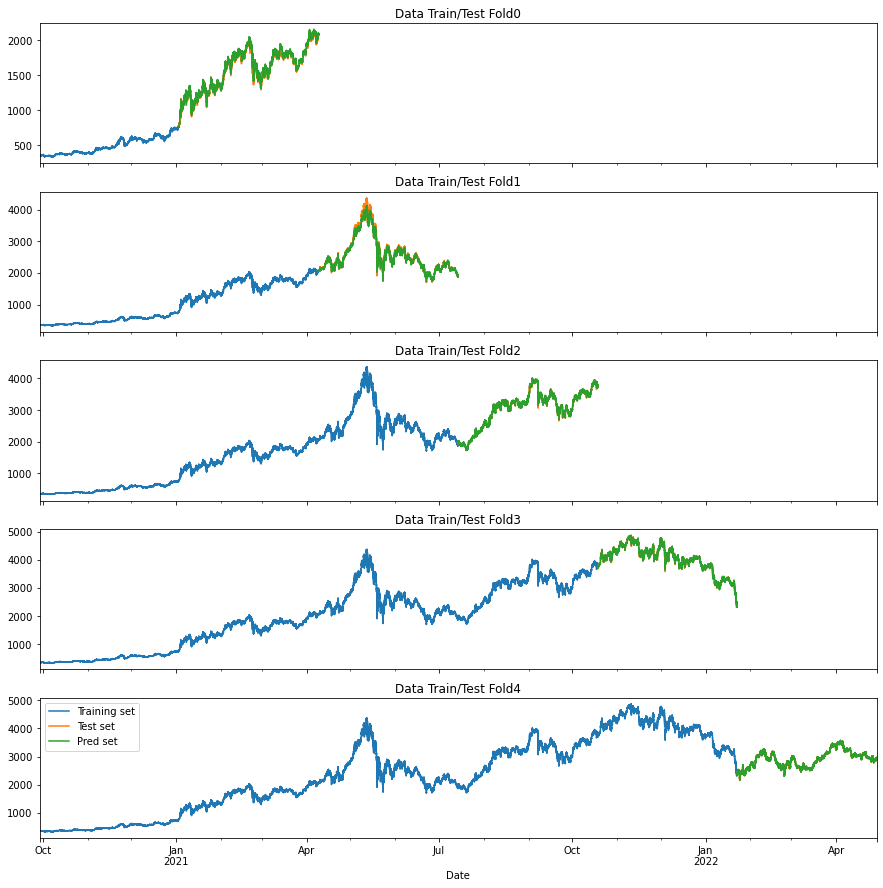

In [41]:
%%time
Best_trial = {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.00017}
tss = TimeSeriesSplit(n_splits=5)
time_step = 10
rmse, mae = [], []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
scaler = MinMaxScaler(feature_range=(0,1))
dataset = eth_df.copy()
dataset['Price'] = scaler.fit_transform(dataset) 


for train_idx, test_idx in tss.split(eth_df):
    print(f'------------------------round{fold+1}--------------------------------')
    train_data = np.array(dataset.iloc[train_idx])
    test_data = np.array(dataset.iloc[test_idx])
    
    x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step)    

    try:
        model=load_model('LSTM_ETH_Model_fold{}_model.hdf5'.format(i+1))
    except:
        model = Sequential()
        for i in range(Best_trial['n_layers']):
            model.add(
                LSTM(
                    units=Best_trial['unit_cnt1'],
                    dropout=Best_trial['dropout1'],
                    activation='tanh',
                    return_sequences=True, 
                    input_shape = (x_train.shape[1], 1))
                )
        model.add(
            LSTM(
                units=Best_trial['unit_cnt2'],
                dropout=Best_trial['dropout2'],
                activation='tanh',
                return_sequences=False
            )
        )

        model.add(Dense(25))
        model.add(Dense(1))

        adam = optimizers.Adam(
            learning_rate=Best_trial['adam_lr']
        )
        model.compile(
            optimizer=adam, 
            loss='mean_squared_error'
        ) 

        # train the mode
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=1)    
        model.save(os.path.join(output_directory, 'LSTM_ETH_Model_fold{}_model.hdf5'.format(fold+1)))
        
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse.append(get_rmse(predictions, y_test))
    mae.append(get_mae(predictions, y_test))
    
    train = eth_df.iloc[train_idx]
    valid = eth_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
    
cv_rmse = np.mean(rmse)
cv_mae = np.mean(mae)
print('rmse:', rmse)
print('mae:', mae)
print('cv_rmse=', cv_rmse)
print('cv_mae=', cv_mae)
plt.legend()
plt.show()

## BiLSTM

<img src="pics/BiLSTM.png" width=500 height=500 />

### BTC

In [113]:
def objective(trial):
    clear_session()
    global x_train, y_train, x_test, y_test
    
    time_step = 10
    n_layers = trial.suggest_int("n_layers", 1, 2)
    model = Sequential()
    for i in range(n_layers):
        model.add(
            Bidirectional(
                LSTM(
                    units=trial.suggest_categorical("unit_cnt1", [20, 30, 40, 50]),
                    dropout=trial.suggest_categorical("dropout1", [0, 0.05, 0.1, 0.2]),
                    # activation=trial.suggest_categorical("activation1", ['sigmoid', 'tanh']),
                    return_sequences=True
                )
            )
        )  
        
    model.add(
        Bidirectional(
            LSTM(
                units=trial.suggest_categorical("unit_cnt2", [20, 30, 40, 50]),
                dropout=trial.suggest_categorical("dropout2", [0, 0.05, 0.1, 0.2]),
                # activation=trial.suggest_categorical("activation2", ['sigmoid', 'tanh']),
                return_sequences=False
            )
        )
    )    
    
    model.add(Dense(32))
    model.add(Dense(1))

    # We compile our model with a sampled learning rate.
    adam = optimizers.Adam(
        learning_rate=trial.suggest_float("adam_lr", 1e-5, 1e-1, log=True) 
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    all_rmse = []
    fold = 0
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = btc_df_op.copy()
    dataset['Price'] = scaler.fit_transform(dataset) 
    
    # 5-fold time series CV
    tss = TimeSeriesSplit(n_splits=5)
    for train_idx, test_idx in tss.split(btc_df_op):
        train_data = np.array(dataset.iloc[train_idx])
        test_data = np.array(dataset.iloc[test_idx])

        x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step)
        
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=0)

    #     Evaluate the model accuracy on the validation set.
    #     score = model.evaluate(x_test, y_test, verbose=0)
    #     return score
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
        all_rmse.append(get_rmse(predictions, y_test))
        fold += 1
    return np.mean(all_rmse)


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-24 17:42:06,385] A new study created in memory with name: no-name-2e03d6d1-0672-4b51-83d1-52aceeb8a7a7


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:42:20,179] Trial 0 finished with value: 3162.3159983570285 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.003909558840431026}. Best is trial 0 with value: 3162.3159983570285.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:42:29,799] Trial 1 finished with value: 2331.1725126575916 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.006762986481014187}. Best is trial 1 with value: 2331.1725126575916.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:42:42,988] Trial 2 finished with value: 2115.0074642905047 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0010815728962736992}. Best is trial 2 with value: 2115.0074642905047.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:42:56,318] Trial 3 finished with value: 2737.0553303547476 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0032972280712395283}. Best is trial 2 with value: 2115.0074642905047.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-24 17:43:08,766] Trial 4 finished with value: 2258.520952420869 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.2, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0001601581941622565}. Best is trial 2 with value: 2115.0074642905047.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:43:21,913] Trial 5 finished with value: 6762.5687545265555 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 1.1111176648517189e-05}. Best is trial 2 with value: 2115.0074642905047.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:43:34,577] Trial 6 finished with value: 1439.6922450040233 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.015517356575145805}. Best is trial 6 with value: 1439.6922450040233.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:43:47,161] Trial 7 finished with value: 2946.7714551200374 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.0014166645781114253}. Best is trial 6 with value: 1439.6922450040233.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:43:59,990] Trial 8 finished with value: 1590.327781400885 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 5.5150269982530844e-05}. Best is trial 6 with value: 1439.6922450040233.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:44:12,320] Trial 9 finished with value: 1327.305560873793 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00014002656312632345}. Best is trial 9 with value: 1327.305560873793.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:44:22,642] Trial 10 finished with value: 19185.082896828062 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.06981958971352811}. Best is trial 9 with value: 1327.305560873793.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:44:37,156] Trial 11 finished with value: 27930.510704969154 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.06930607758407656}. Best is trial 9 with value: 1327.305560873793.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:44:49,634] Trial 12 finished with value: 1454.976924959764 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 0.00019974308386297082}. Best is trial 9 with value: 1327.305560873793.


8/8 [==============================] - 0s 8ms/step


[I 2022-11-24 17:45:02,950] Trial 13 finished with value: 4779.119204835032 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.017939284345136124}. Best is trial 9 with value: 1327.305560873793.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-24 17:45:15,552] Trial 14 finished with value: 2116.4701020151556 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0002596936970491302}. Best is trial 9 with value: 1327.305560873793.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:45:34,101] Trial 15 finished with value: 1633.545164213385 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 3.4330685593821e-05}. Best is trial 9 with value: 1327.305560873793.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:45:47,955] Trial 16 finished with value: 1165.4344577353809 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 0.017425195329789703}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:45:56,603] Trial 17 finished with value: 1887.6579130063037 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.2, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 0.0005012990154550427}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:46:11,163] Trial 18 finished with value: 1344.792036530982 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 8.241588566987811e-05}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 8ms/step


[I 2022-11-24 17:46:29,258] Trial 19 finished with value: 4094.251188723846 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 1.6251024225890853e-05}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:46:38,160] Trial 20 finished with value: 1796.4547310052305 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.0005469889452407549}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:46:57,223] Trial 21 finished with value: 1465.4420169997315 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 5.5664777260324795e-05}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:47:10,253] Trial 22 finished with value: 1335.0237687768238 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 0.00010876492936180372}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-24 17:47:27,147] Trial 23 finished with value: 1510.6360708657455 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 0.000104046582908122}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:47:42,748] Trial 24 finished with value: 3208.5918740779243 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 2.390679543394318e-05}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:47:56,137] Trial 25 finished with value: 1556.8989221767704 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0003902528201692336}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 8ms/step


[I 2022-11-24 17:48:08,616] Trial 26 finished with value: 3135.9467516932673 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.2, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 0.0015806715379526144}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 8ms/step


[I 2022-11-24 17:48:23,222] Trial 27 finished with value: 31712.73469655311 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 0.03439883157667633}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-24 17:48:36,782] Trial 28 finished with value: 1297.849259991953 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00013595896116061796}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-24 17:48:51,222] Trial 29 finished with value: 2119.054295533798 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.005051672736652033}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 12ms/step


[I 2022-11-24 17:49:08,499] Trial 30 finished with value: 2422.946545232028 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0030837894420426572}. Best is trial 16 with value: 1165.4344577353809.


8/8 [==============================] - 0s 8ms/step


[I 2022-11-24 17:49:21,738] Trial 31 finished with value: 874.4381513210835 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.00012409190887744943}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:49:33,315] Trial 32 finished with value: 1955.2123435823498 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.0003099893071278086}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:49:46,917] Trial 33 finished with value: 2320.6664403668183 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.0006386490342603206}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:50:01,291] Trial 34 finished with value: 1810.6215697927844 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 3.7157892635922626e-05}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:50:13,361] Trial 35 finished with value: 1723.577656166175 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00017555038935781266}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:50:25,801] Trial 36 finished with value: 2042.7805597840663 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0009221370621033017}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-24 17:50:42,783] Trial 37 finished with value: 1595.086917918455 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 7.297444620219991e-05}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:50:51,652] Trial 38 finished with value: 1026.454843079399 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00012903586732532669}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:51:00,206] Trial 39 finished with value: 1947.4543687131172 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.009934828103111658}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:51:08,520] Trial 40 finished with value: 2158.1174348678915 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.00215635236390276}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:51:17,368] Trial 41 finished with value: 1548.7584335602198 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0001362071204558555}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:51:25,769] Trial 42 finished with value: 1237.1603824939646 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00021224690706444932}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:51:34,259] Trial 43 finished with value: 1690.1633895520386 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.000247786486944666}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:51:43,872] Trial 44 finished with value: 1798.5020768508584 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 4.015030347864827e-05}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:51:52,320] Trial 45 finished with value: 1087.0512771593346 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.0009536070386490893}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:52:00,428] Trial 46 finished with value: 1399.2909377514754 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.000839059664075429}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:52:08,874] Trial 47 finished with value: 2064.9968543790237 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.001731347097304262}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:52:21,146] Trial 48 finished with value: 13523.73770151556 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.0974130093332787}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:52:29,732] Trial 49 finished with value: 1601.801467861454 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0003635335811455114}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:52:38,092] Trial 50 finished with value: 2672.46886324772 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.2, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.007102816716213673}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:52:46,167] Trial 51 finished with value: 1160.0118173283263 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00020403200791156112}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:52:54,324] Trial 52 finished with value: 1567.9100704969155 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00022347072191742626}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:53:03,531] Trial 53 finished with value: 1609.6231286883046 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 7.305731283740332e-05}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:53:12,923] Trial 54 finished with value: 1807.767849383047 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.02295927003610348}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:53:21,143] Trial 55 finished with value: 1491.7091776756974 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0004591486055684505}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:53:29,632] Trial 56 finished with value: 2196.5151119065185 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0007610311083714657}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:53:39,289] Trial 57 finished with value: 1435.6633224081277 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00018138717905531325}. Best is trial 31 with value: 874.4381513210835.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:53:51,635] Trial 58 finished with value: 713.8995901790504 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0011226065986838537}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:54:00,212] Trial 59 finished with value: 1864.7911808442866 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 0.0023647030124818703}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:54:07,871] Trial 60 finished with value: 1653.7285541007245 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0013136444853746718}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:54:16,188] Trial 61 finished with value: 1462.2342032423553 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00010661862070650403}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:54:25,588] Trial 62 finished with value: 1875.434352451046 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 5.727556938752736e-05}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:54:34,557] Trial 63 finished with value: 28594.12970795333 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.04200928623565349}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:54:42,757] Trial 64 finished with value: 1776.1792076850859 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0003116379168213214}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:54:54,512] Trial 65 finished with value: 6299.182857681733 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 1.2966760177067996e-05}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:55:03,120] Trial 66 finished with value: 2067.9429070547208 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.011632698960032354}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:55:13,907] Trial 67 finished with value: 2562.652221700644 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 2.3463572756185753e-05}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:55:22,414] Trial 68 finished with value: 1239.8261455539164 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.00010362496535361632}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:55:36,027] Trial 69 finished with value: 1436.0263161380099 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.001123624255913085}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:55:44,005] Trial 70 finished with value: 2427.5506153601123 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 0.0038315739075954675}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:55:51,898] Trial 71 finished with value: 992.4527604446084 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.00010619900560050647}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:56:00,095] Trial 72 finished with value: 1259.758220225322 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.00015130018908233146}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:56:09,419] Trial 73 finished with value: 1671.1162797579132 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 4.66693376752819e-05}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:56:18,061] Trial 74 finished with value: 1352.3170362795065 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 8.710540654230558e-05}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:56:26,290] Trial 75 finished with value: 1483.4103052072155 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0002141210909676906}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:56:34,668] Trial 76 finished with value: 1228.933856206411 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0002831314961889557}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:56:42,533] Trial 77 finished with value: 1867.400250804721 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0006554942178572249}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:56:50,873] Trial 78 finished with value: 1277.0238178145119 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0002853465511752699}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:57:05,952] Trial 79 finished with value: 1609.8339541141363 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.00014711226002700448}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:57:14,159] Trial 80 finished with value: 1951.5812815182403 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00045593924236699435}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:57:23,131] Trial 81 finished with value: 1323.952671170869 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 6.254335660411191e-05}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:57:32,114] Trial 82 finished with value: 1167.8684135260194 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00011302997669927565}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:57:40,351] Trial 83 finished with value: 1247.4341209260997 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00011493841662792162}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:57:49,710] Trial 84 finished with value: 1774.667749044394 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 3.1561991772387446e-05}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:57:58,370] Trial 85 finished with value: 1500.817630599517 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 9.386302017905571e-05}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:58:14,751] Trial 86 finished with value: 1138.6977117422211 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00012297523532829143}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:58:30,776] Trial 87 finished with value: 1647.0790105284336 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 6.921267087582428e-05}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:58:48,203] Trial 88 finished with value: 3608.434587161347 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.005330708291909414}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:59:04,098] Trial 89 finished with value: 1489.0363862996244 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.0001273288133449887}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:59:17,480] Trial 90 finished with value: 1431.4871992355152 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00018297145104803183}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 17:59:29,839] Trial 91 finished with value: 1386.1354882812498 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 8.334429584681712e-05}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 17:59:41,676] Trial 92 finished with value: 1566.797545517033 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.00024841568785856756}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 17:59:49,990] Trial 93 finished with value: 1279.8861559482295 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0003729042686523942}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 18:00:03,058] Trial 94 finished with value: 1702.830303782189 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.00015870302841091948}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 18:00:13,394] Trial 95 finished with value: 1440.0919784401824 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 4.629445379412187e-05}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-24 18:00:25,458] Trial 96 finished with value: 1226.5898601797212 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00012179840020705965}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-24 18:00:39,441] Trial 97 finished with value: 2240.8897252212982 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 2.7533375042001275e-05}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 18:00:49,622] Trial 98 finished with value: 1748.258182252548 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 5.1801845644204415e-05}. Best is trial 58 with value: 713.8995901790504.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-24 18:00:58,539] Trial 99 finished with value: 1366.6299524711642 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 8.175366522095097e-05}. Best is trial 58 with value: 713.8995901790504.


Number of finished trials: 100
Best trial:
  Value: 713.8995901790504
  Params: 
    n_layers: 1
    unit_cnt1: 20
    dropout1: 0.05
    unit_cnt2: 50
    dropout2: 0.05
    adam_lr: 0.0011226065986838537


------------------------round1--------------------------------
Epoch 1/50
541/541 [==============================] - 11s 11ms/step - loss: 2.6264e-04
Epoch 2/50
541/541 [==============================] - 6s 11ms/step - loss: 5.7196e-05
Epoch 3/50
541/541 [==============================] - 6s 11ms/step - loss: 5.5877e-05
Epoch 4/50
541/541 [==============================] - 7s 13ms/step - loss: 5.3814e-05
Epoch 5/50
541/541 [==============================] - 6s 11ms/step - loss: 5.1661e-05
Epoch 6/50
541/541 [==============================] - 6s 11ms/step - loss: 4.7821e-05
Epoch 7/50
541/541 [==============================] - 6s 10ms/step - loss: 3.7246e-05
Epoch 8/50
541/541 [==============================] - 6s 11ms/step - loss: 2.2589e-05
Epoch 9/50
541/541 [==============================] - 6s 11ms/step - loss: 1.7728e-05
Epoch 10/50
541/541 [==============================] - 6s 11ms/step - loss: 1.3702e-05
Epoch 11/50
541/541 [==============================] - 6s 11ms/step - loss:

2164/2164 [==============================] - 25s 12ms/step - loss: 5.6514e-06
Epoch 36/50
2164/2164 [==============================] - 25s 11ms/step - loss: 5.5677e-06
Epoch 37/50
2164/2164 [==============================] - 29s 13ms/step - loss: 5.3998e-06
Epoch 38/50
2164/2164 [==============================] - 26s 12ms/step - loss: 5.2604e-06
Epoch 39/50
2164/2164 [==============================] - 26s 12ms/step - loss: 5.1849e-06
Epoch 40/50
2164/2164 [==============================] - 25s 11ms/step - loss: 5.1212e-06
Epoch 41/50
2164/2164 [==============================] - 26s 12ms/step - loss: 4.9532e-06
Epoch 42/50
2164/2164 [==============================] - 24s 11ms/step - loss: 4.8019e-06
Epoch 43/50
2164/2164 [==============================] - 25s 11ms/step - loss: 4.7868e-06
Epoch 44/50
2164/2164 [==============================] - 25s 11ms/step - loss: 4.7039e-06
Epoch 45/50
2164/2164 [==============================] - 25s 12ms/step - loss: 4.4999e-06
Epoch 46/50
2164/2164 

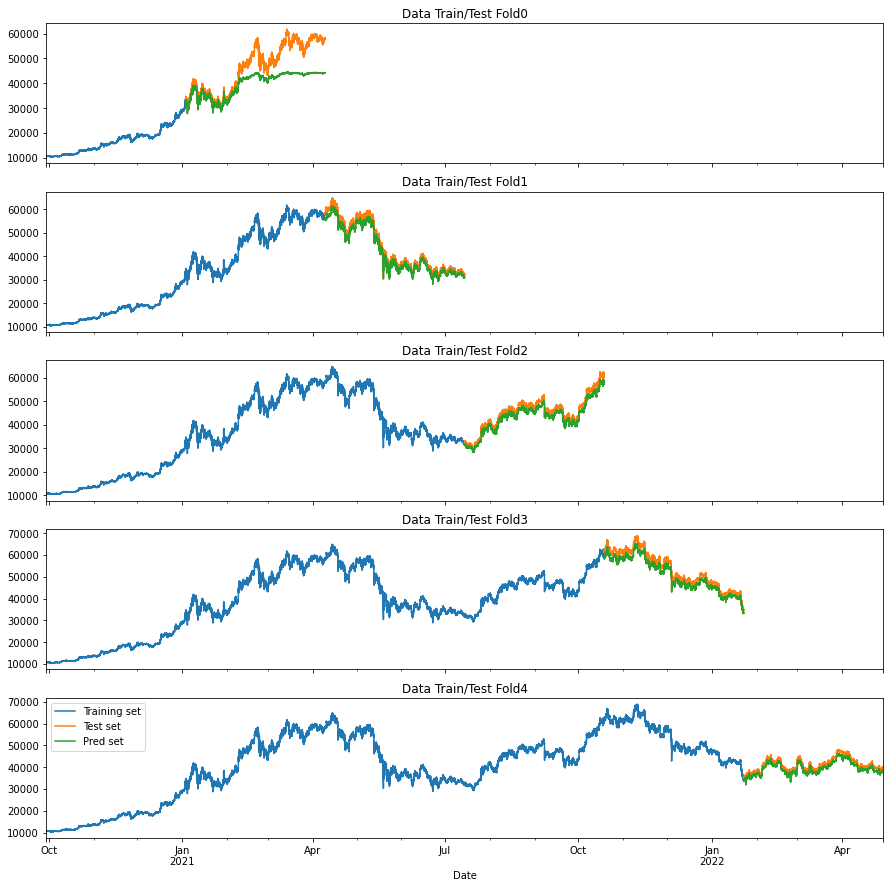

In [111]:
%%time
Best_trial = {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.001}
tss = TimeSeriesSplit(n_splits=5)
time_step = 10 
rmse, mae = [], []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
scaler = MinMaxScaler(feature_range=(0,1))
dataset = btc_df.copy()
dataset['Price'] = scaler.fit_transform(dataset) 

for train_idx, test_idx in tss.split(btc_df):
    print(f'------------------------round{fold+1}--------------------------------')
    train_data = np.array(dataset.iloc[train_idx])
    test_data = np.array(dataset.iloc[test_idx])
    
    x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step)   

    try:
        model=load_model('BILSTM_BTC_Model_fold{}_model.hdf5'.format(i+1))
    except:
        model = Sequential()
        for i in range(Best_trial['n_layers']):
            model.add(
                Bidirectional(
                    LSTM(
                        units=Best_trial['unit_cnt1'],
                        dropout=Best_trial['dropout1'],
                        activation='tanh',
                        return_sequences=True
                    )
                )
        )

        model.add(
            Bidirectional(
                LSTM(
                    units=Best_trial['unit_cnt2'],
                    dropout=Best_trial['dropout2'],
                    activation='tanh',
                    return_sequences=False
                )
            )
        )    

        model.add(Dense(32))
        model.add(Dense(1))

        adam = optimizers.Adam(
            learning_rate=Best_trial['adam_lr']
        )
        model.compile(
            optimizer=adam, 
            loss='mean_squared_error'
        ) 

        # train the mode
        early_stop = callbacks.EarlyStopping(monitor = 'loss',
                                                       patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=1)    
        model.save(os.path.join(output_directory, 'BILSTM_BTC_Model_fold{}_model.hdf5'.format(fold+1)))
        
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse.append(get_rmse(predictions, y_test))
    mae.append(get_mae(predictions, y_test))
    
    train = btc_df.iloc[train_idx]
    valid = btc_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
cv_mae = np.mean(mae)
print('rmse:', rmse)
print('mae:', mae)
print('cv_rmse=', cv_rmse)
print('cv_mae=', cv_mae)
plt.legend()
plt.show()

### ETH

In [35]:
def objective(trial):
    clear_session()
    global x_train, y_train, x_test, y_test
    
    time_step = 10
    n_layers = trial.suggest_int("n_layers", 1, 2)
    model = Sequential()
    for i in range(n_layers):
        model.add(
            Bidirectional(
                LSTM(
                    units=trial.suggest_categorical("unit_cnt1", [20, 30, 40, 50]),
                    dropout=trial.suggest_categorical("dropout1", [0, 0.05, 0.1, 0.2]),
                    # activation=trial.suggest_categorical("activation1", ['sigmoid', 'tanh']),
                    return_sequences=True
                )
            )
        )  
        
    model.add(
        Bidirectional(
            LSTM(
                units=trial.suggest_categorical("unit_cnt2", [20, 30, 40, 50]),
                dropout=trial.suggest_categorical("dropout2", [0, 0.05, 0.1, 0.2]),
                # activation=trial.suggest_categorical("activation2", ['sigmoid', 'tanh']),
                return_sequences=False
            )
        )
    )    
    
    model.add(Dense(32))
    model.add(Dense(1))

    # We compile our model with a sampled learning rate.
    adam = optimizers.Adam(
        learning_rate=trial.suggest_float("adam_lr", 1e-5, 1e-1, log=True) 
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    all_rmse = []
    fold = 0
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = eth_df_op.copy()
    dataset['Price'] = scaler.fit_transform(dataset) 
    
    # 5-fold time series CV
    tss = TimeSeriesSplit(n_splits=5)
    for train_idx, test_idx in tss.split(eth_df_op):
        train_data = np.array(dataset.iloc[train_idx])
        test_data = np.array(dataset.iloc[test_idx])

        x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step)
        
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=0)

    #     Evaluate the model accuracy on the validation set.
    #     score = model.evaluate(x_test, y_test, verbose=0)
    #     return score
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
        all_rmse.append(get_rmse(predictions, y_test))
        fold += 1
    return np.mean(all_rmse)


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-27 16:53:02,942] A new study created in memory with name: no-name-0a6851f7-a329-48ae-809b-51bc37550649


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 16:53:14,096] Trial 0 finished with value: 740.0089181290656 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 0.0569512065508629}. Best is trial 0 with value: 740.0089181290656.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 16:53:26,266] Trial 1 finished with value: 176.865367407017 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0018518482986147895}. Best is trial 1 with value: 176.865367407017.


8/8 [==============================] - 0s 8ms/step


[I 2022-11-27 16:53:38,626] Trial 2 finished with value: 2645.015872204432 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.03588727247947033}. Best is trial 1 with value: 176.865367407017.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 16:53:56,542] Trial 3 finished with value: 3551.4364583999572 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.03976429056602838}. Best is trial 1 with value: 176.865367407017.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 16:54:07,884] Trial 4 finished with value: 135.14949775715448 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 1.5860487815528966e-05}. Best is trial 4 with value: 135.14949775715448.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 16:54:16,434] Trial 5 finished with value: 16738.23026996295 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.0949382556957915}. Best is trial 4 with value: 135.14949775715448.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 16:54:25,594] Trial 6 finished with value: 76.65830228381505 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00020866852289103325}. Best is trial 6 with value: 76.65830228381505.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 16:54:33,388] Trial 7 finished with value: 92.71183405091116 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.2, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0010167531591453096}. Best is trial 6 with value: 76.65830228381505.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 16:54:42,288] Trial 8 finished with value: 203.10939614750288 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.010608917344450415}. Best is trial 6 with value: 76.65830228381505.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 16:54:51,419] Trial 9 finished with value: 170.6658109104664 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.035730783063784424}. Best is trial 6 with value: 76.65830228381505.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 16:55:04,277] Trial 10 finished with value: 101.94569533398017 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 6.11502346734803e-05}. Best is trial 6 with value: 76.65830228381505.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 16:55:12,812] Trial 11 finished with value: 92.27411063159073 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.2, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0003126266527626823}. Best is trial 6 with value: 76.65830228381505.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 16:55:24,426] Trial 12 finished with value: 80.62768885691892 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.00018628668929844075}. Best is trial 6 with value: 76.65830228381505.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 16:55:33,239] Trial 13 finished with value: 72.17468954795216 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0001467031971655738}. Best is trial 13 with value: 72.17468954795216.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 16:55:42,789] Trial 14 finished with value: 56.69633854760427 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 5.148240580043981e-05}. Best is trial 14 with value: 56.69633854760427.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 16:55:56,768] Trial 15 finished with value: 443.26849043241174 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 1.0487376768701344e-05}. Best is trial 14 with value: 56.69633854760427.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 16:56:07,453] Trial 16 finished with value: 137.7752281766572 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 4.245477901944347e-05}. Best is trial 14 with value: 56.69633854760427.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 16:56:20,670] Trial 17 finished with value: 79.80803507085318 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 6.730334617346818e-05}. Best is trial 14 with value: 56.69633854760427.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 16:56:28,581] Trial 18 finished with value: 214.485720432789 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.004214775909646206}. Best is trial 14 with value: 56.69633854760427.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 16:56:39,373] Trial 19 finished with value: 119.87462836714978 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 2.649377172048002e-05}. Best is trial 14 with value: 56.69633854760427.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 16:56:51,774] Trial 20 finished with value: 58.8436085537759 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0004402984500081849}. Best is trial 14 with value: 56.69633854760427.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 16:57:06,671] Trial 21 finished with value: 75.58969578532599 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0003420840325095137}. Best is trial 14 with value: 56.69633854760427.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 16:57:19,796] Trial 22 finished with value: 72.76472909506603 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00012532518936872022}. Best is trial 14 with value: 56.69633854760427.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 16:57:31,598] Trial 23 finished with value: 55.93174508025207 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0005903853376079659}. Best is trial 23 with value: 55.93174508025207.


8/8 [==============================] - 0s 8ms/step


[I 2022-11-27 16:57:43,814] Trial 24 finished with value: 113.27909653508918 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0006798756631156167}. Best is trial 23 with value: 55.93174508025207.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 16:57:55,568] Trial 25 finished with value: 95.63867715545784 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0026744479821159167}. Best is trial 23 with value: 55.93174508025207.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 16:58:08,210] Trial 26 finished with value: 74.91076950164924 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0006429961652861391}. Best is trial 23 with value: 55.93174508025207.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 16:58:22,849] Trial 27 finished with value: 42.92151266387808 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0004205483353551325}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 16:58:35,452] Trial 28 finished with value: 180.31039659596718 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.006486043345546809}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 16:58:47,970] Trial 29 finished with value: 112.94943994481164 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0016575147374001177}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 16:59:01,036] Trial 30 finished with value: 106.200764853809 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.1, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 7.257383650845518e-05}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 16:59:12,907] Trial 31 finished with value: 58.489567607306604 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.00045951043671895017}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 16:59:24,508] Trial 32 finished with value: 167.62082161859993 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0018008126091947835}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 16:59:37,668] Trial 33 finished with value: 65.26224702054134 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0009912104341194142}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 16:59:53,790] Trial 34 finished with value: 48.65204136611872 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.00010257937783674527}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:00:07,162] Trial 35 finished with value: 86.98309015966586 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0001029327140467495}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:00:26,696] Trial 36 finished with value: 143.65016194015305 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 1.7965413531921273e-05}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:00:39,755] Trial 37 finished with value: 48.31480903749916 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.00023184125625733392}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:00:52,049] Trial 38 finished with value: 48.97907358141723 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0002461443339945781}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:01:03,822] Trial 39 finished with value: 80.30449720679026 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00023668447392991932}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:01:20,209] Trial 40 finished with value: 65.70830444912232 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 3.776320524255983e-05}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:01:32,510] Trial 41 finished with value: 88.47949121381899 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0007265377288558421}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:01:44,122] Trial 42 finished with value: 50.016527871324264 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0002604812508361091}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:01:57,431] Trial 43 finished with value: 64.04552457961708 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 9.948414466203812e-05}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:02:09,603] Trial 44 finished with value: 92.6707757610272 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0002660135527569387}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:02:23,814] Trial 45 finished with value: 63.783376822672174 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00017504514009678758}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:02:36,307] Trial 46 finished with value: 67.91867823575393 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.001150897846728775}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:02:51,266] Trial 47 finished with value: 79.13118431071662 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.1, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.0003642820713879099}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:03:03,802] Trial 48 finished with value: 83.4958569862464 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.00017828149264051838}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:03:16,722] Trial 49 finished with value: 57.74405359305844 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 9.358154422407853e-05}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:03:30,238] Trial 50 finished with value: 347.84030299004155 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.018553369745541844}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:03:43,016] Trial 51 finished with value: 77.54001867806755 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.000510548724942381}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:03:55,566] Trial 52 finished with value: 51.151514558063546 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.00024745126527762386}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:04:08,428] Trial 53 finished with value: 75.3953034654871 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.00023565692420041368}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:04:23,932] Trial 54 finished with value: 57.07206804214936 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.0003101398145603856}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:04:36,698] Trial 55 finished with value: 61.77430519673752 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 0.00012177094755399086}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:04:47,894] Trial 56 finished with value: 67.6038507514921 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.0009491634816352359}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:05:00,562] Trial 57 finished with value: 61.7181000636023 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.1, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.00016520175381788042}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:05:14,320] Trial 58 finished with value: 76.87317689769563 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 4.569120298098407e-05}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:05:29,744] Trial 59 finished with value: 72.95906061865023 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 2.659605208349226e-05}. Best is trial 27 with value: 42.92151266387808.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:05:44,117] Trial 60 finished with value: 37.10692109097329 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0003218255574030209}. Best is trial 60 with value: 37.10692109097329.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:05:56,406] Trial 61 finished with value: 26.744588563321486 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.00038976984861537116}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:06:08,707] Trial 62 finished with value: 68.77616099947818 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0004482801642206364}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:06:22,853] Trial 63 finished with value: 54.43748232023705 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 7.319553212648616e-05}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:06:35,052] Trial 64 finished with value: 37.86485605735942 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0003611281259312613}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:06:47,729] Trial 65 finished with value: 72.55909651937199 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0003980541385388103}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:07:04,381] Trial 66 finished with value: 121.1315514549943 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0008497338698070011}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:07:16,572] Trial 67 finished with value: 134.01797650591806 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.2, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0013088711935318408}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:07:30,322] Trial 68 finished with value: 70.61000908664163 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.00013106077630479782}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 8ms/step


[I 2022-11-27 17:07:43,809] Trial 69 finished with value: 102.37509090885278 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.1, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.002609146577890895}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:07:57,319] Trial 70 finished with value: 61.03969420522272 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0005532364790891613}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:08:10,442] Trial 71 finished with value: 28.936116305764642 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0002979273971243065}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:08:23,298] Trial 72 finished with value: 51.3286777500922 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.00034154739861520713}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:08:39,014] Trial 73 finished with value: 89.03647474008979 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.00019755627045184456}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:08:52,510] Trial 74 finished with value: 69.54132640291795 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.00014635018399294605}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:09:04,222] Trial 75 finished with value: 37.02377139688254 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0003064746369858815}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:09:15,916] Trial 76 finished with value: 2213.9520008246295 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.08933977930903055}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 6ms/step


[I 2022-11-27 17:09:27,222] Trial 77 finished with value: 82.71937162996873 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0008080353988610432}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:09:39,696] Trial 78 finished with value: 84.73970597767318 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.2, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0005733312292324411}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-27 17:09:53,701] Trial 79 finished with value: 30.80885322590447 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.00030705531020025603}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:10:05,543] Trial 80 finished with value: 45.36109116399543 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.00031765910609397456}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:10:13,801] Trial 81 finished with value: 40.75831732570664 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.00029633705269216056}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:10:21,884] Trial 82 finished with value: 42.81434670928824 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0003086135125090768}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:10:30,109] Trial 83 finished with value: 32.572270524053614 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.00042866572118201016}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:10:38,773] Trial 84 finished with value: 78.83552228621454 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0006790462276412119}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:10:47,090] Trial 85 finished with value: 47.38046416791006 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0004453462207186005}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:10:55,702] Trial 86 finished with value: 51.842005496045545 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.00028923164884870955}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:11:04,069] Trial 87 finished with value: 80.23437997921135 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0013127796456275564}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:11:14,050] Trial 88 finished with value: 44.51551750373021 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0002007324181318912}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:11:25,475] Trial 89 finished with value: 78.70382766029455 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0003587332485089298}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:11:33,128] Trial 90 finished with value: 72.70010882254016 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0005184126172274623}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:11:42,236] Trial 91 finished with value: 59.30111581905511 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.00041490359302731356}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:11:50,884] Trial 92 finished with value: 30.32635950204742 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0002795910639927428}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:11:59,264] Trial 93 finished with value: 90.28918604013336 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.00029297160542460145}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:12:07,761] Trial 94 finished with value: 43.20072765065466 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.00020892703030684384}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 17:12:16,185] Trial 95 finished with value: 53.68185336526371 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0001506803144258459}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:12:24,909] Trial 96 finished with value: 42.09298201270369 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.0006355388894147307}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:12:33,735] Trial 97 finished with value: 56.862614695274786 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.0005998740652022829}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:12:42,087] Trial 98 finished with value: 96.73866408398018 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.0007299263016173207}. Best is trial 61 with value: 26.744588563321486.


8/8 [==============================] - 0s 5ms/step


[I 2022-11-27 17:12:54,054] Trial 99 finished with value: 100.82430877240225 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.00047878816364147164}. Best is trial 61 with value: 26.744588563321486.


Number of finished trials: 100
Best trial:
  Value: 26.744588563321486
  Params: 
    n_layers: 2
    unit_cnt1: 30
    dropout1: 0.05
    unit_cnt2: 50
    dropout2: 0.1
    adam_lr: 0.00038976984861537116


------------------------round1--------------------------------
Epoch 1/50
541/541 [==============================] - 17s 18ms/step - loss: 3.9152e-05
Epoch 2/50
541/541 [==============================] - 10s 18ms/step - loss: 6.3247e-06
Epoch 3/50
541/541 [==============================] - 10s 18ms/step - loss: 6.3634e-06
Epoch 4/50
541/541 [==============================] - 10s 19ms/step - loss: 6.1251e-06
Epoch 5/50
541/541 [==============================] - 10s 18ms/step - loss: 5.9698e-06
Epoch 6/50
541/541 [==============================] - 10s 18ms/step - loss: 6.0385e-06
Epoch 7/50
541/541 [==============================] - 10s 18ms/step - loss: 5.8430e-06
Epoch 8/50
541/541 [==============================] - 10s 18ms/step - loss: 5.8287e-06
Epoch 9/50
541/541 [==============================] - 10s 18ms/step - loss: 5.8197e-06
Epoch 10/50
541/541 [==============================] - 10s 18ms/step - loss: 5.6687e-06
Epoch 11/50
541/541 [==============================] - 10s 18ms/st

2705/2705 [==============================] - 52s 19ms/step - loss: 3.4040e-05
Epoch 6/50
2705/2705 [==============================] - 52s 19ms/step - loss: 2.8245e-05
Epoch 7/50
2705/2705 [==============================] - 51s 19ms/step - loss: 2.4196e-05
Epoch 8/50
2705/2705 [==============================] - 51s 19ms/step - loss: 2.1676e-05
Epoch 9/50
2705/2705 [==============================] - 52s 19ms/step - loss: 1.9545e-05
Epoch 10/50
2705/2705 [==============================] - 52s 19ms/step - loss: 1.8211e-05
Epoch 11/50
2705/2705 [==============================] - 51s 19ms/step - loss: 1.6981e-05
Epoch 12/50
2705/2705 [==============================] - 51s 19ms/step - loss: 1.5898e-05
Epoch 13/50
2705/2705 [==============================] - 52s 19ms/step - loss: 1.5434e-05
Epoch 14/50
2705/2705 [==============================] - 51s 19ms/step - loss: 1.4774e-05
Epoch 15/50
2705/2705 [==============================] - 51s 19ms/step - loss: 1.4173e-05
Epoch 16/50
2705/2705 [===

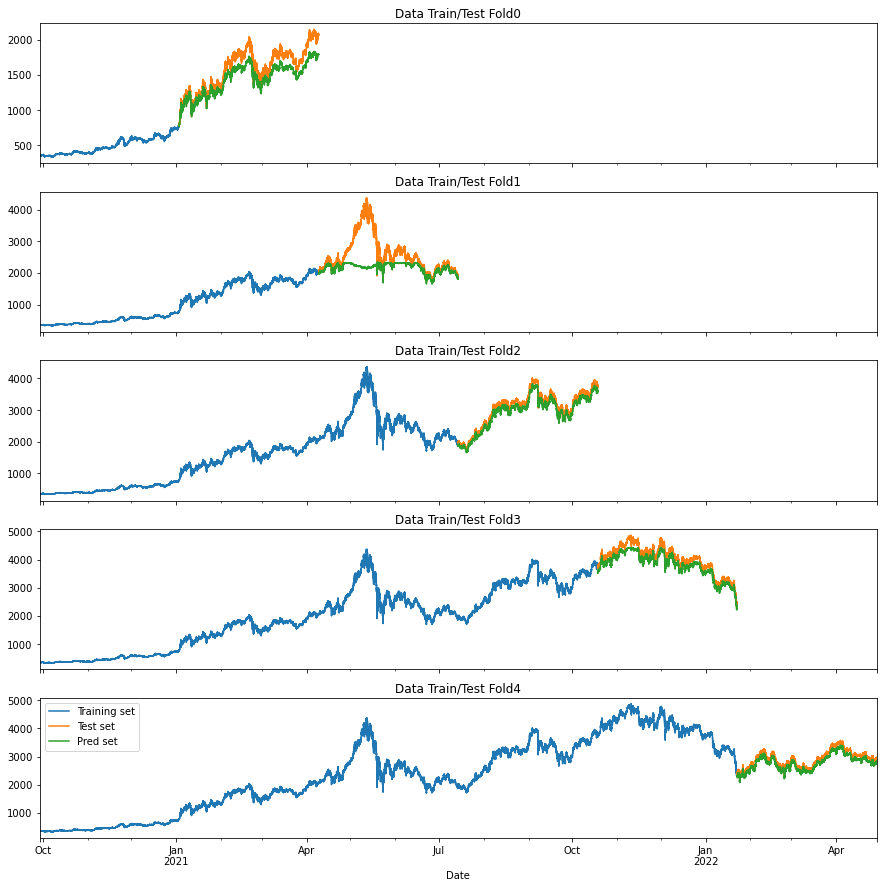

In [36]:
%%time
Best_trial = {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0004}
tss = TimeSeriesSplit(n_splits=5)
time_step = 10 
rmse, mae = [], []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
scaler = MinMaxScaler(feature_range=(0,1))
dataset = eth_df.copy()
dataset['Price'] = scaler.fit_transform(dataset) 

for train_idx, test_idx in tss.split(eth_df):
    print(f'------------------------round{fold+1}--------------------------------')
    train_data = np.array(dataset.iloc[train_idx])
    test_data = np.array(dataset.iloc[test_idx])
    
    x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step)   

    try:
        model=load_model('BILSTM_ETH_Model_fold{}_model.hdf5'.format(i+1))
    except:
        model = Sequential()
        for i in range(Best_trial['n_layers']):
            model.add(
                Bidirectional(
                    LSTM(
                        units=Best_trial['unit_cnt1'],
                        dropout=0.05,
                        activation='tanh',
                        return_sequences=True
                    )
                )
        )

        model.add(
            Bidirectional(
                LSTM(
                    units=Best_trial['unit_cnt2'],
                    dropout=0.1,
                    activation='tanh',
                    return_sequences=False
                )
            )
        )    

        model.add(Dense(32))
        model.add(Dense(1))

        adam = optimizers.Adam(
            learning_rate=Best_trial['adam_lr']
        )
        model.compile(
            optimizer=adam, 
            loss='mean_squared_error'
        ) 

        # train the mode
        early_stop = callbacks.EarlyStopping(monitor = 'loss',
                                                       patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=1)    
        model.save(os.path.join(output_directory, 'BILSTM_ETH_Model_fold{}_model.hdf5'.format(fold+1)))
        
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse.append(get_rmse(predictions, y_test))
    mae.append(get_mae(predictions, y_test))
    
    train = eth_df.iloc[train_idx]
    valid = eth_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
cv_mae = np.mean(mae)
print('rmse:', rmse)
print('mae:', mae)
print('cv_rmse=', cv_rmse)
print('cv_mae=', cv_mae)
plt.legend()
plt.show()

## GRU

<img src="pics/gru.png" width=500 height=500 />

### BTC

In [121]:
def objective(trial):
    clear_session()
    global x_train, y_train, x_test, y_test
    
    time_step = 10
    n_layers = trial.suggest_int("n_layers", 1, 2)
    model = Sequential()
    for i in range(n_layers):
        model.add(
            GRU(
                units=trial.suggest_categorical("unit_cnt1", [20, 30, 40, 50]),
                dropout=trial.suggest_categorical("dropout1", [0, 0.05, 0.1, 0.2]),
                # activation=trial.suggest_categorical("activation1", ['sigmoid', 'tanh']),
                return_sequences=True,
                #input_shape = (x_train.shape[1], 1)
            )
        )
    model.add(
        GRU(
            units=trial.suggest_categorical("unit_cnt2", [20, 30, 40, 50]),
            dropout=trial.suggest_categorical("dropout2", [0, 0.05, 0.1, 0.2]),
            # activation=trial.suggest_categorical("activation2", ['sigmoid', 'tanh']),
            return_sequences=False
        )
    )    
    
    model.add(Dense(1))

    # We compile our model with a sampled learning rate.
    adam = optimizers.Adam(
        learning_rate=trial.suggest_float("adam_lr", 1e-5, 1e-1, log=True) 
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    all_rmse = []
    fold = 0
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = btc_df_op.copy()
    dataset['Price'] = scaler.fit_transform(dataset) 
    
    # 5-fold time series CV
    tss = TimeSeriesSplit(n_splits=5)
    for train_idx, test_idx in tss.split(btc_df_op):
        train_data = np.array(dataset.iloc[train_idx])
        test_data = np.array(dataset.iloc[test_idx])

        x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step)
        
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=0)

    #     Evaluate the model accuracy on the validation set.
    #     score = model.evaluate(x_test, y_test, verbose=0)
    #     return score
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))   
        all_rmse.append(get_rmse(predictions, y_test))
        fold += 1
    return np.mean(all_rmse)


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-26 18:09:41,252] A new study created in memory with name: no-name-2c3710eb-bf46-463f-bc39-bc17a64f498b


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:09:46,622] Trial 0 finished with value: 2232.651256873659 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0003992493973433931}. Best is trial 0 with value: 2232.651256873659.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:09:51,876] Trial 1 finished with value: 2984.313407658262 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.03552518016280765}. Best is trial 0 with value: 2232.651256873659.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:09:58,716] Trial 2 finished with value: 1269.3759214055794 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00023991364919853886}. Best is trial 2 with value: 1269.3759214055794.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:10:05,338] Trial 3 finished with value: 3755.56630892905 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 3.64768725991847e-05}. Best is trial 2 with value: 1269.3759214055794.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:10:12,301] Trial 4 finished with value: 6319.064758583691 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 2.354345087204859e-05}. Best is trial 2 with value: 1269.3759214055794.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:10:20,151] Trial 5 finished with value: 1542.0661074973175 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 9.269081184000098e-05}. Best is trial 2 with value: 1269.3759214055794.


8/8 [==============================] - 0s 7ms/step


[I 2022-11-26 18:10:26,524] Trial 6 finished with value: 2190.834974936293 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.2, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0008607517476289894}. Best is trial 2 with value: 1269.3759214055794.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:10:33,210] Trial 7 finished with value: 13838.43038360465 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.022586910502872}. Best is trial 2 with value: 1269.3759214055794.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:10:37,628] Trial 8 finished with value: 1559.5080638914965 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.004455235663993046}. Best is trial 2 with value: 1269.3759214055794.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:10:47,282] Trial 9 finished with value: 11630.020346994032 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 1.0192188867578393e-05}. Best is trial 2 with value: 1269.3759214055794.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:10:54,521] Trial 10 finished with value: 1820.1969329231492 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 0.00023152934368937943}. Best is trial 2 with value: 1269.3759214055794.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:11:02,454] Trial 11 finished with value: 917.1987588854614 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00011036493738133032}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:11:13,722] Trial 12 finished with value: 2219.7716104898745 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.0038149896007991448}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:11:20,942] Trial 13 finished with value: 1073.4022885930794 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00015532757797946526}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:11:28,388] Trial 14 finished with value: 1372.8649540638412 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 4.9273218092138825e-05}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:11:35,067] Trial 15 finished with value: 1461.185488951851 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 0.0021157931630944836}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:11:41,307] Trial 16 finished with value: 1006.0686719588251 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.0001166074729273101}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:11:47,779] Trial 17 finished with value: 1190.7632949973176 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.0009796420379904595}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:11:58,707] Trial 18 finished with value: 4786.973965095225 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 1.032410099282664e-05}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:12:05,018] Trial 19 finished with value: 21217.24449914498 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 0.09271935886753412}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:12:12,580] Trial 20 finished with value: 2832.9096138177306 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.2, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 7.102968809372507e-05}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:12:19,175] Trial 21 finished with value: 1306.430831377414 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.00016494943821795211}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:12:25,404] Trial 22 finished with value: 1371.7189907457082 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.00042137288053019047}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:12:31,753] Trial 23 finished with value: 1026.4088956042115 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00011216603793353644}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:12:40,014] Trial 24 finished with value: 2259.782755582752 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 2.4137050133242243e-05}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:12:46,722] Trial 25 finished with value: 1069.7941222673016 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 9.575554692501944e-05}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:12:53,327] Trial 26 finished with value: 1697.9858175462716 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00047682603108267416}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:13:04,326] Trial 27 finished with value: 3460.268856960837 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 2.7179082039158106e-05}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:13:10,530] Trial 28 finished with value: 2527.5515814444743 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00010930931308287411}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:13:16,192] Trial 29 finished with value: 2267.5382434448766 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.1, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0006418995690134088}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:13:22,075] Trial 30 finished with value: 2020.3587598075378 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.0018270391768374073}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:13:28,763] Trial 31 finished with value: 1253.5863875570012 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 5.5716058599555424e-05}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:13:34,990] Trial 32 finished with value: 995.9116675328596 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.0002652316064325203}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:13:40,858] Trial 33 finished with value: 925.1998701549088 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.00027948262678199735}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:13:46,693] Trial 34 finished with value: 1176.2141772565717 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.00030303317042614046}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-26 18:13:52,447] Trial 35 finished with value: 1211.695193552173 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0002097550209374523}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:13:58,379] Trial 36 finished with value: 1923.9955944876608 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.00039158364752027387}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:14:04,037] Trial 37 finished with value: 2743.8049699067865 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 4.1117815801825e-05}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:14:10,492] Trial 38 finished with value: 1023.1583599617758 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.0018132309341679794}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:14:16,459] Trial 39 finished with value: 1282.9749020922748 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.0006424038758883184}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:14:21,165] Trial 40 finished with value: 2545.4397902695814 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.01131212068619473}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:14:27,959] Trial 41 finished with value: 1067.261416225188 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.0015049827930288572}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:14:37,535] Trial 42 finished with value: 1398.1928598611858 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.00698617851606254}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:14:44,004] Trial 43 finished with value: 1054.7450504627147 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.0002498806849909025}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:14:50,282] Trial 44 finished with value: 1661.1297222035942 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.0031669359192773136}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:14:56,511] Trial 45 finished with value: 1908.266628302709 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.0001502028362951229}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:15:02,395] Trial 46 finished with value: 1373.794399141631 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.0011844503036112673}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:15:10,182] Trial 47 finished with value: 3901.253191724786 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.1, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 6.362224700769007e-05}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:15:16,545] Trial 48 finished with value: 1520.50072642838 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.0007588224838352028}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:15:24,606] Trial 49 finished with value: 3346.6154903768775 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 1.7056488792213987e-05}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:15:30,931] Trial 50 finished with value: 1313.3023476897802 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0002995015376721211}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:15:36,996] Trial 51 finished with value: 1114.9871926971568 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00014336632720319287}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:15:43,526] Trial 52 finished with value: 925.7476117388682 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00010544901151560273}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:15:49,819] Trial 53 finished with value: 984.8183203125002 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 7.954338528881803e-05}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:15:56,483] Trial 54 finished with value: 1243.5905735313843 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 7.771537705767595e-05}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:16:03,629] Trial 55 finished with value: 1507.9314219252951 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 4.0246709155933196e-05}. Best is trial 11 with value: 917.1987588854614.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:16:09,639] Trial 56 finished with value: 739.9185800026823 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00019440073585631223}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:16:19,269] Trial 57 finished with value: 1154.614701582618 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00020361058309117626}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:16:26,608] Trial 58 finished with value: 2004.7403916309013 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 8.187548600884637e-05}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:16:32,704] Trial 59 finished with value: 1985.9455479647265 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.0003520088887326979}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:16:38,745] Trial 60 finished with value: 1545.4768168253756 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0005389520422855345}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:16:44,550] Trial 61 finished with value: 1045.392145084496 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.0001234099379848951}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:16:50,639] Trial 62 finished with value: 1265.1282613834496 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00017776576617420972}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:16:57,089] Trial 63 finished with value: 936.1902900348714 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00010286043670244469}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:17:04,384] Trial 64 finished with value: 1540.8788395252145 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 3.344561483729786e-05}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:17:10,660] Trial 65 finished with value: 2329.552845778567 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 5.933856117520144e-05}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:17:17,199] Trial 66 finished with value: 1041.1369774342813 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 9.376809651015648e-05}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:17:25,110] Trial 67 finished with value: 2600.7712669326716 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 2.0069159171841476e-05}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:17:31,626] Trial 68 finished with value: 1274.043002196218 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00022795503792204662}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:17:38,574] Trial 69 finished with value: 1828.6445283999462 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 4.7474027420726036e-05}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:17:43,662] Trial 70 finished with value: 970.7761789163089 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00028722786625016647}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:17:48,387] Trial 71 finished with value: 1333.1438165571353 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.0002963589928089707}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:17:58,360] Trial 72 finished with value: 1233.1591856390826 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00012846938106833637}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:18:04,241] Trial 73 finished with value: 1224.3294746680526 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00016323186568387082}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:18:09,097] Trial 74 finished with value: 1350.5066300630363 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0004254780335802617}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:18:15,977] Trial 75 finished with value: 1275.7323259790771 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00010256014349430482}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:18:23,124] Trial 76 finished with value: 1726.0135965162285 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.0002346235957205205}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:18:29,503] Trial 77 finished with value: 1903.843674054453 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 8.150154969909598e-05}. Best is trial 56 with value: 739.9185800026823.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:18:35,310] Trial 78 finished with value: 717.3386158798285 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.0001919800445732089}. Best is trial 78 with value: 717.3386158798285.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:18:41,435] Trial 79 finished with value: 1304.6159570312498 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.00018245162326096227}. Best is trial 78 with value: 717.3386158798285.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-26 18:18:47,855] Trial 80 finished with value: 4709.778802223043 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 3.075242657517703e-05}. Best is trial 78 with value: 717.3386158798285.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:18:54,036] Trial 81 finished with value: 1418.014351612795 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00035091420596668617}. Best is trial 78 with value: 717.3386158798285.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:18:59,958] Trial 82 finished with value: 1436.5261665940184 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.0005501494737465776}. Best is trial 78 with value: 717.3386158798285.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:19:06,522] Trial 83 finished with value: 1205.8445342677037 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 6.27178408545484e-05}. Best is trial 78 with value: 717.3386158798285.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:19:12,465] Trial 84 finished with value: 1178.902455572693 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00013582462125610395}. Best is trial 78 with value: 717.3386158798285.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:19:18,440] Trial 85 finished with value: 1315.3761841972907 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.0002707703593300925}. Best is trial 78 with value: 717.3386158798285.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:19:24,983] Trial 86 finished with value: 1703.9263907423551 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.0001096826304308281}. Best is trial 78 with value: 717.3386158798285.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:19:31,632] Trial 87 finished with value: 625.4758101696619 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0008631703229735847}. Best is trial 87 with value: 625.4758101696619.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:19:41,050] Trial 88 finished with value: 1005.6027581813303 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.0011711678162257628}. Best is trial 87 with value: 625.4758101696619.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:19:47,241] Trial 89 finished with value: 1175.1379144313305 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0007729938584653133}. Best is trial 87 with value: 625.4758101696619.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:19:53,123] Trial 90 finished with value: 1238.7650966503486 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0001997668914760036}. Best is trial 87 with value: 625.4758101696619.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:19:59,047] Trial 91 finished with value: 1624.2994508617219 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00047118607822317556}. Best is trial 87 with value: 625.4758101696619.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:20:05,560] Trial 92 finished with value: 1380.16652326985 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 4.885629150647012e-05}. Best is trial 87 with value: 625.4758101696619.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:20:11,700] Trial 93 finished with value: 1413.9625191959494 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.002686840970930067}. Best is trial 87 with value: 625.4758101696619.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:20:18,084] Trial 94 finished with value: 19023.51774661347 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.043462583798103825}. Best is trial 87 with value: 625.4758101696619.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:20:24,498] Trial 95 finished with value: 1402.7395683006973 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 0.0003440295555940316}. Best is trial 87 with value: 625.4758101696619.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:20:30,529] Trial 96 finished with value: 1053.437885930794 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00015024097226702568}. Best is trial 87 with value: 625.4758101696619.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-26 18:20:36,583] Trial 97 finished with value: 1698.596152930526 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 8.728660326338342e-05}. Best is trial 87 with value: 625.4758101696619.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:20:43,244] Trial 98 finished with value: 1760.1249144145654 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 6.770947363263066e-05}. Best is trial 87 with value: 625.4758101696619.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-26 18:20:49,219] Trial 99 finished with value: 1450.0597060253485 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.00026775916589863365}. Best is trial 87 with value: 625.4758101696619.


Number of finished trials: 100
Best trial:
  Value: 625.4758101696619
  Params: 
    n_layers: 2
    unit_cnt1: 50
    dropout1: 0
    unit_cnt2: 50
    dropout2: 0.05
    adam_lr: 0.0008631703229735847


------------------------round1--------------------------------
Epoch 1/50
541/541 [==============================] - 9s 10ms/step - loss: 1.5363e-04
Epoch 2/50
541/541 [==============================] - 5s 10ms/step - loss: 4.7857e-06
Epoch 3/50
541/541 [==============================] - 5s 10ms/step - loss: 3.4088e-06
Epoch 4/50
541/541 [==============================] - 5s 9ms/step - loss: 2.9749e-06
Epoch 5/50
541/541 [==============================] - 5s 9ms/step - loss: 2.9680e-06
Epoch 6/50
541/541 [==============================] - 5s 9ms/step - loss: 3.3563e-06
Epoch 7/50
541/541 [==============================] - 5s 9ms/step - loss: 3.2414e-06
Epoch 8/50
4328/4328 [==============================] - 15s 3ms/step
------------------------round2--------------------------------
Epoch 1/50
1082/1082 [==============================] - 14s 10ms/step - loss: 9.9492e-04
Epoch 2/50
1082/1082 [==============================] - 10s 9ms/step - loss: 3.6508e-05
Epoch 3/50
1082/1082 [========

2705/2705 [==============================] - 27s 10ms/step - loss: 6.5558e-06
Epoch 20/50
2705/2705 [==============================] - 27s 10ms/step - loss: 6.1360e-06
Epoch 21/50
2705/2705 [==============================] - 27s 10ms/step - loss: 5.6024e-06
Epoch 22/50
2705/2705 [==============================] - 26s 10ms/step - loss: 5.5249e-06
Epoch 23/50
2705/2705 [==============================] - 26s 10ms/step - loss: 5.1945e-06
Epoch 24/50
2705/2705 [==============================] - 27s 10ms/step - loss: 5.0372e-06
Epoch 25/50
2705/2705 [==============================] - 26s 10ms/step - loss: 4.6150e-06
Epoch 26/50
2705/2705 [==============================] - 26s 10ms/step - loss: 4.5869e-06
Epoch 27/50
2705/2705 [==============================] - 26s 10ms/step - loss: 4.2634e-06
Epoch 28/50
2705/2705 [==============================] - 26s 10ms/step - loss: 4.3553e-06
Epoch 29/50
2705/2705 [==============================] - 26s 10ms/step - loss: 4.0860e-06
Epoch 30/50
2705/2705 

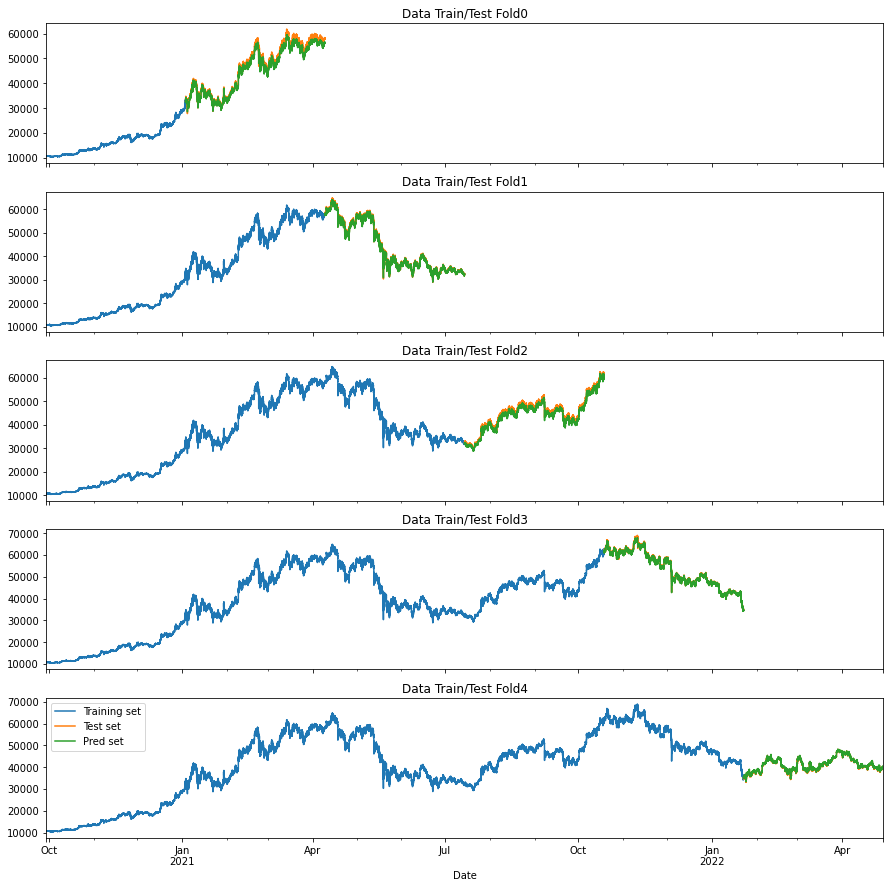

In [69]:
%%time
Best_trial = {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0008}
tss = TimeSeriesSplit(n_splits=5)
time_step = 10 
rmse, mae = [], []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
scaler = MinMaxScaler(feature_range=(0,1))
dataset = btc_df.copy()
dataset['Price'] = scaler.fit_transform(dataset) 

for train_idx, test_idx in tss.split(btc_df):
    print(f'------------------------round{fold+1}--------------------------------')
    train_data = np.array(dataset.iloc[train_idx])
    test_data = np.array(dataset.iloc[test_idx])
    
    x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step)   

    try:
        model=load_model('GRU_BTC_Model_fold{}_model.hdf5'.format(i+1))
    except:    
        model = Sequential()
        for i in range(Best_trial['n_layers']):
            model.add(
                GRU(
                    units=Best_trial['unit_cnt1'],
                    dropout=Best_trial['dropout1'],
                    activation='tanh',
                    return_sequences=True, 
                    input_shape = (x_train.shape[1], 1))
                )   
        model.add(
            GRU(
                units=Best_trial['unit_cnt2'],
                dropout=Best_trial['dropout2'],
                activation='tanh',
                return_sequences=False
            )
        )

        model.add(Dense(25))
        model.add(Dense(1))

        adam = optimizers.Adam(
            learning_rate=Best_trial['adam_lr']
        )
        model.compile(
            optimizer=adam, 
            loss='mean_squared_error'
        ) 

        # train the mode
        early_stop = callbacks.EarlyStopping(monitor = 'loss',
                                                       patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=1)    
        model.save(os.path.join(output_directory, 'GRU_BTC_Model_fold{}_model.hdf5'.format(fold+1)))
        
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse.append(get_rmse(predictions, y_test))
    mae.append(get_mae(predictions, y_test))
    
    train = btc_df.iloc[train_idx]
    valid = btc_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
cv_mae = np.mean(mae)
print('rmse:', rmse)
print('mae:', mae)
print('cv_rmse=', cv_rmse)
print('cv_mae=', cv_mae)
plt.legend()
plt.show()

### ETH

In [40]:
def objective(trial):
    clear_session()
    global x_train, y_train, x_test, y_test
    
    time_step = 10
    n_layers = trial.suggest_int("n_layers", 1, 2)
    model = Sequential()
    for i in range(n_layers):
        model.add(
            GRU(
                units=trial.suggest_categorical("unit_cnt1", [20, 30, 40, 50]),
                dropout=trial.suggest_categorical("dropout1", [0, 0.05, 0.1, 0.2]),
                # activation=trial.suggest_categorical("activation1", ['sigmoid', 'tanh']),
                return_sequences=True,
                #input_shape = (x_train.shape[1], 1)
            )
        )
    model.add(
        GRU(
            units=trial.suggest_categorical("unit_cnt2", [20, 30, 40, 50]),
            dropout=trial.suggest_categorical("dropout2", [0, 0.05, 0.1, 0.2]),
            # activation=trial.suggest_categorical("activation2", ['sigmoid', 'tanh']),
            return_sequences=False
        )
    )    
    
    model.add(Dense(1))

    # We compile our model with a sampled learning rate.
    adam = optimizers.Adam(
        learning_rate=trial.suggest_float("adam_lr", 1e-5, 1e-1, log=True) 
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    all_rmse = []
    fold = 0
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = eth_df_op.copy()
    dataset['Price'] = scaler.fit_transform(dataset) 
    
    # 5-fold time series CV
    tss = TimeSeriesSplit(n_splits=5)
    for train_idx, test_idx in tss.split(eth_df_op):
        train_data = np.array(dataset.iloc[train_idx])
        test_data = np.array(dataset.iloc[test_idx])

        x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step)
        
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=0)

    #     Evaluate the model accuracy on the validation set.
    #     score = model.evaluate(x_test, y_test, verbose=0)
    #     return score
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))   
        all_rmse.append(get_rmse(predictions, y_test))
        fold += 1
    return np.mean(all_rmse)


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-27 23:14:08,514] A new study created in memory with name: no-name-3290e6ec-ab83-4fca-96be-8f306fde4ea2


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:14:13,939] Trial 0 finished with value: 129.7211761233612 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00012170879313843016}. Best is trial 0 with value: 129.7211761233612.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:14:19,921] Trial 1 finished with value: 295.4620080142042 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.02842690666641208}. Best is trial 0 with value: 129.7211761233612.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:14:26,436] Trial 2 finished with value: 93.91025723201113 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.00251584349795359}. Best is trial 2 with value: 93.91025723201113.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:14:34,129] Trial 3 finished with value: 379.47903091889077 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.020986127525352637}. Best is trial 2 with value: 93.91025723201113.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:14:38,796] Trial 4 finished with value: 106.87880118596809 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.1, 'unit_cnt2': 50, 'dropout2': 0.2, 'adam_lr': 0.0031614117582710478}. Best is trial 2 with value: 93.91025723201113.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:14:44,046] Trial 5 finished with value: 512.6232243463737 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.02755083364467645}. Best is trial 2 with value: 93.91025723201113.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:14:50,513] Trial 6 finished with value: 2446.244580070528 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0, 'adam_lr': 0.09448089640018827}. Best is trial 2 with value: 93.91025723201113.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:14:54,835] Trial 7 finished with value: 99.79707482019514 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.2, 'unit_cnt2': 50, 'dropout2': 0, 'adam_lr': 0.0007755853230955855}. Best is trial 2 with value: 93.91025723201113.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:14:59,483] Trial 8 finished with value: 67.98948530231525 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.007976187415640787}. Best is trial 8 with value: 67.98948530231525.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:15:06,215] Trial 9 finished with value: 34.82610814224701 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 9.563391556665848e-05}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:15:14,845] Trial 10 finished with value: 426.4906944155713 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 1.1610991129257466e-05}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:15:22,398] Trial 11 finished with value: 49.76757516702152 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00010986731649959214}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:15:29,775] Trial 12 finished with value: 49.32553908921925 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 9.251251073930856e-05}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:15:36,999] Trial 13 finished with value: 58.673985561125264 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 8.124189124860102e-05}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:15:45,017] Trial 14 finished with value: 268.0933199269044 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 1.8441524900794645e-05}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:15:51,058] Trial 15 finished with value: 54.842410070853155 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0004153931748729584}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:16:01,253] Trial 16 finished with value: 130.2225327263697 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 3.445241113658417e-05}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:16:07,375] Trial 17 finished with value: 69.3039058002259 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 0.0003764974450952401}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:16:14,477] Trial 18 finished with value: 51.66545432631857 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 40, 'dropout2': 0.2, 'adam_lr': 4.3877158839462654e-05}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:16:21,400] Trial 19 finished with value: 94.95415114662266 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.2, 'unit_cnt2': 40, 'dropout2': 0.1, 'adam_lr': 0.00024348247409228046}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:16:27,981] Trial 20 finished with value: 92.91168286447157 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'unit_cnt2': 30, 'dropout2': 0, 'adam_lr': 0.0012903837153634536}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:16:34,659] Trial 21 finished with value: 39.40330711790419 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00012524189185067448}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:16:41,776] Trial 22 finished with value: 64.88940246608226 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00019519858618667667}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:16:49,005] Trial 23 finished with value: 110.39034058612613 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 4.706248049378551e-05}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:16:57,403] Trial 24 finished with value: 241.94031254400815 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0, 'adam_lr': 2.3446887907839185e-05}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:17:04,612] Trial 25 finished with value: 65.51933105416359 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'unit_cnt2': 40, 'dropout2': 0.05, 'adam_lr': 7.321211086099931e-05}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:17:10,562] Trial 26 finished with value: 99.87826381778306 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.1, 'unit_cnt2': 50, 'dropout2': 0.1, 'adam_lr': 0.0006960846122988346}. Best is trial 9 with value: 34.82610814224701.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:17:17,313] Trial 27 finished with value: 28.150831567592366 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.00018392963382950388}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:17:23,694] Trial 28 finished with value: 56.12542645656602 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0002093203506269349}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:17:31,610] Trial 29 finished with value: 43.399038600938 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0004101625616891461}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:17:38,348] Trial 30 finished with value: 35.98686996551644 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.00016404381103187724}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:17:44,880] Trial 31 finished with value: 35.463456859932435 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.00015611500260839564}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:17:51,111] Trial 32 finished with value: 41.91788023880724 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.00018124439198907987}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:17:57,209] Trial 33 finished with value: 68.27566023797948 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0010865264823497584}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 4ms/step


[I 2022-11-27 23:18:04,317] Trial 34 finished with value: 93.40880036788744 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 6.0802728271302196e-05}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:18:10,964] Trial 35 finished with value: 54.51164227661657 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0019218231592650734}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:18:15,627] Trial 36 finished with value: 30.995009191946917 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0003263626934557341}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:18:20,401] Trial 37 finished with value: 31.929701005010646 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.00031911878601086205}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:18:25,635] Trial 38 finished with value: 179.6246235675075 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 0.005278429771673907}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:18:30,363] Trial 39 finished with value: 76.759945222388 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0005602052502206424}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:18:35,519] Trial 40 finished with value: 44.30747001837865 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.0003265402597907163}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:18:40,535] Trial 41 finished with value: 60.85067334036764 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.00013667287744548217}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:18:45,302] Trial 42 finished with value: 31.832477377699167 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.00031982055035301935}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:18:49,910] Trial 43 finished with value: 51.51044421177155 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0002884634573784958}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:18:54,807] Trial 44 finished with value: 61.774101809522094 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0015628307648505382}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:18:59,458] Trial 45 finished with value: 42.5723799092698 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.000673938533696295}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:19:04,091] Trial 46 finished with value: 83.7374708555819 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0035513376690539137}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:19:11,693] Trial 47 finished with value: 105.23726764937632 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.2, 'adam_lr': 0.00044368810301551807}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:19:17,161] Trial 48 finished with value: 153.27537725279976 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 9.868045312575167e-05}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:19:21,638] Trial 49 finished with value: 31.763911084875012 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0008249299469299215}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:19:26,649] Trial 50 finished with value: 41.97346565554376 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0009525091922182315}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:19:31,719] Trial 51 finished with value: 77.68054854469135 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.014980465652097395}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:19:36,565] Trial 52 finished with value: 42.34857658052239 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0002646693519952218}. Best is trial 27 with value: 28.150831567592366.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:19:41,350] Trial 53 finished with value: 26.440314064124106 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0006039724487962502}. Best is trial 53 with value: 26.440314064124106.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:19:46,277] Trial 54 finished with value: 32.5429922673958 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0020648146290251843}. Best is trial 53 with value: 26.440314064124106.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:19:50,663] Trial 55 finished with value: 25.136235099301317 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0005431964155821351}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:19:55,520] Trial 56 finished with value: 45.78949044970074 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0010121982684603444}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:20:00,147] Trial 57 finished with value: 85.79355045904722 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0005455047605017454}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:20:04,736] Trial 58 finished with value: 51.40071015635478 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.000757092438402031}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:20:09,297] Trial 59 finished with value: 46.279120960677645 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.000500184376329689}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:20:13,951] Trial 60 finished with value: 178.09304559195192 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 20, 'dropout2': 0.1, 'adam_lr': 0.003061542332508852}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:20:19,222] Trial 61 finished with value: 49.21163019296539 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0003170036646121255}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:20:24,923] Trial 62 finished with value: 474.26804380396845 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.053748680292330694}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:20:29,682] Trial 63 finished with value: 66.72242631668287 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.1, 'adam_lr': 0.0014143594866100667}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:20:34,793] Trial 64 finished with value: 33.048098048132374 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.2, 'adam_lr': 0.0002461685405726989}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:20:39,527] Trial 65 finished with value: 28.83691018113557 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.0008108040180625306}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 23:20:47,088] Trial 66 finished with value: 42.23181419090958 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.0006275865815349976}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:20:51,449] Trial 67 finished with value: 50.082523503774226 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.0008622376737265154}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:20:55,839] Trial 68 finished with value: 36.734839657501084 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0012095673554602903}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:21:00,515] Trial 69 finished with value: 76.11142446781534 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.0004205773093119114}. Best is trial 55 with value: 25.136235099301317.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:21:05,571] Trial 70 finished with value: 24.680965756395846 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.0002194410168957766}. Best is trial 70 with value: 24.680965756395846.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:21:10,683] Trial 71 finished with value: 24.79762052164363 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.00021871730424179582}. Best is trial 70 with value: 24.680965756395846.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 23:21:15,810] Trial 72 finished with value: 66.01979873120221 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.00011834006308864521}. Best is trial 70 with value: 24.680965756395846.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:21:20,864] Trial 73 finished with value: 23.43972374545248 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.00023448859381443996}. Best is trial 73 with value: 23.43972374545248.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:21:25,976] Trial 74 finished with value: 21.031957341926795 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.00020544452557307594}. Best is trial 74 with value: 21.031957341926795.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:21:31,020] Trial 75 finished with value: 21.065191338142093 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.00020443856019051898}. Best is trial 74 with value: 21.031957341926795.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:21:36,902] Trial 76 finished with value: 74.30840870659954 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 6.459242975045857e-05}. Best is trial 74 with value: 21.031957341926795.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:21:41,883] Trial 77 finished with value: 61.83955380890809 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 0.00020798394513925223}. Best is trial 74 with value: 21.031957341926795.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:21:46,980] Trial 78 finished with value: 28.740893869555556 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0001566652325852972}. Best is trial 74 with value: 21.031957341926795.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:21:52,936] Trial 79 finished with value: 43.37124706035827 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 30, 'dropout2': 0.05, 'adam_lr': 8.056490042226657e-05}. Best is trial 74 with value: 21.031957341926795.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 23:21:58,157] Trial 80 finished with value: 36.059298929239034 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 20, 'dropout2': 0.05, 'adam_lr': 0.00013388459025273882}. Best is trial 74 with value: 21.031957341926795.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:22:03,249] Trial 81 finished with value: 22.926792403978332 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0001609328457071444}. Best is trial 74 with value: 21.031957341926795.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:22:08,184] Trial 82 finished with value: 29.136436484930336 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00021910036378659448}. Best is trial 74 with value: 21.031957341926795.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:22:12,869] Trial 83 finished with value: 21.058640922579126 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00017454339245878952}. Best is trial 74 with value: 21.031957341926795.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:22:18,520] Trial 84 finished with value: 147.1967445869937 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 4.614366547201231e-05}. Best is trial 74 with value: 21.031957341926795.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:22:25,033] Trial 85 finished with value: 30.842825461981118 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00010852203097067678}. Best is trial 74 with value: 21.031957341926795.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:22:33,070] Trial 86 finished with value: 20.634281765524406 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00017856641915106508}. Best is trial 86 with value: 20.634281765524406.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:22:37,617] Trial 87 finished with value: 21.570888680257504 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0001701349830146262}. Best is trial 86 with value: 20.634281765524406.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:22:43,912] Trial 88 finished with value: 118.29642148049808 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 3.5056516260923176e-05}. Best is trial 86 with value: 20.634281765524406.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-27 23:22:49,214] Trial 89 finished with value: 124.70315403806498 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 5.732012490147977e-05}. Best is trial 86 with value: 20.634281765524406.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:22:53,808] Trial 90 finished with value: 20.574883870791975 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00017916154986892787}. Best is trial 90 with value: 20.574883870791975.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:22:58,810] Trial 91 finished with value: 21.340613272343578 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0001720584371762619}. Best is trial 90 with value: 20.574883870791975.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:23:04,282] Trial 92 finished with value: 48.95578966970812 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 8.65487920215261e-05}. Best is trial 90 with value: 20.574883870791975.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:23:08,951] Trial 93 finished with value: 21.255155592496813 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00017279754622357194}. Best is trial 90 with value: 20.574883870791975.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:23:14,033] Trial 94 finished with value: 28.72514057784838 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00015685983496810315}. Best is trial 90 with value: 20.574883870791975.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:23:19,407] Trial 95 finished with value: 26.626423193673713 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00012651643663001417}. Best is trial 90 with value: 20.574883870791975.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:23:24,351] Trial 96 finished with value: 58.644578953820734 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.2, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00015698854547209587}. Best is trial 90 with value: 20.574883870791975.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:23:29,320] Trial 97 finished with value: 43.697996960292045 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 9.99358851616418e-05}. Best is trial 90 with value: 20.574883870791975.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:23:34,024] Trial 98 finished with value: 19.90625757176477 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00018727335373781135}. Best is trial 98 with value: 19.90625757176477.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-27 23:23:38,713] Trial 99 finished with value: 21.268546404531584 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.00017268245067381905}. Best is trial 98 with value: 19.90625757176477.


Number of finished trials: 100
Best trial:
  Value: 19.90625757176477
  Params: 
    n_layers: 1
    unit_cnt1: 50
    dropout1: 0
    unit_cnt2: 50
    dropout2: 0.05
    adam_lr: 0.00018727335373781135


------------------------round1--------------------------------
Epoch 1/50
541/541 [==============================] - 6s 7ms/step - loss: 2.3228e-05
Epoch 2/50
541/541 [==============================] - 4s 7ms/step - loss: 4.8158e-07
Epoch 3/50
541/541 [==============================] - 4s 7ms/step - loss: 4.2071e-07
Epoch 4/50
541/541 [==============================] - 4s 7ms/step - loss: 5.4197e-07
Epoch 5/50
541/541 [==============================] - 4s 7ms/step - loss: 6.1428e-07
Epoch 6/50
4328/4328 [==============================] - 11s 2ms/step
------------------------round2--------------------------------
Epoch 1/50
1082/1082 [==============================] - 10s 7ms/step - loss: 3.4604e-04
Epoch 2/50
1082/1082 [==============================] - 7s 7ms/step - loss: 8.4005e-06
Epoch 3/50
1082/1082 [==============================] - 7s 7ms/step - loss: 5.4835e-06
Epoch 4/50
1082/1082 [==============================] - 8s 7ms/step - loss: 4.6427e-06
Epoch 5/50
1082/1082 [=========

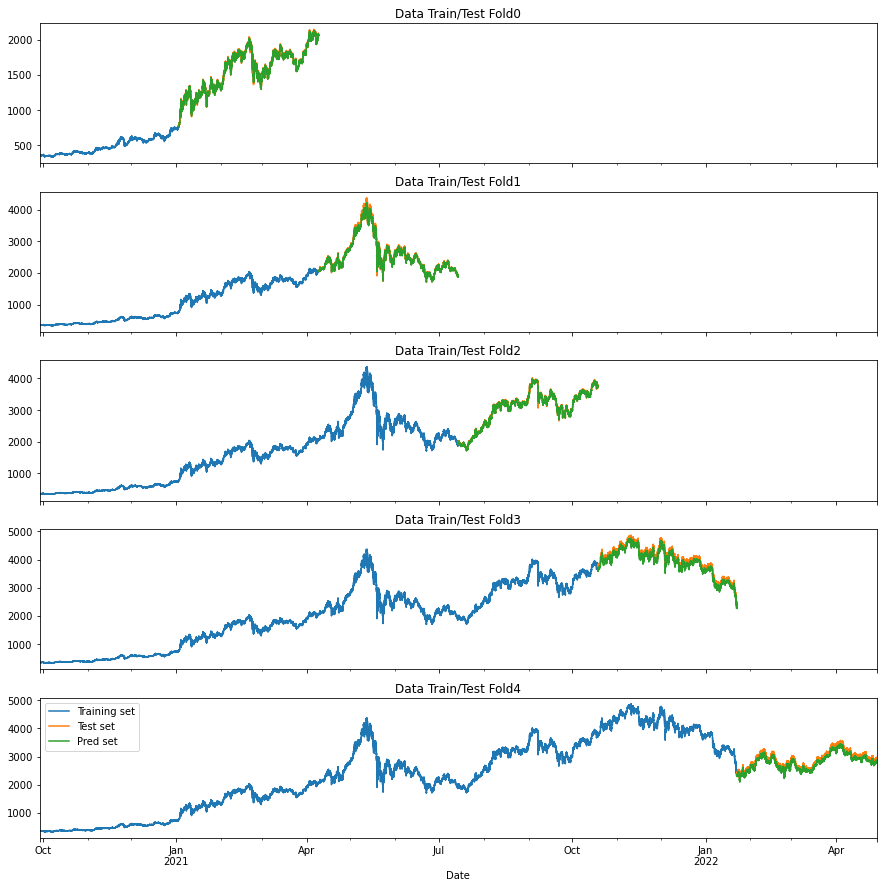

In [42]:
%%time 
Best_trial = {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'unit_cnt2': 50, 'dropout2': 0.05, 'adam_lr': 0.0001}
tss = TimeSeriesSplit(n_splits=5)
time_step = 10 
rmse, mae = [], []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
scaler = MinMaxScaler(feature_range=(0,1))
dataset = eth_df.copy()
dataset['Price'] = scaler.fit_transform(dataset) 

for train_idx, test_idx in tss.split(eth_df):
    print(f'------------------------round{fold+1}--------------------------------')
    train_data = np.array(dataset.iloc[train_idx])
    test_data = np.array(dataset.iloc[test_idx])
    
    x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step)    

    try:
        model=load_model('GRU_ETH_Model_fold{}_model.hdf5'.format(i+1))
    except:
        model = Sequential()
        for i in range(Best_trial['n_layers']):
            model.add(
                GRU(
                    units=Best_trial['unit_cnt1'],
                    dropout=Best_trial['dropout1'],
                    activation='tanh',
                    return_sequences=True, 
                    input_shape = (x_train.shape[1], 1))
                )   
        model.add(
            GRU(
                units=Best_trial['unit_cnt2'],
                dropout=Best_trial['dropout2'],
                activation='tanh',
                return_sequences=False
            )
        )

        model.add(Dense(25))
        model.add(Dense(1))

        adam = optimizers.Adam(
            learning_rate=Best_trial['adam_lr']
        )
        model.compile(
            optimizer=adam, 
            loss='mean_squared_error'
        ) 

        # train the mode
        early_stop = callbacks.EarlyStopping(monitor = 'loss',
                                                       patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=1)    
        model.save(os.path.join(output_directory, 'GRU_ETH_Model_fold{}_model.hdf5'.format(fold+1)))
        
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse.append(get_rmse(predictions, y_test))
    mae.append(get_mae(predictions, y_test))
    
    train = eth_df.iloc[train_idx]
    valid = eth_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
cv_mae = np.mean(mae)
print('rmse:', rmse)
print('mae:', mae)
print('cv_rmse=', cv_rmse)
print('cv_mae=', cv_mae)
plt.legend()
plt.show()

## T2V+LSTM

<img src="pics/t2v.png" width=500 height=500 />

### BTC

In [26]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p #if i = 0
        sin_trans = K.sin(K.dot(x, self.W) + self.P) # Frequecy and phase shift of sine function, learnable parameters. 
                                                     # if 1 <= i <= k
        return K.concatenate([sin_trans, original], -1)
    
def T2V_NN(param, dim):
    
    inp = layers.Input(shape=(dim,1))
    x = T2V(param['t2v_dim'])(inp)
    x = LSTM(param['unit'], dropout=param['dropout'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer='adam')
    
    return m

In [92]:
def objective(trial):
    clear_session()
    global x_train, y_train, x_test, y_test
    
    time_step = 10
    base_param = {
        'unit': trial.suggest_categorical("unit_cnt1", [20, 30, 40, 50]),
        'dropout': trial.suggest_categorical("dropout1", [0, 0.05, 0.1, 0.2]),
        't2v_dim': trial.suggest_categorical("t2v_dim", [128, 64, 16]),
        'lr': trial.suggest_float("lr", 1e-5, 1e-1, log=True) 
    }
    
    model = T2V_NN(param=base_param, dim=10)

    # We compile our model with a sampled learning rate.
    adam = optimizers.Adam(
        learning_rate=base_param['lr']
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    all_rmse = []
    fold = 0
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = btc_df.copy()
    dataset['Price'] = scaler.fit_transform(dataset) 
    
    # 5-fold time series CV
    tss = TimeSeriesSplit(n_splits=5)
    for train_idx, test_idx in tss.split(btc_df):
        train_data = np.array(dataset.iloc[train_idx])
        test_data = np.array(dataset.iloc[test_idx])

        x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step) 
        
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=0)

    #     Evaluate the model accuracy on the validation set.
    #     score = model.evaluate(x_test, y_test, verbose=0)
    #     return score
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
        all_rmse.append(get_rmse(predictions, y_test))
        fold += 1
    return np.mean(all_rmse)


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-23 18:54:18,042] A new study created in memory with name: no-name-26cd9a27-b768-4974-89cf-1edab3215301


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:54:21,348] Trial 0 finished with value: 2837.223220392972 and parameters: {'unit_cnt1': 40, 'dropout1': 0.05, 't2v_dim': 128, 'lr': 0.0760784616224124}. Best is trial 0 with value: 2837.223220392972.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:54:24,661] Trial 1 finished with value: 5979.939182034604 and parameters: {'unit_cnt1': 50, 'dropout1': 0.05, 't2v_dim': 64, 'lr': 0.06612656601563373}. Best is trial 0 with value: 2837.223220392972.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:54:27,542] Trial 2 finished with value: 2711.669548769447 and parameters: {'unit_cnt1': 30, 'dropout1': 0, 't2v_dim': 16, 'lr': 0.033036750821778295}. Best is trial 2 with value: 2711.669548769447.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:54:30,829] Trial 3 finished with value: 3443.383251722606 and parameters: {'unit_cnt1': 50, 'dropout1': 0.2, 't2v_dim': 128, 'lr': 0.020195154884518667}. Best is trial 2 with value: 2711.669548769447.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:54:34,437] Trial 4 finished with value: 1241.546334663358 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.00020564199305938562}. Best is trial 4 with value: 1241.546334663358.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:54:37,333] Trial 5 finished with value: 4462.048211926636 and parameters: {'unit_cnt1': 20, 'dropout1': 0.1, 't2v_dim': 16, 'lr': 0.04160765343560967}. Best is trial 4 with value: 1241.546334663358.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:54:41,023] Trial 6 finished with value: 1175.9909557738733 and parameters: {'unit_cnt1': 30, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.0002736391761297168}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:54:45,680] Trial 7 finished with value: 1890.4565697089595 and parameters: {'unit_cnt1': 40, 'dropout1': 0, 't2v_dim': 16, 'lr': 0.0004008884596103888}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:54:49,290] Trial 8 finished with value: 7076.95807822559 and parameters: {'unit_cnt1': 50, 'dropout1': 0.1, 't2v_dim': 16, 'lr': 0.07520449736020421}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:54:52,103] Trial 9 finished with value: 1716.3926652192865 and parameters: {'unit_cnt1': 20, 'dropout1': 0.2, 't2v_dim': 64, 'lr': 0.0015934046573642159}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:54:57,330] Trial 10 finished with value: 11109.304736453863 and parameters: {'unit_cnt1': 30, 'dropout1': 0, 't2v_dim': 64, 'lr': 1.559026560783527e-05}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:01,403] Trial 11 finished with value: 3140.042442831277 and parameters: {'unit_cnt1': 30, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.00014495248527812167}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:06,542] Trial 12 finished with value: 5536.94959378353 and parameters: {'unit_cnt1': 30, 'dropout1': 0, 't2v_dim': 64, 'lr': 4.809174362275573e-05}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:09,586] Trial 13 finished with value: 1823.2822696486048 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.0021286502671907766}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:13,291] Trial 14 finished with value: 1488.022478876073 and parameters: {'unit_cnt1': 30, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.00045159431258915713}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:16,085] Trial 15 finished with value: 1903.1616568032455 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.00495902519080011}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:19,470] Trial 16 finished with value: 4351.217129744501 and parameters: {'unit_cnt1': 20, 'dropout1': 0.1, 't2v_dim': 128, 'lr': 0.0001050705981231909}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:24,563] Trial 17 finished with value: 14183.534481583623 and parameters: {'unit_cnt1': 40, 'dropout1': 0.05, 't2v_dim': 64, 'lr': 1.3518911757829931e-05}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:27,492] Trial 18 finished with value: 1504.7839623289967 and parameters: {'unit_cnt1': 50, 'dropout1': 0.2, 't2v_dim': 64, 'lr': 0.00047997288692410025}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:32,244] Trial 19 finished with value: 5271.067014904105 and parameters: {'unit_cnt1': 30, 'dropout1': 0, 't2v_dim': 128, 'lr': 5.309754076238018e-05}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:34,985] Trial 20 finished with value: 2895.5679263764086 and parameters: {'unit_cnt1': 30, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.007474229329214045}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:42,009] Trial 21 finished with value: 1453.4340387774946 and parameters: {'unit_cnt1': 30, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.00038407816622391077}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:46,128] Trial 22 finished with value: 1432.479496043455 and parameters: {'unit_cnt1': 30, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.00015638751674885485}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:50,534] Trial 23 finished with value: 1820.0173078728542 and parameters: {'unit_cnt1': 30, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.00020695121909826175}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:55,662] Trial 24 finished with value: 5640.123092475858 and parameters: {'unit_cnt1': 30, 'dropout1': 0, 't2v_dim': 64, 'lr': 5.031804889737319e-05}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:55:58,857] Trial 25 finished with value: 1426.0777819038358 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.0007568977372182255}. Best is trial 6 with value: 1175.9909557738733.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:01,971] Trial 26 finished with value: 1152.4821040940183 and parameters: {'unit_cnt1': 50, 'dropout1': 0.05, 't2v_dim': 64, 'lr': 0.0009680250094966283}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:04,931] Trial 27 finished with value: 1955.386271040102 and parameters: {'unit_cnt1': 50, 'dropout1': 0.05, 't2v_dim': 16, 'lr': 0.0013559452375995434}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:07,944] Trial 28 finished with value: 2462.829840438909 and parameters: {'unit_cnt1': 50, 'dropout1': 0.05, 't2v_dim': 128, 'lr': 0.005013100054368766}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:10,694] Trial 29 finished with value: 2024.7657904707619 and parameters: {'unit_cnt1': 40, 'dropout1': 0.05, 't2v_dim': 64, 'lr': 0.003046636229096108}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:13,688] Trial 30 finished with value: 1489.3956190484175 and parameters: {'unit_cnt1': 50, 'dropout1': 0.05, 't2v_dim': 128, 'lr': 0.0007449809501620719}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:16,672] Trial 31 finished with value: 1612.5315230183742 and parameters: {'unit_cnt1': 50, 'dropout1': 0.05, 't2v_dim': 64, 'lr': 0.0009188052701130843}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:19,835] Trial 32 finished with value: 1827.4574980720226 and parameters: {'unit_cnt1': 50, 'dropout1': 0.2, 't2v_dim': 64, 'lr': 0.00076788831141392}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:22,940] Trial 33 finished with value: 1539.6905184582886 and parameters: {'unit_cnt1': 50, 'dropout1': 0.1, 't2v_dim': 64, 'lr': 0.00025791714343174524}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:26,583] Trial 34 finished with value: 4557.05049549021 and parameters: {'unit_cnt1': 50, 'dropout1': 0.05, 't2v_dim': 64, 'lr': 8.901965664691696e-05}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:31,965] Trial 35 finished with value: 6590.285713184012 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 64, 'lr': 2.8392360825051338e-05}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:34,860] Trial 36 finished with value: 2898.9559863490817 and parameters: {'unit_cnt1': 20, 'dropout1': 0, 't2v_dim': 16, 'lr': 0.010418077965743922}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:38,416] Trial 37 finished with value: 1652.3256652360512 and parameters: {'unit_cnt1': 40, 'dropout1': 0.2, 't2v_dim': 64, 'lr': 0.00027355569598135873}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:41,314] Trial 38 finished with value: 1738.4203530713519 and parameters: {'unit_cnt1': 50, 'dropout1': 0.1, 't2v_dim': 16, 'lr': 0.0006365722765144409}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:44,466] Trial 39 finished with value: 1399.2247890960298 and parameters: {'unit_cnt1': 50, 'dropout1': 0.05, 't2v_dim': 64, 'lr': 0.0013571406857273724}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:47,401] Trial 40 finished with value: 1805.2415490879825 and parameters: {'unit_cnt1': 20, 'dropout1': 0.05, 't2v_dim': 128, 'lr': 0.0025809287396898013}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:50,506] Trial 41 finished with value: 1616.8294380364805 and parameters: {'unit_cnt1': 50, 'dropout1': 0.05, 't2v_dim': 64, 'lr': 0.0013605158923669296}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:53,644] Trial 42 finished with value: 1502.7121175060352 and parameters: {'unit_cnt1': 50, 'dropout1': 0.05, 't2v_dim': 64, 'lr': 0.0010678824395616792}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:56:57,675] Trial 43 finished with value: 1530.1892600757778 and parameters: {'unit_cnt1': 50, 'dropout1': 0.05, 't2v_dim': 64, 'lr': 0.00033233307059270494}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:57:01,399] Trial 44 finished with value: 1199.4721630230686 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.0001707640969712392}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:57:05,581] Trial 45 finished with value: 3957.2557609643236 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.00010604454380097076}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-23 18:57:10,055] Trial 46 finished with value: 1590.1728887808476 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.00019635119196301966}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:57:12,999] Trial 47 finished with value: 1751.871613633315 and parameters: {'unit_cnt1': 40, 'dropout1': 0.1, 't2v_dim': 16, 'lr': 0.0018480650769957699}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:57:16,451] Trial 48 finished with value: 6812.211979949035 and parameters: {'unit_cnt1': 50, 'dropout1': 0.2, 't2v_dim': 64, 'lr': 8.044092186362311e-05}. Best is trial 26 with value: 1152.4821040940183.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-23 18:57:21,315] Trial 49 finished with value: 10652.602049859173 and parameters: {'unit_cnt1': 20, 'dropout1': 0.05, 't2v_dim': 64, 'lr': 2.9628595577874363e-05}. Best is trial 26 with value: 1152.4821040940183.


Number of finished trials: 50
Best trial:
  Value: 1152.4821040940183
  Params: 
    unit_cnt1: 50
    dropout1: 0.05
    t2v_dim: 64
    lr: 0.0009680250094966283


------------------------round1--------------------------------
Epoch 1/50
541/541 [==============================] - 5s 7ms/step - loss: 4.0089e-04
Epoch 2/50
541/541 [==============================] - 3s 6ms/step - loss: 1.3314e-05
Epoch 3/50
541/541 [==============================] - 3s 6ms/step - loss: 6.2574e-06
Epoch 4/50
541/541 [==============================] - 3s 6ms/step - loss: 3.7998e-06
Epoch 5/50
541/541 [==============================] - 3s 6ms/step - loss: 2.8634e-06
Epoch 6/50
541/541 [==============================] - 3s 6ms/step - loss: 2.9151e-06
Epoch 7/50
541/541 [==============================] - 3s 6ms/step - loss: 2.6801e-06
Epoch 8/50
541/541 [==============================] - 3s 6ms/step - loss: 2.7859e-06
Epoch 9/50
541/541 [==============================] - 3s 6ms/step - loss: 2.4984e-06
Epoch 10/50
541/541 [==============================] - 3s 6ms/step - loss: 2.5630e-06
Epoch 11/50
541/541 [==============================] - 3s 6ms/step - loss: 2.6066e-06


Epoch 45/50
1623/1623 [==============================] - 10s 6ms/step - loss: 5.1620e-06
Epoch 46/50
1623/1623 [==============================] - 10s 6ms/step - loss: 5.1954e-06
Epoch 47/50
1623/1623 [==============================] - 10s 6ms/step - loss: 5.1511e-06
Epoch 48/50
1623/1623 [==============================] - 10s 6ms/step - loss: 5.1261e-06
Epoch 49/50
1623/1623 [==============================] - 10s 6ms/step - loss: 5.0320e-06
Epoch 50/50
4328/4328 [==============================] - 10s 2ms/step
------------------------round4--------------------------------
Epoch 1/50
2164/2164 [==============================] - 14s 6ms/step - loss: 0.0015
Epoch 2/50
2164/2164 [==============================] - 13s 6ms/step - loss: 2.9303e-05
Epoch 3/50
2164/2164 [==============================] - 13s 6ms/step - loss: 1.9738e-05
Epoch 4/50
2164/2164 [==============================] - 13s 6ms/step - loss: 1.5544e-05
Epoch 5/50
2164/2164 [==============================] - 13s 6ms/step - los

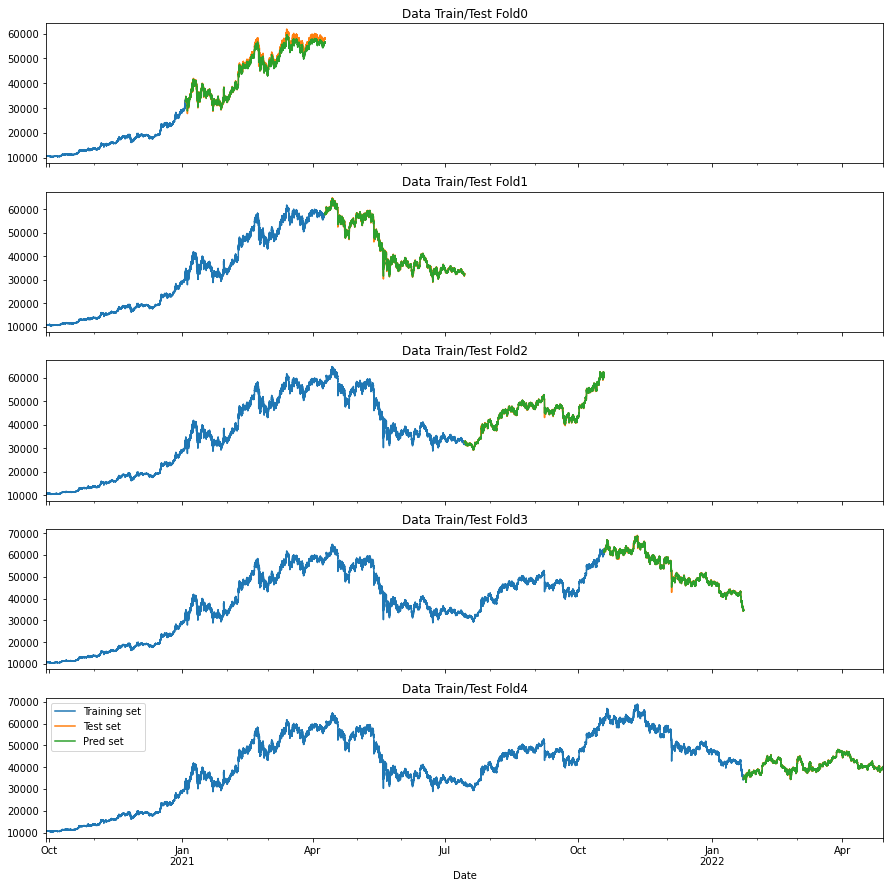

In [68]:
%%time 
tss = TimeSeriesSplit(n_splits=5)
time_step = 10 
rmse, mae = [], []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
scaler = MinMaxScaler(feature_range=(0,1))
dataset = btc_df.copy()
dataset['Price'] = scaler.fit_transform(dataset) 

for train_idx, test_idx in tss.split(btc_df):
    print(f'------------------------round{fold+1}--------------------------------')
    train_data = np.array(dataset.iloc[train_idx])
    test_data = np.array(dataset.iloc[test_idx])
    
    x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step)   

    base_param = {
        'unit': 50,
        'dropout': 0.05,
        't2v_dim': 64
    }    
    
    try:
        model=load_model('T2V_BTC_Model_fold{}_model.hdf5'.format(i+1))
    except:
        model = T2V_NN(param=base_param, dim=10)

        adam = optimizers.Adam(
            learning_rate=0.001
        )
        model.compile(
            optimizer=adam, 
            loss='mean_squared_error'
        ) 

        # train the mode
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=1)  
        model.save(os.path.join(output_directory, 'T2V_BTC_Model_fold{}_model.hdf5'.format(fold+1)))
        
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse.append(get_rmse(predictions, y_test))
    mae.append(get_mae(predictions, y_test))
    
    train = btc_df.iloc[train_idx]
    valid = btc_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
cv_mae = np.mean(mae)
print('rmse:', rmse)
print('mae:', mae)
print('cv_rmse=', cv_rmse)
print('cv_mae=', cv_mae)
plt.legend()
plt.show()

### ETH

In [44]:
def objective(trial):
    clear_session()
    global x_train, y_train, x_test, y_test
    
    time_step = 10
    base_param = {
        'unit': trial.suggest_categorical("unit_cnt1", [20, 30, 40, 50]),
        'dropout': trial.suggest_categorical("dropout1", [0, 0.05, 0.1, 0.2]),
        't2v_dim': trial.suggest_categorical("t2v_dim", [128, 64, 16]),
        'lr': trial.suggest_float("lr", 1e-5, 1e-1, log=True) 
    }
    
    model = T2V_NN(param=base_param, dim=10)

    # We compile our model with a sampled learning rate.
    adam = optimizers.Adam(
        learning_rate=base_param['lr']
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    all_rmse = []
    fold = 0
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = eth_df_op.copy()
    dataset['Price'] = scaler.fit_transform(dataset) 
    
    # 5-fold time series CV
    tss = TimeSeriesSplit(n_splits=5)
    for train_idx, test_idx in tss.split(eth_df_op):
        train_data = np.array(dataset.iloc[train_idx])
        test_data = np.array(dataset.iloc[test_idx])

        x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step) 
        
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=0)

    #     Evaluate the model accuracy on the validation set.
    #     score = model.evaluate(x_test, y_test, verbose=0)
    #     return score
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
        all_rmse.append(get_rmse(predictions, y_test))
        fold += 1
    return np.mean(all_rmse)


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-28 01:34:16,621] A new study created in memory with name: no-name-5838e143-5087-402c-a059-c639bf6da3e4


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:34:20,497] Trial 0 finished with value: 97.32494815312334 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 16, 'lr': 0.029109684508960898}. Best is trial 0 with value: 97.32494815312334.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:34:23,793] Trial 1 finished with value: 76.2550832988428 and parameters: {'unit_cnt1': 40, 'dropout1': 0.1, 't2v_dim': 128, 'lr': 0.003842053720784277}. Best is trial 1 with value: 76.2550832988428.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:34:27,238] Trial 2 finished with value: 292.2199555708595 and parameters: {'unit_cnt1': 20, 'dropout1': 0.2, 't2v_dim': 64, 'lr': 0.033244303344088254}. Best is trial 1 with value: 76.2550832988428.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:34:32,450] Trial 3 finished with value: 1075.69091613298 and parameters: {'unit_cnt1': 30, 'dropout1': 0.1, 't2v_dim': 16, 'lr': 1.6897664750379357e-05}. Best is trial 1 with value: 76.2550832988428.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:34:37,637] Trial 4 finished with value: 919.6087209263093 and parameters: {'unit_cnt1': 40, 'dropout1': 0.2, 't2v_dim': 64, 'lr': 1.2190136453933292e-05}. Best is trial 1 with value: 76.2550832988428.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:34:41,199] Trial 5 finished with value: 144.74167836358723 and parameters: {'unit_cnt1': 20, 'dropout1': 0, 't2v_dim': 128, 'lr': 0.006614294170505742}. Best is trial 1 with value: 76.2550832988428.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:34:44,977] Trial 6 finished with value: 722.9842936233553 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.04503307960957549}. Best is trial 1 with value: 76.2550832988428.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:34:48,598] Trial 7 finished with value: 495.6268828621729 and parameters: {'unit_cnt1': 40, 'dropout1': 0.1, 't2v_dim': 64, 'lr': 0.0842894874826662}. Best is trial 1 with value: 76.2550832988428.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:34:52,203] Trial 8 finished with value: 140.1756872417139 and parameters: {'unit_cnt1': 20, 'dropout1': 0.05, 't2v_dim': 128, 'lr': 0.007336581555120489}. Best is trial 1 with value: 76.2550832988428.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:34:55,922] Trial 9 finished with value: 59.975339291552096 and parameters: {'unit_cnt1': 30, 'dropout1': 0.1, 't2v_dim': 16, 'lr': 0.0007682234664149915}. Best is trial 9 with value: 59.975339291552096.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:34:59,327] Trial 10 finished with value: 327.11946840369745 and parameters: {'unit_cnt1': 30, 'dropout1': 0.05, 't2v_dim': 16, 'lr': 0.00026088984024564004}. Best is trial 9 with value: 59.975339291552096.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:35:02,721] Trial 11 finished with value: 60.32081759342308 and parameters: {'unit_cnt1': 30, 'dropout1': 0.1, 't2v_dim': 128, 'lr': 0.0009849788637408656}. Best is trial 9 with value: 59.975339291552096.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:35:06,973] Trial 12 finished with value: 74.2901854646216 and parameters: {'unit_cnt1': 30, 'dropout1': 0.1, 't2v_dim': 128, 'lr': 0.0003502465932420036}. Best is trial 9 with value: 59.975339291552096.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:35:10,626] Trial 13 finished with value: 92.42698060025062 and parameters: {'unit_cnt1': 30, 'dropout1': 0.1, 't2v_dim': 16, 'lr': 0.0006460235636264484}. Best is trial 9 with value: 59.975339291552096.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:35:14,417] Trial 14 finished with value: 278.613180813376 and parameters: {'unit_cnt1': 30, 'dropout1': 0.1, 't2v_dim': 128, 'lr': 8.542016318554973e-05}. Best is trial 9 with value: 59.975339291552096.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:35:17,933] Trial 15 finished with value: 80.60759805389534 and parameters: {'unit_cnt1': 30, 'dropout1': 0.1, 't2v_dim': 16, 'lr': 0.001959879026104185}. Best is trial 9 with value: 59.975339291552096.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:35:21,853] Trial 16 finished with value: 288.89276591576834 and parameters: {'unit_cnt1': 30, 'dropout1': 0.1, 't2v_dim': 128, 'lr': 9.58361060686232e-05}. Best is trial 9 with value: 59.975339291552096.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:35:25,103] Trial 17 finished with value: 63.54238954522784 and parameters: {'unit_cnt1': 30, 'dropout1': 0.2, 't2v_dim': 16, 'lr': 0.00142194761321963}. Best is trial 9 with value: 59.975339291552096.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:35:29,051] Trial 18 finished with value: 309.566405844496 and parameters: {'unit_cnt1': 50, 'dropout1': 0.05, 't2v_dim': 128, 'lr': 8.9278685854831e-05}. Best is trial 9 with value: 59.975339291552096.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:35:32,897] Trial 19 finished with value: 65.56672988983286 and parameters: {'unit_cnt1': 30, 'dropout1': 0.1, 't2v_dim': 16, 'lr': 0.000627824412742854}. Best is trial 9 with value: 59.975339291552096.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:35:36,931] Trial 20 finished with value: 289.0005326828854 and parameters: {'unit_cnt1': 30, 'dropout1': 0.1, 't2v_dim': 16, 'lr': 0.00018988973240517803}. Best is trial 9 with value: 59.975339291552096.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:35:40,440] Trial 21 finished with value: 59.64779477622888 and parameters: {'unit_cnt1': 30, 'dropout1': 0.2, 't2v_dim': 16, 'lr': 0.0016947028434131037}. Best is trial 21 with value: 59.64779477622888.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:35:43,962] Trial 22 finished with value: 80.04321327098144 and parameters: {'unit_cnt1': 30, 'dropout1': 0.2, 't2v_dim': 16, 'lr': 0.002481407233171831}. Best is trial 21 with value: 59.64779477622888.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:35:47,044] Trial 23 finished with value: 357.4065371185433 and parameters: {'unit_cnt1': 30, 'dropout1': 0.2, 't2v_dim': 16, 'lr': 0.010943830451007584}. Best is trial 21 with value: 59.64779477622888.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:35:50,410] Trial 24 finished with value: 83.3676874853306 and parameters: {'unit_cnt1': 30, 'dropout1': 0.2, 't2v_dim': 16, 'lr': 0.000978439611343682}. Best is trial 21 with value: 59.64779477622888.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:35:54,034] Trial 25 finished with value: 144.2405238495528 and parameters: {'unit_cnt1': 30, 'dropout1': 0.2, 't2v_dim': 128, 'lr': 0.003701578768503901}. Best is trial 21 with value: 59.64779477622888.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:35:57,497] Trial 26 finished with value: 79.4315419172688 and parameters: {'unit_cnt1': 20, 'dropout1': 0.05, 't2v_dim': 16, 'lr': 0.0006226894171980198}. Best is trial 21 with value: 59.64779477622888.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:36:00,997] Trial 27 finished with value: 74.893287041791 and parameters: {'unit_cnt1': 40, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.013446939393822905}. Best is trial 21 with value: 59.64779477622888.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:36:05,948] Trial 28 finished with value: 699.3631984313179 and parameters: {'unit_cnt1': 50, 'dropout1': 0.1, 't2v_dim': 16, 'lr': 4.109841969655261e-05}. Best is trial 21 with value: 59.64779477622888.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:36:09,186] Trial 29 finished with value: 62.51071014849616 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 128, 'lr': 0.0010566412451795144}. Best is trial 21 with value: 59.64779477622888.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:36:12,493] Trial 30 finished with value: 320.19205808556023 and parameters: {'unit_cnt1': 30, 'dropout1': 0.2, 't2v_dim': 16, 'lr': 0.0003627312871211621}. Best is trial 21 with value: 59.64779477622888.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:36:19,507] Trial 31 finished with value: 66.36092113000434 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 128, 'lr': 0.0012666757206741218}. Best is trial 21 with value: 59.64779477622888.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:36:22,890] Trial 32 finished with value: 121.4988428004187 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 128, 'lr': 0.003696009190517329}. Best is trial 21 with value: 59.64779477622888.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:36:26,366] Trial 33 finished with value: 55.809720860035114 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 128, 'lr': 0.0010716166255351459}. Best is trial 33 with value: 55.809720860035114.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:36:29,607] Trial 34 finished with value: 89.89097198617304 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 128, 'lr': 0.0023587985945719746}. Best is trial 33 with value: 55.809720860035114.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:36:33,399] Trial 35 finished with value: 66.87198324126541 and parameters: {'unit_cnt1': 40, 'dropout1': 0.1, 't2v_dim': 128, 'lr': 0.00048649849378318825}. Best is trial 33 with value: 55.809720860035114.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:36:38,997] Trial 36 finished with value: 73.03048782230752 and parameters: {'unit_cnt1': 20, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.00014133679402341496}. Best is trial 33 with value: 55.809720860035114.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:36:42,352] Trial 37 finished with value: 103.20240821936613 and parameters: {'unit_cnt1': 50, 'dropout1': 0.2, 't2v_dim': 128, 'lr': 0.005157131958934517}. Best is trial 33 with value: 55.809720860035114.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:36:46,077] Trial 38 finished with value: 92.09030292612495 and parameters: {'unit_cnt1': 30, 'dropout1': 0.1, 't2v_dim': 16, 'lr': 0.020813042080533948}. Best is trial 33 with value: 55.809720860035114.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:36:49,243] Trial 39 finished with value: 64.40309222490696 and parameters: {'unit_cnt1': 40, 'dropout1': 0, 't2v_dim': 64, 'lr': 0.0018319900467822637}. Best is trial 33 with value: 55.809720860035114.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:36:52,586] Trial 40 finished with value: 63.827170743361044 and parameters: {'unit_cnt1': 30, 'dropout1': 0.1, 't2v_dim': 128, 'lr': 0.0008181925649929832}. Best is trial 33 with value: 55.809720860035114.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:36:56,121] Trial 41 finished with value: 66.37259346840003 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 128, 'lr': 0.0010611210944069874}. Best is trial 33 with value: 55.809720860035114.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:36:59,897] Trial 42 finished with value: 37.93986681788367 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 128, 'lr': 0.0003892927231110937}. Best is trial 42 with value: 37.93986681788367.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:37:04,225] Trial 43 finished with value: 44.418804037331505 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 128, 'lr': 0.0002913932821944368}. Best is trial 42 with value: 37.93986681788367.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:37:08,677] Trial 44 finished with value: 47.143751122732525 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 128, 'lr': 0.0002426846107826977}. Best is trial 42 with value: 37.93986681788367.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:37:14,105] Trial 45 finished with value: 240.1389277254685 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 128, 'lr': 3.5229664158094424e-05}. Best is trial 42 with value: 37.93986681788367.


8/8 [==============================] - 0s 2ms/step


[I 2022-11-28 01:37:18,621] Trial 46 finished with value: 88.01249943313269 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 128, 'lr': 0.00024048967522472976}. Best is trial 42 with value: 37.93986681788367.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:37:22,568] Trial 47 finished with value: 66.84039311512959 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 128, 'lr': 0.00035442193358403695}. Best is trial 42 with value: 37.93986681788367.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:37:28,033] Trial 48 finished with value: 133.08275469472994 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 128, 'lr': 0.00015889295313391123}. Best is trial 42 with value: 37.93986681788367.


8/8 [==============================] - 0s 3ms/step


[I 2022-11-28 01:37:33,523] Trial 49 finished with value: 262.27985604138024 and parameters: {'unit_cnt1': 50, 'dropout1': 0, 't2v_dim': 128, 'lr': 5.5306707837751034e-05}. Best is trial 42 with value: 37.93986681788367.


Number of finished trials: 50
Best trial:
  Value: 37.93986681788367
  Params: 
    unit_cnt1: 50
    dropout1: 0
    t2v_dim: 128
    lr: 0.0003892927231110937


------------------------round1--------------------------------
Epoch 1/50
541/541 [==============================] - 4s 6ms/step - loss: 4.3136e-05
Epoch 2/50
541/541 [==============================] - 3s 5ms/step - loss: 1.1716e-07
Epoch 3/50
541/541 [==============================] - 3s 5ms/step - loss: 2.4991e-07
Epoch 4/50
541/541 [==============================] - 3s 5ms/step - loss: 2.8303e-07
Epoch 5/50
4328/4328 [==============================] - 9s 2ms/step
------------------------round2--------------------------------
Epoch 1/50
1082/1082 [==============================] - 7s 6ms/step - loss: 6.7354e-04
Epoch 2/50
1082/1082 [==============================] - 6s 6ms/step - loss: 5.3003e-07
Epoch 3/50
1082/1082 [==============================] - 6s 6ms/step - loss: 5.4996e-07
Epoch 4/50
1082/1082 [==============================] - 6s 6ms/step - loss: 6.0304e-07
Epoch 5/50
4328/4328 [==============================] - 9s 2ms/step
------------------------round3--------------------

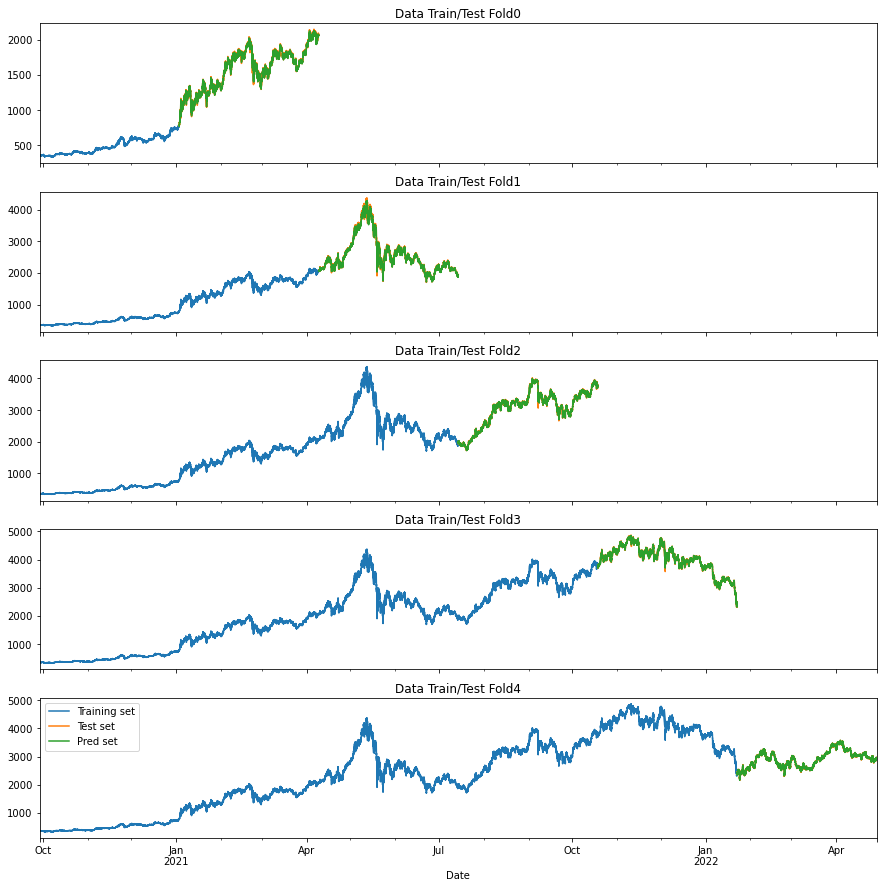

In [46]:
%%time 
tss = TimeSeriesSplit(n_splits=5)
time_step = 10 
rmse, mae = [], []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
scaler = MinMaxScaler(feature_range=(0,1))
dataset = eth_df.copy()
dataset['Price'] = scaler.fit_transform(dataset) 

for train_idx, test_idx in tss.split(eth_df):
    print(f'------------------------round{fold+1}--------------------------------')
    train_data = np.array(dataset.iloc[train_idx])
    test_data = np.array(dataset.iloc[test_idx])
    
    x_train, x_test, y_train, y_test = data_transform(train_data, test_data, time_step)    

    base_param = {
        'unit': 50,
        'dropout': 0,
        't2v_dim': 128
    }    
    
    try:
        model=load_model('T2V_ETH_Model_fold{}_model.hdf5'.format(i+1))
    except:
        model = T2V_NN(param=base_param, dim=10)

        adam = optimizers.Adam(
            learning_rate=0.0004
        )
        model.compile(
            optimizer=adam, 
            loss='mean_squared_error'
        ) 

        # train the mode
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 3)
        model.fit(x_train, y_train, batch_size=256, epochs=50, callbacks = [early_stop], verbose=1)  
        model.save(os.path.join(output_directory, 'T2V_ETH_Model_fold{}_model.hdf5'.format(fold+1)))
        
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse.append(get_rmse(predictions, y_test))
    mae.append(get_mae(predictions, y_test))
    
    train = eth_df.iloc[train_idx]
    valid = eth_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
cv_mae = np.mean(mae)
print('rmse:', rmse)
print('mae:', mae)
print('cv_rmse=', cv_rmse)
print('cv_mae=', cv_mae)
plt.legend()
plt.show()

## XGBoost

### BTC

In [ ]:
def objective(trial):
    clear_session()
    global x_train, y_train, x_test, y_test
    
    time_step = 10 
    xgb_params = {
        "n_estimators":trial.suggest_categorical("n_estimators", [400, 500, 600, 800, 1000]),
        "max_depth":trial.suggest_int("max_depth", 3, 10), 
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 6),
        'gamma': trial.suggest_categorical('gamma', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0.05, 0.1, 1, 2, 3])
    }    
    
    model = XGBRegressor(**xgb_params, seed=42)
        
    all_rmse = []
    fold = 0
    dataset = btc_df_op.copy()
    
    # 5-fold time series CV
    tss = TimeSeriesSplit(n_splits=5)
    for train_idx, test_idx in tss.split(btc_df_op):
        train_data = np.array(dataset.iloc[train_idx])
        test_data = np.array(dataset.iloc[test_idx])

        x_train = []
        y_train = []
        for i in range(time_step, len(train_data)):
            x_train.append(train_data[i-time_step:i, 0])
            y_train.append(train_data[i, 0])
        x_train, y_train = np.array(x_train), np.array(y_train)

        x_test = []
        y_test = []
        for i in range(time_step, len(test_data)):
            x_test.append(test_data[i-time_step:i, 0])
            y_test.append(test_data[i, 0])
        x_test = np.array(x_test)
        y_test = np.array(y_test) 
        
        model.fit(x_train, y_train, verbose=False)

    #     Evaluate the model accuracy on the validation set.
    #     score = model.evaluate(x_test, y_test, verbose=0)
    #     return score
        predictions = model.predict(x_test)
        all_rmse.append(get_rmse(predictions, y_test))
        fold += 1      
    return np.mean(all_rmse)


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=30)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-10-27 17:12:05,077] A new study created in memory with name: no-name-041dc50c-d596-4585-b26d-14480ad2fb10
[I 2022-10-27 17:12:08,064] Trial 0 finished with value: 5717.616785950742 and parameters: {'n_estimators': 800, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 0.3, 'reg_lambda': 1}. Best is trial 0 with value: 5717.616785950742.
[I 2022-10-27 17:12:10,400] Trial 1 finished with value: 5619.080336996822 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.2, 'reg_lambda': 3}. Best is trial 1 with value: 5619.080336996822.
[I 2022-10-27 17:12:11,756] Trial 2 finished with value: 5560.0723370464775 and parameters: {'n_estimators': 500, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.1, 'reg_lambda': 0.05}. Best is trial 2 with value: 5560.0723370464775.
[I 2022-10-27 17:12:12,382] Trial 3 finished with value: 5619.241311738611 and parameters: {'n_estimators': 400, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 0.1, 'reg_lambda': 1}. Be

Number of finished trials: 30
Best trial:
  Value: 5414.9464353813555
  Params: 
    n_estimators: 600
    max_depth: 10
    min_child_weight: 1
    gamma: 0.5
    reg_lambda: 0.1


------------------------round1--------------------------------
------------------------round2--------------------------------
------------------------round3--------------------------------
------------------------round4--------------------------------
------------------------round5--------------------------------
cv_rmse= 3450.015381453374
cv_mae= 2342.5247679664544


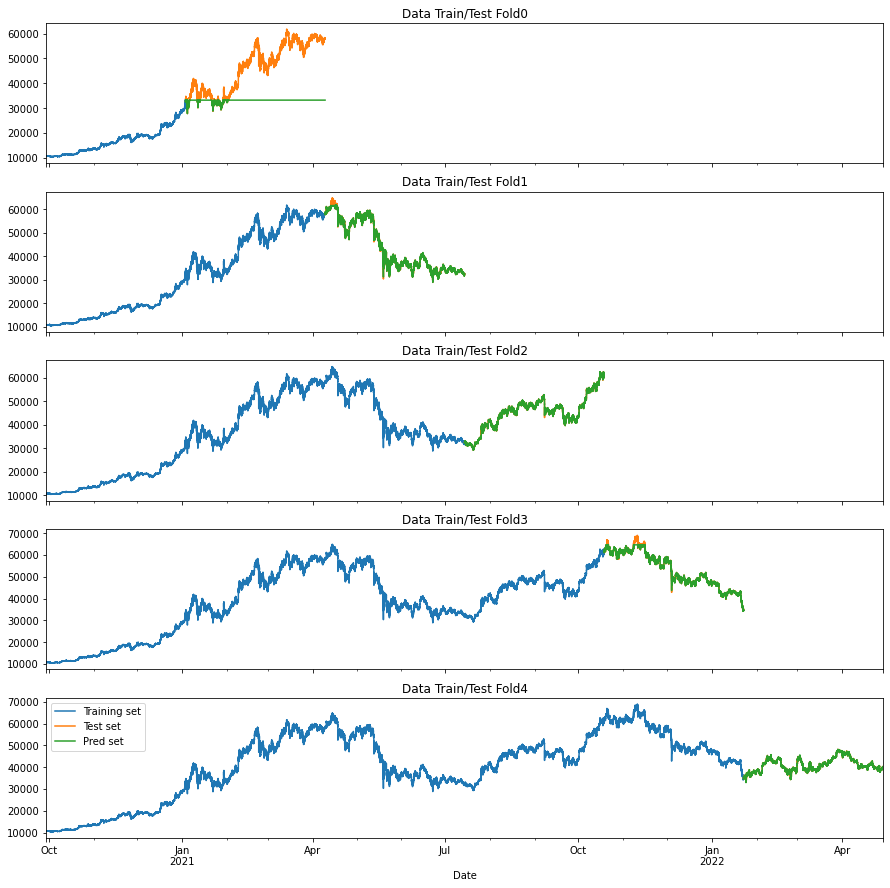

In [119]:
%%time 
Best_trial = {'n_estimators': 600, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 0.5, 'reg_lambda': 0.1}
tss = TimeSeriesSplit(n_splits=5)
time_step = 10 
rmse, mae = [], []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
for train_idx, test_idx in tss.split(btc_df):
    print(f'------------------------round{fold+1}--------------------------------')
    train_data = np.array(btc_df.iloc[train_idx])
    test_data = np.array(btc_df.iloc[test_idx])
    
    train_data_len = len(train_data)
    x_train = []
    y_train = []
    
    for i in range(time_step, len(train_data)):
        x_train.append(train_data[i-time_step:i, 0])
        y_train.append(train_data[i, 0])

    #convert the x_train and y_train to np array
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # create the testing dataset
    x_test = []
    y_test = []
    for i in range(time_step, len(test_data)):
        x_test.append(test_data[i-time_step:i, 0])
        y_test.append(test_data[i, 0])
    x_test = np.array(x_test)

    model = XGBRegressor(**Best_trial, seed=42)
    model.fit(x_train, y_train, verbose=False)
    
    predictions = model.predict(x_test)
    rmse.append(get_rmse(predictions, y_test))
    mae.append(get_mae(predictions, y_test))
    
    train = btc_df.iloc[train_idx]
    valid = btc_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
cv_mae = np.mean(mae)
print('rmse:', rmse)
print('mae:', mae)
print('cv_rmse=', cv_rmse)
print('cv_mae=', cv_mae)
plt.legend()
plt.show()

### ETH

In [48]:
def objective(trial):
    clear_session()
    global x_train, y_train, x_test, y_test
    
    # tf.keras.utils.set_random_seed(42)
    time_step = 10 
    xgb_params = {
        "n_estimators":trial.suggest_categorical("n_estimators", [400, 500, 600, 800, 1000]),
        "max_depth":trial.suggest_int("max_depth", 3, 10), 
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 6),
        'gamma': trial.suggest_categorical('gamma', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0.05, 0.1, 1, 2, 3])
    }    
    
    model = XGBRegressor(**xgb_params, seed=42)
        
    all_rmse = []
    fold = 0
    dataset = eth_df_op.copy()
    
    # 5-fold time series CV
    tss = TimeSeriesSplit(n_splits=5)
    for train_idx, test_idx in tss.split(eth_df_op):
        train_data = np.array(dataset.iloc[train_idx])
        test_data = np.array(dataset.iloc[test_idx])

        x_train = []
        y_train = []
        for i in range(time_step, len(train_data)):
            x_train.append(train_data[i-time_step:i, 0])
            y_train.append(train_data[i, 0])
        x_train, y_train = np.array(x_train), np.array(y_train)

        x_test = []
        y_test = []
        for i in range(time_step, len(test_data)):
            x_test.append(test_data[i-time_step:i, 0])
            y_test.append(test_data[i, 0])
        x_test = np.array(x_test)
        y_test = np.array(y_test) 
        
        model.fit(x_train, y_train, verbose=False)

    #     Evaluate the model accuracy on the validation set.
    #     score = model.evaluate(x_test, y_test, verbose=0)
    #     return score
        predictions = model.predict(x_test)
        all_rmse.append(get_rmse(predictions, y_test))
        fold += 1      
    return np.mean(all_rmse)


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-28 14:20:36,298] A new study created in memory with name: no-name-45650fda-6394-4acf-a458-9577586dedd9
[I 2022-11-28 14:20:39,160] Trial 0 finished with value: 252.8741366165882 and parameters: {'n_estimators': 800, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.2, 'reg_lambda': 0.1}. Best is trial 0 with value: 252.8741366165882.
[I 2022-11-28 14:20:43,631] Trial 1 finished with value: 262.99492470619305 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.4, 'reg_lambda': 0.1}. Best is trial 0 with value: 252.8741366165882.
[I 2022-11-28 14:20:46,011] Trial 2 finished with value: 275.27912382409096 and parameters: {'n_estimators': 600, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.5, 'reg_lambda': 0.05}. Best is trial 0 with value: 252.8741366165882.
[I 2022-11-28 14:20:48,494] Trial 3 finished with value: 261.54011681893155 and parameters: {'n_estimators': 500, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.4, 'reg_lambda': 0.

[I 2022-11-28 14:22:05,926] Trial 33 finished with value: 246.59997913750257 and parameters: {'n_estimators': 400, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 0.5, 'reg_lambda': 3}. Best is trial 17 with value: 246.5727258989719.
[I 2022-11-28 14:22:07,957] Trial 34 finished with value: 251.56468280788962 and parameters: {'n_estimators': 400, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.1, 'reg_lambda': 3}. Best is trial 17 with value: 246.5727258989719.
[I 2022-11-28 14:22:12,476] Trial 35 finished with value: 247.45682782558725 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.4, 'reg_lambda': 3}. Best is trial 17 with value: 246.5727258989719.
[I 2022-11-28 14:22:14,460] Trial 36 finished with value: 249.86582641811128 and parameters: {'n_estimators': 400, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 0.2, 'reg_lambda': 0.05}. Best is trial 17 with value: 246.5727258989719.
[I 2022-11-28 14:22:16,725] Trial 37 finished with value: 26

[I 2022-11-28 14:23:53,887] Trial 67 finished with value: 250.2562588233784 and parameters: {'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.3, 'reg_lambda': 1}. Best is trial 54 with value: 243.58438963874522.
[I 2022-11-28 14:23:56,259] Trial 68 finished with value: 243.55807620409527 and parameters: {'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.4, 'reg_lambda': 3}. Best is trial 68 with value: 243.55807620409527.
[I 2022-11-28 14:23:58,638] Trial 69 finished with value: 243.55807620409527 and parameters: {'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.4, 'reg_lambda': 3}. Best is trial 68 with value: 243.55807620409527.
[I 2022-11-28 14:24:01,163] Trial 70 finished with value: 250.12603184332457 and parameters: {'n_estimators': 500, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.4, 'reg_lambda': 2}. Best is trial 68 with value: 243.55807620409527.
[I 2022-11-28 14:24:03,544] Trial 71 finished with value: 243

Number of finished trials: 100
Best trial:
  Value: 241.71947275788798
  Params: 
    n_estimators: 500
    max_depth: 8
    min_child_weight: 5
    gamma: 0.4
    reg_lambda: 3


------------------------round1--------------------------------
------------------------round2--------------------------------
------------------------round3--------------------------------
------------------------round4--------------------------------
------------------------round5--------------------------------
cv_rmse= 338.2406265871888
cv_mae= 83.3253180473146


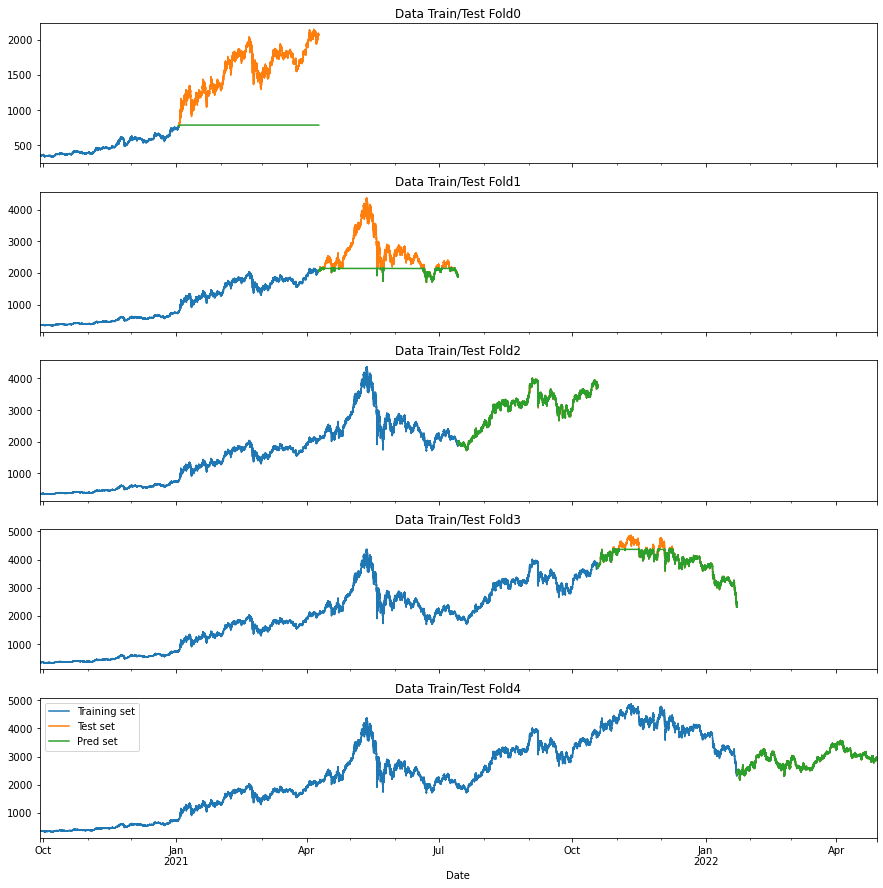

In [50]:
%%time 
Best_trial = {'n_estimators': 500, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 0.4, 'reg_lambda': 3}
tss = TimeSeriesSplit(n_splits=5)
time_step = 10 
rmse, mae = [], []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
for train_idx, test_idx in tss.split(eth_df):
    print(f'------------------------round{fold+1}--------------------------------')
    train_data = np.array(eth_df.iloc[train_idx])
    test_data = np.array(eth_df.iloc[test_idx])
    
    train_data_len = len(train_data)
    x_train = []
    y_train = []
    
    for i in range(time_step, len(train_data)):
        x_train.append(train_data[i-time_step:i, 0])
        y_train.append(train_data[i, 0])

    #convert the x_train and y_train to np array
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # create the testing dataset
    x_test = []
    y_test = []
    for i in range(time_step, len(test_data)):
        x_test.append(test_data[i-time_step:i, 0])
        y_test.append(test_data[i, 0])
    x_test = np.array(x_test)

    model = XGBRegressor(**Best_trial, seed=42)
    model.fit(x_train, y_train, verbose=False)
    
    predictions = model.predict(x_test)
    rmse.append(get_rmse(predictions, y_test))
    mae.append(get_mae(predictions, y_test))
    
    train = eth_df.iloc[train_idx]
    valid = eth_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
cv_mae = np.mean(mae)
print('rmse:', rmse)
print('mae:', mae)
print('cv_rmse=', cv_rmse)
print('cv_mae=', cv_mae)
plt.legend()
plt.show()

**Note** I used daily data but not minute-by-minute data to train the last two models

## ARIMA

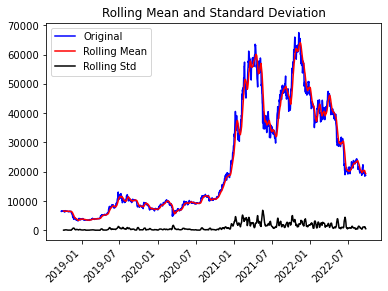

Results of dickey fuller test
Test Statistics                  -1.353307
p-value                           0.604446
No. of lags used                 12.000000
Number of observations used    1448.000000
critical value (1%)              -3.434874
critical value (5%)              -2.863538
critical value (10%)             -2.567834
dtype: float64


In [127]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()  # rolling mean of 12 samples
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries, autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],
                       index=[
                           'Test Statistics', 'p-value', 'No. of lags used',
                           'Number of observations used'
                       ])
    for key, values in adft[4].items():
        output['critical value (%s)' % key] = values
    print(output)


test_stationarity(btc_df_op)

We can’t rule out the Null hypothesis(The series has a unit root (value of a =1), i.e. , the series is said to be non-stationary) because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear. **Seasonality and trend may need to be separated from our series before we can undertake a time series analysis**. This approach will cause the resulting series to become stagnant.

<Figure size 432x288 with 0 Axes>

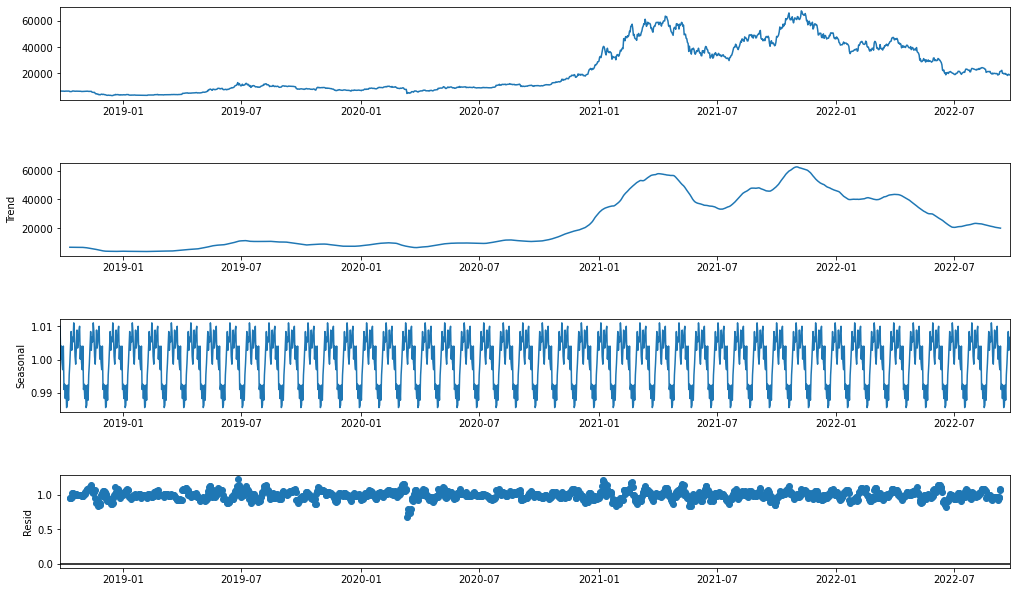

In [128]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(btc_df_op, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


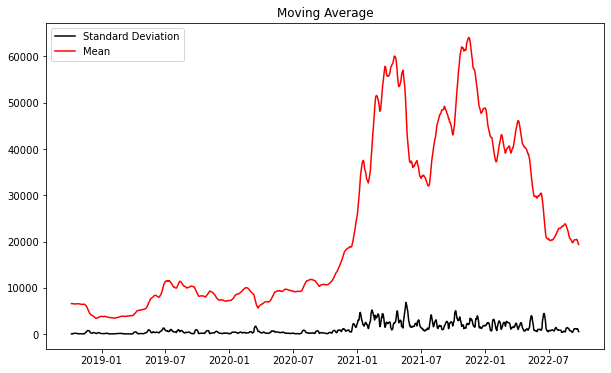

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
# df_log = np.log(btc_df)
df_log = btc_df_op
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

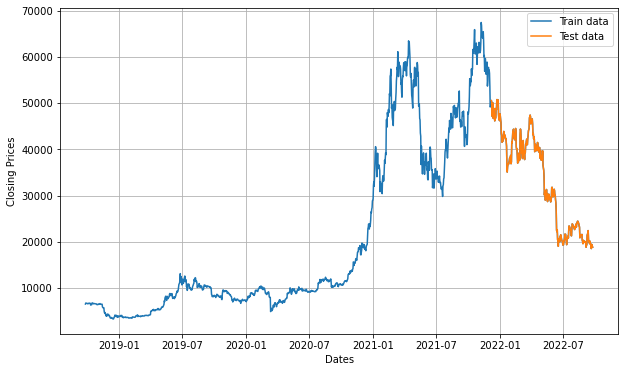

In [ ]:
#split data into train and training set
train_data, test_data = df_log[:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, label='Train data')
plt.plot(test_data, label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19646.933, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19646.090, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19646.145, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19646.326, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19648.042, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19648.066, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19650.043, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=19645.631, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=19647.561, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19647.573, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19645.688, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=19649.560, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.605 seconds
                               SARIMAX Results                              

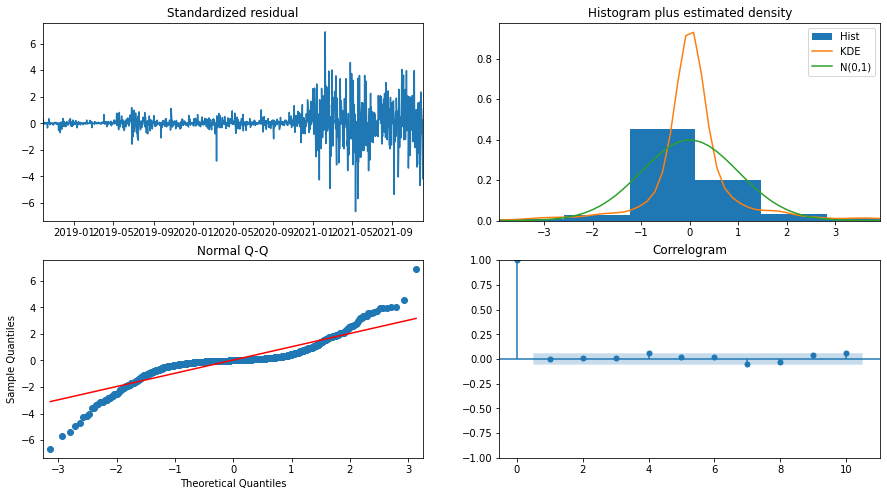

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Top left: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

Top Right: The density plot on the top right suggests a normal distribution with a mean of zero.

Bottom left: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

Bottom Right: The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

In [ ]:
train_data, test_data = train_data.values, test_data.values
history = [x for x in train_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = np.sqrt(mean_squared_error(test_data, model_predictions))
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 1184.6455243482496


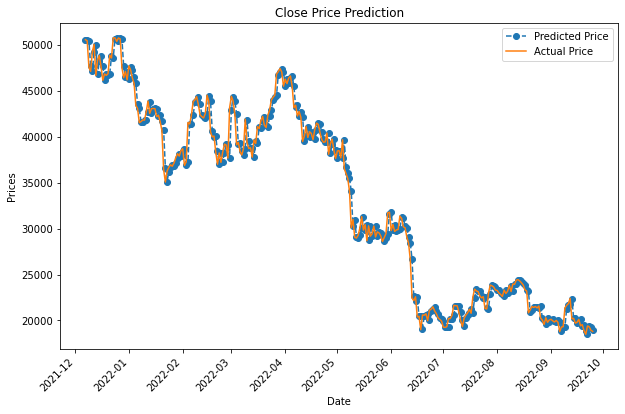

In [ ]:
test_set_range = df_log[int(len(df_log)*0.8):].index
plt.figure(figsize=(10,6))
plt.plot(test_set_range, model_predictions, marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, label='Actual Price')
plt.title('Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

In [ ]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1168
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -9820.816
Date:                Wed, 12 Oct 2022   AIC                          19645.631
Time:                        15:54:17   BIC                          19655.756
Sample:                             0   HQIC                         19649.450
                               - 1168                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0478      0.019     -2.490      0.013      -0.085      -0.010
sigma2      1.195e+06   2.07e+04     57.630      0.000    1.15e+06    1.24e+06
Ljung-Box (L1) (Q):                   0.00   Jarque-

------------------------round1--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:05<00:00, 44.85it/s]


------------------------round2--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:06<00:00, 37.33it/s]


------------------------round3--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:08<00:00, 29.44it/s]


------------------------round4--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:10<00:00, 23.91it/s]


------------------------round5--------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:12<00:00, 20.03it/s]


cv_rmse= 11122.362110414615
cv_mae= 8945.962512678034


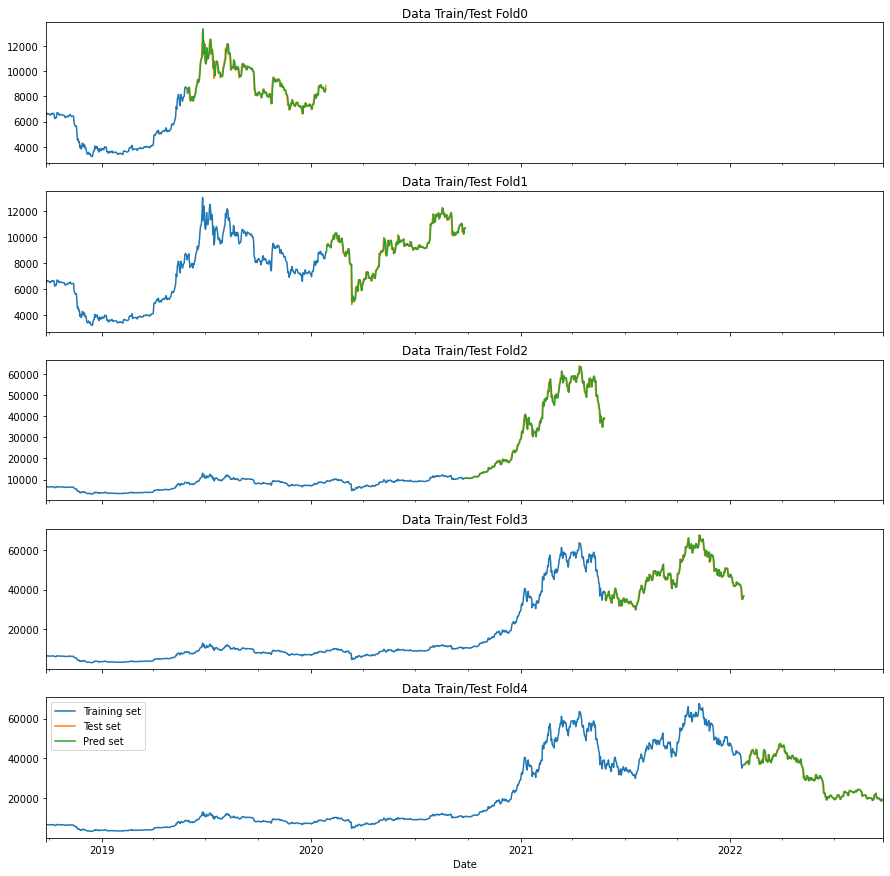

In [63]:
%%time 
tss = TimeSeriesSplit(n_splits=5)
rmse, mae = [], []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
for train_idx, test_idx in tss.split(btc_df_op):
    print(f'------------------------round{fold+1}--------------------------------')
    train_data = np.array(btc_df_op.iloc[train_idx])
    test_data = np.array(btc_df_op.iloc[test_idx])    

    history = [x for x in train_data]
    predictions = []
    N_test_observations = len(test_data)
    for time_point in tqdm(range(N_test_observations)):
        model = ARIMA(history, order=(2,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test_data[time_point])
    del model
        # history = history[1:]

    rmse.append(get_rmse(predictions, y_test))
    mae.append(get_mae(predictions, y_test))
    
    train = btc_df_op.iloc[train_idx]
    valid = btc_df_op.iloc[test_idx]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
cv_mae = np.mean(mae)
print('rmse:', rmse)
print('mae:', mae)
print('cv_rmse=', cv_rmse)
print('cv_mae=', cv_mae)
plt.legend()
plt.show()

In [64]:
mae 

[1636.759660087516,
 1780.7550242447883,
 19949.15285480312,
 10840.221187813804,
 10522.923836440948]

## Facebook Prophet

In [ ]:
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
import datetime as dt
pd.core.common.is_list_like = pd.api.types.is_list_like
import seaborn as sns
import matplotlib.dates as mdates

In [133]:
data = btc_df_op.reset_index()
data=data[["Date","Price"]]
data=data.rename(columns={"Date": "ds", "Price": "y"})

In [134]:
train_data_pro, test_data_pro = data[:int(len(data)*0.8)], data[int(len(data)*0.8):]

In [ ]:
m = Prophet()
m.fit(train_data_pro)
future = m.make_future_dataframe(periods = test_data_pro.shape[0])
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1456,2022-09-21,71439.271245,41966.425294,103206.363811
1457,2022-09-22,71411.962225,42099.555316,104688.792613
1458,2022-09-23,71551.546230,42109.956743,104852.922606
1459,2022-09-24,71622.946107,42271.442465,104805.119789
1460,2022-09-25,71720.196979,42687.608484,104976.014617


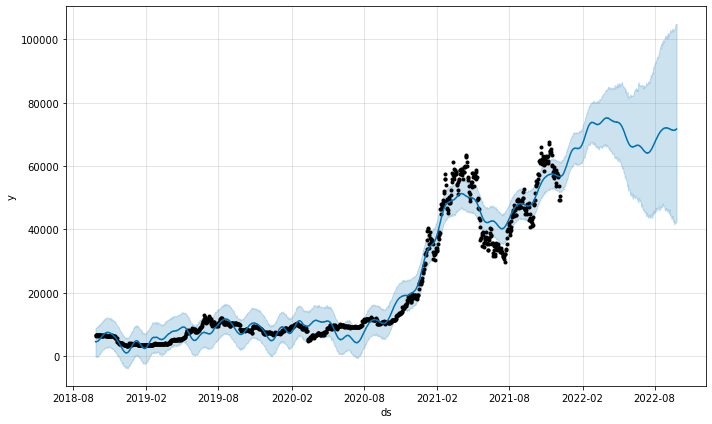

In [ ]:
fig1 = m.plot(forecast)

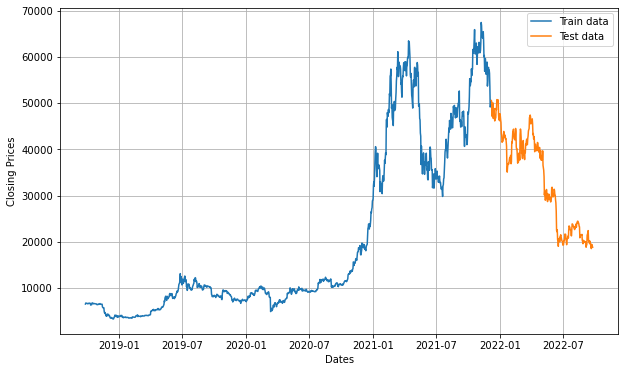

In [ ]:
train_data, test_data = btc_df[:int(len(btc_df_op)*0.8)], btc_df[int(len(btc_df_op)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, label='Train data')
plt.plot(test_data, label='Test data')
plt.legend()

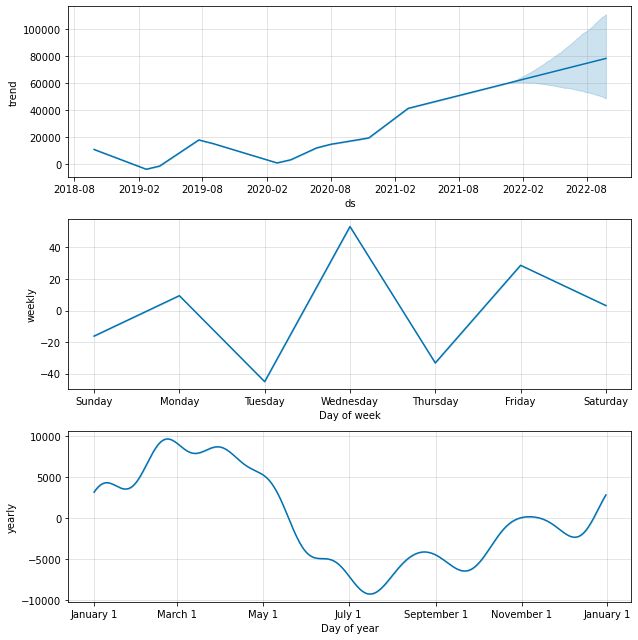

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
rmse = np.sqrt(np.mean((forecast['yhat'] - test_data_pro['y']) ** 2))
print(rmse)

37481.99733585797


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


------------------------round1--------------------------------


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


------------------------round2--------------------------------
------------------------round3--------------------------------
------------------------round4--------------------------------
------------------------round5--------------------------------
cv_rmse= 17748.92487578952
cv_mae= 16255.968828358595


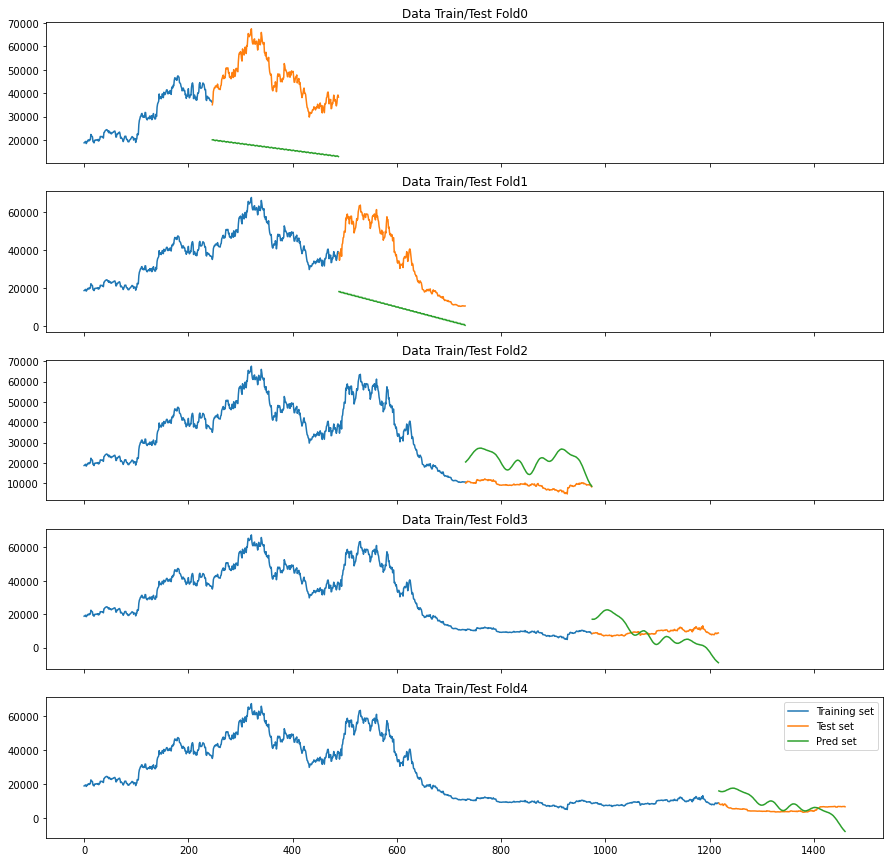

In [16]:
%%time 
tss = TimeSeriesSplit(n_splits=5)
rmse, mae = [], []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0

for train_idx, test_idx in tss.split(data):
    print(f'------------------------round{fold+1}--------------------------------')
    train_data = data.iloc[train_idx]
    test_data = data.iloc[test_idx]    

    m = Prophet(daily_seasonality=True)
    m.fit(train_data)
    future = m.make_future_dataframe(periods = test_data.shape[0])
    predictions = m.predict(future)
        # history = history[1:]

    rmse.append(get_rmse(predictions, y_test))
    mae.append(get_mae(predictions, y_test))
    
    train = data.iloc[train_idx]
    valid = data.iloc[test_idx]   
    valid['Predections'] = predictions['yhat']
    train['y'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['y'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
cv_mae = np.mean(mae)
print('rmse:', rmse)
print('mae:', mae)
print('cv_rmse=', cv_rmse)
print('cv_mae=', cv_mae)
plt.legend()
plt.show()

# Conclusion

As previously presented, this paper uses machine learning technology to predict the price of Bitcoin. Different from traditional research, this research applied time2vec, embedded it into lstm, and compared it with some common models. It was discovered that time2vec has great benefits in helping other models improve in crypto currency price prediction. Some models take time over ten minutes to train, such as Bi-LSTM, GRU, they might not be suitable for high-frequency prediction, but the LSTM+T2V model for ETH satisfies the time limitation.
In addition, the scale of our data is much larger than previous studies. And with Optuna, the performance of each model was further improved. 
Besides, in previous researches, Bi-LSTM mostly performed well, but in this research, under the background of using high-frequency large-scale data, the performance of bi-lstm dropped sharply. 

There are still some details to be improved in this paper, which need to be further studied. The future work can be divided into 

- Except for the price history, It can be  can be looked into more factors that influence cryptocurrency prices, e.g. macroeconomic variables, investor's attention. Especially, some natural language processing and sentiment analysis might bring some boost. 

- Some models applied on time series data should be further included for comparison, but the operating efficiency of the model and whether it can be trained using GPU need to be cared.